# Minigraph Mtb SV Pan-Genome Evaluation
## Part 2: Sequence content analysis


### Import Statements

In [35]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

In [37]:
from Bio import SeqIO
import plotly.express as px

# https://github.com/ipython/ipython/issues/10627
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [38]:
import ete3 as rec
from ete3 import Tree

In [39]:
import json

Import [Gfapy](https://github.com/ggonnella/gfapy)

In [40]:
import gfapy

In [41]:
# https://bioframe.readthedocs.io/en/latest/guide-intervalops.html
import bioframe as bf
import bioframe.vis

#### Pandas Viewing Settings

In [42]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [43]:
import time

# Import/parse processed H37rv genome annotations

In [44]:
RepoRef_Dir = "../../References"

#ESX_Genes_List_TSV = f"{RepoRef_Dir}/190927_H37rv_ListOf_ESXgenes.tsv"

AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir = f"{RepoRef_Dir}/201027_H37rv_AnnotatedGenes_And_IntergenicRegions"
H37Rv_GenomeAnnotations_Genes_TSV = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.Genes.tsv"
H37Rv_GenomeAnnotations_IntergenicRegions_TSV = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.IntergenicRegions.tsv"
H37Rv_GenomeAnnotations_Genes_And_IntergenicRegions_TSV = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.Genes.And.IntergenicRegions.tsv"    
H37Rv_GenomeAnnotations_Genes_And_IntergenicRegions_BED = f"{AnnotatedGenes_And_IntergenicRegions_RepoRef_Dir}/H37Rv_GenomeAnnotations.Genes.And.IntergenicRegions.bed"

## H37Rv Gene Annotations TSV
H37Rv_GenomeAnno_Genes_DF = pd.read_csv(H37Rv_GenomeAnnotations_Genes_TSV, sep = "\t")
H37Rv_GeneInfo_Subset_DF = H37Rv_GenomeAnno_Genes_DF[["H37rv_GeneID", "Symbol", "Feature", "Functional_Category", "Is_Pseudogene", "Product", "PEandPPE_Subfamily", "ExcludedGroup_Category"]]

RvID_To_Symbol_Dict = dict(H37Rv_GeneInfo_Subset_DF[['H37rv_GeneID', 'Symbol']].values)
Symbol_To_FuncCat_Dict = dict(H37Rv_GeneInfo_Subset_DF[['Symbol', 'Functional_Category']].values)
#Esx_Genes_DF = pd.read_csv(ESX_Genes_List_TSV, sep = '\t')



In [45]:
H37Rv_GenomeAnno_Genes_DF.head(5)

,Chrom,Start,End,Strand,H37rv_GeneID,Symbol,Feature,Functional_Category,Is_Pseudogene,Product,PEandPPE_Subfamily,ExcludedGroup_Category
0,NC_000962.3,0,1524,+,Rv0001,dnaA,CDS,information pathways,No,Chromosomal replication initiator protein DnaA,None,NotExcluded
1,NC_000962.3,2051,3260,+,Rv0002,dnaN,CDS,information pathways,No,DNA polymerase III (beta chain) DnaN (DNA nucl...,None,NotExcluded
2,NC_000962.3,3279,4437,+,Rv0003,recF,CDS,information pathways,No,DNA replication and repair protein RecF (singl...,None,NotExcluded
3,NC_000962.3,4433,4997,+,Rv0004,Rv0004,CDS,conserved hypotheticals,No,Conserved hypothetical protein,None,NotExcluded
4,NC_000962.3,5239,7267,+,Rv0005,gyrB,CDS,information pathways,No,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,None,NotExcluded


In [46]:
H37Rv_GenomeAnno_Genes_DF["Functional_Category"].value_counts()

conserved hypotheticals                    1042
intermediary metabolism and respiration     936
cell wall and cell processes                772
lipid metabolism                            272
information pathways                        242
virulence, detoxification, adaptation       239
regulatory proteins                         198
PE/PPE                                      168
insertion seqs and phages                   147
stable RNAs                                  48
unknown                                      15
Name: Functional_Category, dtype: int64

# Parse sample metadata & preprocessed genome info/results

In [47]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"
!mkdir $InputAsmPath_Dir

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"


mkdir: cannot create directory ‘../../Data/231121.InputAsmTSVs.MtbSetV3.151CI’: File exists


## Parse sample Metadata (N = 151)

In [48]:

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

#print(','.join(SampleIDs_151CI_SOI) )

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [49]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

#MtbWGA_SMK_Pipeline_OutputDir = WGA_SMK_Outputs_Dir + "/220427_WGA158CI_V1"
WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
MtbWGA_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir

## Define PATHS relevant to Minigraph analysis

In [50]:
target_OutputDir = MtbWGA_SMK_Pipeline_OutputDir

Minigraph_158CI_OutDir = f"{target_OutputDir}/Minigraph"

MG_WGA158CI_GFA = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.V1.gfa"
MG_WGA158CI_Bubble_SV_BED = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.V1.Bubble.SV.bed"
MG_WGA158CI_Stable_FA = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.V1.Stable.fa"

MG_WGA158CI_MergedSVInfo_TSV = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.MergedSV.Info.tsv"
MG_WGA158CI_MergedSVInfo_SVVCF = f"{Minigraph_158CI_OutDir}/Minigraph_H37rv_Vs_158CI.MergedSV.Info.svvcf"


In [51]:
Minigraph_158CI_OutDir

'/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph'

In [52]:
#!ls -alh $Minigraph_158CI_OutDir

In [53]:
!gfatools stat $MG_WGA158CI_GFA

Number of segments: 3138
Number of links: 4705
Number of arcs: 9410
Max rank: 129
Total segment length: 5196363
Average segment length: 1655.947
Sum of rank-0 segment lengths: 4411532
Max degree: 8
Average degree: 1.499
[M::main] Version: 0.5-r253-dirty
[M::main] CMD: gfatools stat /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph/Minigraph_H37rv_Vs_158CI.V1.gfa
[M::main] Real time: 0.023 sec; CPU: 0.038 sec


## Read in the "SV Info TSV" (From Minigraph)

In [54]:
Header_WiSamplesIDs_InOrderSV = ["Chr", "Start", "End", "Info", "FORMAT",
       'NC_000962.3','N0072','N0153','TB3113','TB1236','TB2659','TB2780','TB1612','TB2512','TB2981','TB3091',
       'M0003941_3','TB3368','N0145','N0155','TB2995','TB3396','N0004','N1274','N0054','02_R1179','01_R1134',
     'M0017522_5','M0016395_7','M0010874_7','02_R1708','02_R0894','01_R1430','M0014888_3','02_R1896','TB4620',
     'TB3162','MT_0080','TB3054','TB3251','M0016737_0','TB2661','TB3237','TB3169','TB3386','TB3334','M0011368_9',
     'TB2968','N1272','N1176','N1202','N1177','N0091','RW-TB008','9050-05','4549-04','696-05','702-06','706-05',
     '8129-04','3003-06','8651-04','QC-3','QC-9','QC-5','QC-8','QC-10','QC-4','QC-7','QC-6','QC-1','mada_1-10',
     'mada_2-46','mada_1-1','mada_1-36','mada_1-39','mada_1-51','mada_1-44','mada_117','mada_118','mada_122',
     'mada_107','R27252','R23887','R30215','R30078','R29816','R30234','18_0621851','R36431','R28703','mada_115',
     'mada_2-42','R31095','R28012','R37765','R27657','R25048','R24120','R28581','R29598','mada_1-11','R24100',
     'R21408','R20574','R20260','R18043','R22601','R23146','R32929','R21893','R30420','R26778','R26791','R28980',
     'R27725','R18040','R27937','mada_1-30','mada_2-31','mada_1-41','R21770','R21839','mada_1-32','R30396',
     'R21363','R20896','mada_102','mada_129','mada_139','mada_151','mada_105','R15311','mada_103','mada_2-25',
     'mada_112','mada_124','mada_126','mada_120','R23571','mada_128','mada_1-12','mada_1-15','mada_2-1','mada_1-53',
     'mada_1-50','mada_123','mada_2-53','mada_1-38','S0070-08','S0085-01','S0107-01','S0089-01','S0256-08','S0123-01',
     'S0106-01', 'S0262-02']

In [55]:
len(Header_WiSamplesIDs_InOrderSV)

157

In [56]:
157 - 6

151

In [57]:
MG_SVInfo_DF = pd.read_csv(MG_WGA158CI_MergedSVInfo_TSV, sep = "\t", comment = "#",
                           header = None)

MG_SVInfo_DF.columns = Header_WiSamplesIDs_InOrderSV

MG_SVInfo_DF["NA"] = MG_SVInfo_DF["Info"].str.split(";").str[1].str.split("=").str[-1].astype(int)

MG_SVInfo_DF["BubbleNum"] = (MG_SVInfo_DF.index.values + 1)
MG_SVInfo_DF["BubbleID"] = "BubbleRegion_" + MG_SVInfo_DF["BubbleNum"].astype(str)

MG_SVInfo_DF.shape

(535, 160)

In [58]:
MG_SVInfo_DF.head(2)

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
0,NC_000962.3,1533,1533,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=*,GT:CSTRAND:CTG:CS:CE,0:+:NC_000962.3:1531:1601,0:+:N0072:1531:1601,0:+:N0153:1531:1601,0:+:TB3113:1531:2959,0:+:TB1236:1531:2959,0:+:TB2659:1531:2959,0:+:TB2780:1531:2959,0:+:TB1612:1531:2959,0:+:TB2512:1531:2959,0:+:TB2981:1531:2959,0:+:TB3091:1531:2959,0:+:M0003941_3:1531:2959,0:+:TB3368:1531:2959,0:+:N0145:1531:2959,0:+:N0155:1531:2959,0:+:TB2995:1531:2959,0:+:TB3396:1531:2959,0:+:N0004:1531:1601,0:+:N1274:1531:1601,0:+:N0054:1531:1601,0:+:02_R1179:1531:1601,0:+:01_R1134:1531:1601,0:+:M0017522_5:1531:1601,0:+:M0016395_7:1531:1601,0:+:M0010874_7:1531:1601,0:+:02_R1708:1531:1601,0:+:02_R0894:1531:1601,0:+:01_R1430:1531:1601,0:+:M0014888_3:1531:1601,0:+:02_R1896:1531:1601,0:+:TB4620:1531:1601,0:+:TB3162:1531:1601,0:+:MT_0080:1531:1601,0:+:TB3054:1531:1601,0:+:TB3251:1531:1601,0:+:M0016737_0:1531:1601,0:+:TB2661:1531:1601,0:+:TB3237:1531:1601,0:+:TB3169:1531:1601,0:+:TB3386:1531:1601,0:+:TB3334:1531:1601,0:+:M0011368_9:1531:1601,0:+:TB2968:1531:1601,0:+:N1272:1531:1601,0:+:N1176:1531:1601,0:+:N1202:1531:1601,0:+:N1177:1531:1601,0:+:N0091:1531:1601,0:+:RW-TB008:1531:1601,0:+:9050-05:1531:2960,0:+:4549-04:1531:2959,0:+:696-05:1531:2961,0:+:702-06:1531:2960,0:+:706-05:1531:2959,0:+:8129-04:1531:2960,0:+:3003-06:1531:2960,0:+:8651-04:1531:2959,0:+:QC-3:1531:1601,0:+:QC-9:1531:1601,0:+:QC-5:1531:1601,0:+:QC-8:1531:1601,0:+:QC-10:1531:1601,0:+:QC-4:1531:1601,0:+:QC-7:1531:1601,0:+:QC-6:1531:1601,0:+:QC-1:1531:1601,0:+:mada_1-10:1531:1601,0:+:mada_2-46:1531:1601,0:+:mada_1-1:1531:1601,0:+:mada_1-36:1531:1601,0:+:mada_1-39:1531:1601,0:+:mada_1-51:1531:1601,0:+:mada_1-44:1531:1601,0:+:mada_117:1531:1601,0:+:mada_118:1531:1601,0:+:mada_122:1531:1601,0:+:mada_107:1531:1601,0:+:R27252:1531:1601,0:+:R23887:1531:1601,0:+:R30215:1531:2959,0:+:R30078:1531:2959,0:+:R29816:1531:2959,0:+:R30234:1531:2959,0:+:18_0621851:1531:2959,0:+:R36431:1531:2959,0:+:R28703:1531:2959,0:+:mada_115:1531:2959,0:+:mada_2-42:1531:2959,0:+:R31095:1531:2959,0:+:R28012:1531:2959,0:+:R37765:1531:2959,0:+:R27657:1531:2959,0:+:R25048:1531:2959,0:+:R24120:1531:2959,0:+:R28581:1531:2959,0:+:R29598:1531:2959,0:+:mada_1-11:1531:2959,0:+:R24100:1531:2959,0:+:R21408:1531:2959,0:+:R20574:1531:2959,0:+:R20260:1531:2959,0:+:R18043:1531:2959,0:+:R22601:1531:2959,0:+:R23146:1531:2959,0:+:R32929:1531:2959,0:+:R21893:1531:2959,0:+:R30420:1531:2959,0:+:R26778:1531:2959,0:+:R26791:1531:2959,0:+:R28980:1531:2959,0:+:R27725:1531:2959,0:+:R18040:1531:2959,0:+:R27937:1531:2959,0:+:mada_1-30:1531:1601,0:+:mada_2-31:1531:1601,0:+:mada_1-41:1531:1601,0:+:R21770:1531:1601,0:+:R21839:1531:1601,0:+:mada_1-32:1531:1601,0:+:R30396:1531:1601,0:+:R21363:1531:1601,0:+:R20896:1531:1601,0:+:mada_102:1531

## Parse the Bubble SV Summary BED from Minigraph

In [59]:
MG_SV_BED_DF = pd.read_csv(MG_WGA158CI_Bubble_SV_BED, sep = "\t", header=None)

MG_SV_BED_DF.columns = ["Chr", "Start", "End", "Unk1", "Unk2", "Unk3", "Len_Ref", "Len_Alt", 
                        "Unk4", "Unk5", "Unk6", "NodePath", "Ref_Seq", "Alt_Seq"]

Target_Col = ["Chr", "Start", "End",
              "Len_Ref", "Len_Alt", 
              "NodePath", "Ref_Seq", "Alt_Seq"]

MG_SV_BED_DF = MG_SV_BED_DF[Target_Col]

# Remove the first and last nodes, these are not included in the SV of interest
MG_SV_BED_DF["NodePath_Trimmed"] = MG_SV_BED_DF["NodePath"].str.split(",").str[1:-1]

MG_SV_BED_DF["Start_Node"] = MG_SV_BED_DF["NodePath"].str.split(",").str[0]
MG_SV_BED_DF["End_Node"] = MG_SV_BED_DF["NodePath"].str.split(",").str[-1]
MG_SV_BED_DF["BubbleNum"] = (MG_SV_BED_DF.index.values + 1)

MG_SV_BED_DF["BubbleID"] = "BubbleRegion_" + MG_SV_BED_DF["BubbleNum"].astype(str)

MG_SV_BED_DF["NumSVNodes"] = MG_SV_BED_DF["NodePath_Trimmed"].str.len()

MG_SV_BED_DF.shape

(535, 14)

In [60]:
MG_SV_BED_DF.head(3)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes
0,NC_000962.3,1533,1533,0,0,"s1,s2",*,*,[],s1,s2,1,BubbleRegion_1,0
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...",ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",*,TGAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAG...,[s2744],s5,s6,3,BubbleRegion_3,1


In [61]:
MG_SV_BED_DF.query(" Len_Alt > 9000 & Len_Alt < 9500")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes
13,NC_000962.3,103789,103789,0,9248,"s27,s2603,s28",*,GGACTGCTGAAGAACATTCCACGCCAGGAGATCAACCATGACCACC...,[s2603],s27,s28,14,BubbleRegion_14,1
18,NC_000962.3,171456,180519,6417,9151,"s43,s44,s2811,s2248,s45,s46,s47,s2477,s48,s296...",CCGACTGCCTGGCTAGCCGAGGGCTTGCTACCCTACCTGCCCGGCG...,CGGCCGACGCGTGCATCGGGTTGCCTGCGACTACCAGGCGGTGCGC...,"[s44, s2811, s2248, s45, s46, s47, s2477, s48,...",s43,s51,19,BubbleRegion_19,11
189,NC_000962.3,1714723,1721213,2909,9207,"s566,s2654,s567,s2150,s2151,s2396,s2412,s2397,...",TGAACCGCCCCGGCATGTCCGGAGACTCCAGTTCTTGGAAAGGATG...,CACGATCCCGATGCCGATGGTGAAACCGGCCTGAGCCATCGTGTTG...,"[s2654, s567, s2150, s2151, s2396, s2412, s239...",s566,s572,190,BubbleRegion_190,14
193,NC_000962.3,1779276,1788523,0,9247,"s576,s577,s578,s579,s580",*,GGACTGCTGAAGAACATTCCACGCCAGGAGATCAACCATGACCACC...,"[s577, s578, s579]",s576,s580,194,BubbleRegion_194,3
224,NC_000962.3,2025845,2028969,0,9237,"s705,s706,s3092,s707,s708,s709",*,GGCGGTTGCGTCGGTCAGCTGGCCGAATCCCAATGATTGGTGGCTC...,"[s706, s3092, s707, s708]",s705,s709,225,BubbleRegion_225,4
456,NC_000962.3,3884820,3884866,46,9294,"s1450,s2647,s1451,s2371,s1452,s1453",ACCACCCCACCTCGACCACGGCCAACCCCGCACCAACACCTTCCAC,ACCACCCCACCTCGACCACGGCCAACCGTGGACCTGTGAGATACAC...,"[s2647, s1451, s2371, s1452]",s1450,s1453,457,BubbleRegion_457,4
485,NC_000962.3,3945117,3950849,0,9190,"s1596,s1597,s1598,s2593,s1599,s2070,s1600,s160...",*,CATGCACGTCATCGGCTGGCCGCGCCTCGGTCTGCTCCTTGGCCCA...,"[s1597, s1598, s2593, s1599, s2070, s1600, s16...",s1596,s1645,486,BubbleRegion_486,115


In [62]:
#MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_194'")["Alt_Seq"].values

In [63]:
1779276 - 1788523

-9247

## Label Bubbles by overlapping Rv genes

In [64]:
# https://stackoverflow.com/questions/61109186/python-pandas-to-match-rows-with-overlapping-coordinates

listOf_Overlap_Genes = []
listOf_Overlap_Genes_RvIDs = []

for i, row in MG_SV_BED_DF.iterrows():
    
    # a) Target overlapping genes to event
    event_Start = int(row["Start"])
    event_End = int(row["End"])
    event_Range = f"NC_000962.3:{event_Start}-{event_End}"
    
    sub_DF_Overlap_Event_Genes = bf.select(H37Rv_GenomeAnno_Genes_DF, event_Range, cols = ("Chrom", "Start", "End"))    
    
    listOf_Overlap_Genes.append( ",".join(list(sub_DF_Overlap_Event_Genes["Symbol"].values)) )
    listOf_Overlap_Genes_RvIDs.append( ",".join(list(sub_DF_Overlap_Event_Genes["H37rv_GeneID"].values)) )

MG_SV_BED_DF["Overlap_Genes"] = listOf_Overlap_Genes
MG_SV_BED_DF["Overlap_Gene_RvIDs"] = listOf_Overlap_Genes_RvIDs
MG_SV_BED_DF["Overlap_Genes"] = MG_SV_BED_DF["Overlap_Genes"].fillna("None")


MG_SV_BED_Trim_DF = MG_SV_BED_DF.drop(["Ref_Seq", "Alt_Seq"], axis=1)


In [65]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_193'") 

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
192,NC_000962.3,1761789,1761789,0,3511,"s575,s1800,s2706,s1801,s576",*,TGCTGGTTGCCGTGGCGGTGGTGGCGGTCGCGGGATTCAGCGTCTA...,"[s1800, s2706, s1801]",s575,s576,193,BubbleRegion_193,3,mmpL6,Rv1557


In [66]:
PangenomeAnalysis_Dir = "../../Data/MtbPangenomeAnalysis_SetV3"


In [67]:
MG_SV_BED_Trim_DF.to_csv(f"{PangenomeAnalysis_Dir}/Mtb.SVPG.BubbleInfoWiAnno.tsv",
                                      sep = "\t", index=False)

In [68]:
MG_SV_BED_DF.head(2)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",*,*,[],s1,s2,1,BubbleRegion_1,0,,
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...",ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,,


In [69]:
MG_SV_BED_Trim_DF.head(2)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",[],s1,s2,1,BubbleRegion_1,0,,
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...","[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,,


### Create Dict of NodeID to BubbleID

In [70]:
NodeID_ToBubbleID_Dict = {}

for i, row in MG_SV_BED_DF.iterrows():
    
    Bubble_Num = i + 1
    
    BubbleID = "BubbleRegion_" + str(Bubble_Num)
    
    i_NodePath_Trimmed = row["NodePath_Trimmed"]
    
    for NodeID in i_NodePath_Trimmed:
        
        NodeID_ToBubbleID_Dict[NodeID] = BubbleID
        

In [71]:
NodeID_ToBubbleID_Dict["s3"]

'BubbleRegion_2'

## Identify NodeIDs of SV and Non-SV nodes

In [72]:
SV_NodeIDs_All = []

Non_SV_NodeIDs = []

for i, row in MG_SV_BED_DF.iterrows():

    i_NodePath_Trimmed = row["NodePath_Trimmed"]
    
    SV_NodeIDs_All += (i_NodePath_Trimmed)
    
    Non_SV_NodeIDs.append( row["Start_Node"] )
    Non_SV_NodeIDs.append( row["End_Node"] )


SV_NodeIDs_All = list(set(SV_NodeIDs_All))
Non_SV_NodeIDs = list(set(Non_SV_NodeIDs))


In [73]:
len(list(set(SV_NodeIDs_All)) )

2602

In [74]:
len(Non_SV_NodeIDs)

536

In [75]:
!gfatools stat $MG_WGA158CI_GFA

Number of segments: 3138
Number of links: 4705
Number of arcs: 9410
Max rank: 129
Total segment length: 5196363
Average segment length: 1655.947
Sum of rank-0 segment lengths: 4411532
Max degree: 8
Average degree: 1.499
[M::main] Version: 0.5-r253-dirty
[M::main] CMD: gfatools stat /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/Minigraph/Minigraph_H37rv_Vs_158CI.V1.gfa
[M::main] Real time: 0.017 sec; CPU: 0.029 sec


## Read in SV Info SV-VCF (From Minigraph)

In [76]:
SVVCF_Header_WiSamplesIDs_InOrderSV = ["Chr", "Pos", "ID", "Ref", "Alt", "QUAL", "FILTER", "Info", "FORMAT",
       'NC_000962.3','N0072','N0153','TB3113','TB1236','TB2659','TB2780','TB1612','TB2512','TB2981','TB3091',
       'M0003941_3','TB3368','N0145','N0155','TB2995','TB3396','N0004','N1274','N0054','02_R1179','01_R1134',
     'M0017522_5','M0016395_7','M0010874_7','02_R1708','02_R0894','01_R1430','M0014888_3','02_R1896','TB4620',
     'TB3162','MT_0080','TB3054','TB3251','M0016737_0','TB2661','TB3237','TB3169','TB3386','TB3334','M0011368_9',
     'TB2968','N1272','N1176','N1202','N1177','N0091','RW-TB008','9050-05','4549-04','696-05','702-06','706-05',
     '8129-04','3003-06','8651-04','QC-3','QC-9','QC-5','QC-8','QC-10','QC-4','QC-7','QC-6','QC-1','mada_1-10',
     'mada_2-46','mada_1-1','mada_1-36','mada_1-39','mada_1-51','mada_1-44','mada_117','mada_118','mada_122',
     'mada_107','R27252','R23887','R30215','R30078','R29816','R30234','18_0621851','R36431','R28703','mada_115',
     'mada_2-42','R31095','R28012','R37765','R27657','R25048','R24120','R28581','R29598','mada_1-11','R24100',
     'R21408','R20574','R20260','R18043','R22601','R23146','R32929','R21893','R30420','R26778','R26791','R28980',
     'R27725','R18040','R27937','mada_1-30','mada_2-31','mada_1-41','R21770','R21839','mada_1-32','R30396',
     'R21363','R20896','mada_102','mada_129','mada_139','mada_151','mada_105','R15311','mada_103','mada_2-25',
     'mada_112','mada_124','mada_126','mada_120','R23571','mada_128','mada_1-12','mada_1-15','mada_2-1','mada_1-53',
     'mada_1-50','mada_123','mada_2-53','mada_1-38','S0070-08','S0085-01','S0107-01','S0089-01','S0256-08','S0123-01',
     'S0106-01', 'S0262-02']  

In [77]:
#!head -n 18 $MG_WGA158CI_MergedSVInfo_SVVCF

In [78]:
MG_SVVCF_DF = pd.read_csv(MG_WGA158CI_MergedSVInfo_SVVCF, sep = "\t", comment = "#",
                           header = None)
MG_SVVCF_DF.columns = SVVCF_Header_WiSamplesIDs_InOrderSV

MG_SVVCF_DF["NA"] = MG_SVVCF_DF["Info"].str.split(";").str[1].str.split("=").str[-1].astype(int)
MG_SVVCF_DF["AWALK_Full"] = MG_SVVCF_DF["Info"].str.split(";").str[6].str.split("=").str[-1]
MG_SVVCF_DF["AWALK_List"] = MG_SVVCF_DF["Info"].str.split(";").str[6].str.split("=").str[-1].str.split(",")
MG_SVVCF_DF["BubbleID"] = MG_SV_BED_DF["BubbleID"]
MG_SVVCF_DF["Start_Node"] = MG_SV_BED_DF["Start_Node"]
MG_SVVCF_DF["End_Node"] = MG_SV_BED_DF["End_Node"]
MG_SVVCF_DF["NodePath_Trimmed"] = MG_SV_BED_DF["NodePath_Trimmed"]

MG_SVVCF_DF["NumSVNodes"] = MG_SVVCF_DF["NodePath_Trimmed"].str.len()

MG_SVVCF_DF.shape

(535, 169)

In [79]:
len(MG_SVVCF_DF["NodePath_Trimmed"].values[0])

0

In [80]:
MG_SVVCF_DF.head(3)

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
0,NC_000962.3,1533,.,N,<CNV>,30,PASS,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=...,GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1,*,[*],BubbleRegion_1,s1,s2,[],0
1,NC_000962.3,1591,.,N,<CNV>,30,PASS,NS=88;NA=1;ALEN=61;AC=88;VS=>s2;VE=>s5;AWALK=>...,GT:GT0,0:0,0:0,0:0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,.,0:0,0:0,.,.,.,.,.,.,.,.,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,.,0:0,0:0,.,.,.,.,.,0:0,0:0,0:0,1,>s3>s4,[>s3>s4],BubbleRegion_2,s2,s5,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",11
2,NC_000962.3,13622,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,1358;AC=151,1;VS=>s5;VE=>s6...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2744","[*, >s2744]",BubbleRegion_3,s5,s6,[s2744],1


In [81]:
MG_SVVCF_DF.query(" BubbleID == 'BubbleRegion_87' ")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
86,NC_000962.3,767589,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,174;AC=151,1;VS=>s229;VE=>s...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2805","[*, >s2805]",BubbleRegion_87,s229,s230,[s2805],1


## Reorder MG_SVVCF_DF column order

In [82]:
# "ID", "Ref", "Alt", "QUAL",

# Reordered to match the current order of the phylogeny
SVVCF_Header_WiSamplesIDs_Reordered = ["Chr", "Pos",  "FILTER", "BubbleID", "Start_Node", "End_Node", "NodePath_Trimmed",
                                       "Info", "FORMAT", "NA", "AWALK_Full", "AWALK_List",
                                       'NC_000962.3', 'mada_1-40', 'mada_1-44', 'mada_2-46', 'mada_107', 'mada_1-1', 'mada_1-51', 'mada_1-39', 
                                        'mada_122', 'mada_1-36', 'mada_117', 'mada_118', 'mada_1-10', 'N0072', 'N0153', 'R27252', 
                                        'R23887', 'R30078', 'R28012', 'R27657', 'R30234', 'R31095', 'R28703', 'R24120', 'MFS-3', 'R36431', 
                                        'R29816', 'MFS-42', 'DNA096', 'DNA114', 'DNA028', '706-05', 'DNA089', '9050-05', '3003-06', 
                                        '702-06', 'DNA019_Vash', '696-05', '8651-04', 'DNA091', '4549-04', 'ARR1960', 'AZE_02_041', 
                                        'ZRB10578980', '8129-04', 'DNA075', 'AZE_02_067', 'R30215', 'R25048', 'MFS-59', 'MFS-58', 
                                        'R29598', 'R24100', 'R28581', 'MFS-173', 'MFS-51', 'MFS-52', 'MFS-54', 'N0145', 'mada_1-11', 
                                        'N0155', 'mada_115', 'mada_2-42', 'M0003941_3', 'R37765', '18_0621851', 'R27937', 'R22601', 
                                        'R18040', 'R18043', 'R27725', 'R26791', 'R20574', 'R20260', 'R21408', 'R23146', 'R28980', 
                                        'R26778', 'R32929', 'R30420', 'R21893', 'QC-9', 'QC-5', 'QC-3', 'N0004', 'mada_1-30', 'N0054',
                                         'N1274', 'mada_1-53', 'mada_2-53', 'mada_1-50', 'mada_2-1', 'R23571', 'mada_1-2', 'mada_123', 
                                         '8644-04', 'mada_128', 'mada_1-12', 'mada_1-15', 'DNA120', 'mada_1-38', '01_R1134', 'mada_126', 
                                         'mada_120', 'DNA124', 'M0016737_0', 'DNA054', 'mada_112', 'mada_124', 'mada_103', 'MFS-60', 
                                         'MFS-61', 'MFS-181', '02_R1896', 'mada_2-25', 'DNA020', 'M0011368_9', '01_R1430', 'AZE_02_042', 
                                         'DNA086', 'DNA182', '02_R1179', 'QC-6', 'QC-1', 'QC-7', 'M0010874_7', 'M0016395_7', 'R15311', 
                                         'DNA044', 'M0014888_3', 'mada_151', 'DNA188', 'mada_105', 'QC-8', 'QC-10', 'QC-4', 'mada_129', 
                                         '02_R1708', '02_R0894', 'mada_139', 'DNA019_Rose', 'MT_0080', 'mada_102', 'R21839', 'R21363', 
                                         'R21770', 'R30396', 'R20896', 'mada_1-32', 'MFS-56', 'M0017522_5', 'mada_2-31', 'mada_1-41', 
                                         'N1272', 'N1176', 'N0091', 'N1202', 'N1177', 'RW-TB008']

#SVVCF_Header_WiSamplesIDs_Reordered = 
#
#SampleID_Cols = SVVCF_Header_WiSamplesIDs_Reordered[12:]

#MG_SVVCF_DF = MG_SVVCF_DF[SVVCF_Header_WiSamplesIDs_Reordered]

In [83]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_196'")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
195,NC_000962.3,1808139,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,110;AC=151,1;VS=>s582;VE=>s...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2806","[*, >s2806]",BubbleRegion_196,s582,s583,[s2806],1


In [84]:
MG_SVVCF_DF.head(1)  

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
0,NC_000962.3,1533,.,N,<CNV>,30,PASS,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=...,GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1,*,[*],BubbleRegion_1,s1,s2,[],0


## Read in SV Info TSV (From Minigraph)

In [85]:
Header_WiSamplesIDs_InOrderSV = ["Chr", "Start", "End", "Info", "FORMAT",
       'NC_000962.3','N0072','N0153','TB3113','TB1236','TB2659','TB2780','TB1612','TB2512','TB2981','TB3091',
       'M0003941_3','TB3368','N0145','N0155','TB2995','TB3396','N0004','N1274','N0054','02_R1179','01_R1134',
     'M0017522_5','M0016395_7','M0010874_7','02_R1708','02_R0894','01_R1430','M0014888_3','02_R1896','TB4620',
     'TB3162','MT_0080','TB3054','TB3251','M0016737_0','TB2661','TB3237','TB3169','TB3386','TB3334','M0011368_9',
     'TB2968','N1272','N1176','N1202','N1177','N0091','RW-TB008','9050-05','4549-04','696-05','702-06','706-05',
     '8129-04','3003-06','8651-04','QC-3','QC-9','QC-5','QC-8','QC-10','QC-4','QC-7','QC-6','QC-1','mada_1-10',
     'mada_2-46','mada_1-1','mada_1-36','mada_1-39','mada_1-51','mada_1-44','mada_117','mada_118','mada_122',
     'mada_107','R27252','R23887','R30215','R30078','R29816','R30234','18_0621851','R36431','R28703','mada_115',
     'mada_2-42','R31095','R28012','R37765','R27657','R25048','R24120','R28581','R29598','mada_1-11','R24100',
     'R21408','R20574','R20260','R18043','R22601','R23146','R32929','R21893','R30420','R26778','R26791','R28980',
     'R27725','R18040','R27937','mada_1-30','mada_2-31','mada_1-41','R21770','R21839','mada_1-32','R30396',
     'R21363','R20896','mada_102','mada_129','mada_139','mada_151','mada_105','R15311','mada_103','mada_2-25',
     'mada_112','mada_124','mada_126','mada_120','R23571','mada_128','mada_1-12','mada_1-15','mada_2-1','mada_1-53',
     'mada_1-50','mada_123','mada_2-53','mada_1-38','S0070-08','S0085-01','S0107-01','S0089-01','S0256-08','S0123-01',
     'S0106-01', 'S0262-02']  

In [86]:
MG_SVInfo_DF = pd.read_csv(MG_WGA158CI_MergedSVInfo_TSV, sep = "\t", comment = "#",
                           header = None)

MG_SVInfo_DF.columns = Header_WiSamplesIDs_InOrderSV

MG_SVInfo_DF["NA"] = MG_SVInfo_DF["Info"].str.split(";").str[1].str.split("=").str[-1].astype(int)
MG_SVInfo_DF["BubbleNum"] = (MG_SVInfo_DF.index.values + 1)
MG_SVInfo_DF["BubbleID"] = "BubbleRegion_" + MG_SVInfo_DF["BubbleNum"].astype(str)
MG_SVInfo_DF.shape

(535, 160)

In [87]:
#list(MG_SVInfo_DF.columns)

In [88]:
MG_SVInfo_DF.head(1)

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
0,NC_000962.3,1533,1533,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=*,GT:CSTRAND:CTG:CS:CE,0:+:NC_000962.3:1531:1601,0:+:N0072:1531:1601,0:+:N0153:1531:1601,0:+:TB3113:1531:2959,0:+:TB1236:1531:2959,0:+:TB2659:1531:2959,0:+:TB2780:1531:2959,0:+:TB1612:1531:2959,0:+:TB2512:1531:2959,0:+:TB2981:1531:2959,0:+:TB3091:1531:2959,0:+:M0003941_3:1531:2959,0:+:TB3368:1531:2959,0:+:N0145:1531:2959,0:+:N0155:1531:2959,0:+:TB2995:1531:2959,0:+:TB3396:1531:2959,0:+:N0004:1531:1601,0:+:N1274:1531:1601,0:+:N0054:1531:1601,0:+:02_R1179:1531:1601,0:+:01_R1134:1531:1601,0:+:M0017522_5:1531:1601,0:+:M0016395_7:1531:1601,0:+:M0010874_7:1531:1601,0:+:02_R1708:1531:1601,0:+:02_R0894:1531:1601,0:+:01_R1430:1531:1601,0:+:M0014888_3:1531:1601,0:+:02_R1896:1531:1601,0:+:TB4620:1531:1601,0:+:TB3162:1531:1601,0:+:MT_0080:1531:1601,0:+:TB3054:1531:1601,0:+:TB3251:1531:1601,0:+:M0016737_0:1531:1601,0:+:TB2661:1531:1601,0:+:TB3237:1531:1601,0:+:TB3169:1531:1601,0:+:TB3386:1531:1601,0:+:TB3334:1531:1601,0:+:M0011368_9:1531:1601,0:+:TB2968:1531:1601,0:+:N1272:1531:1601,0:+:N1176:1531:1601,0:+:N1202:1531:1601,0:+:N1177:1531:1601,0:+:N0091:1531:1601,0:+:RW-TB008:1531:1601,0:+:9050-05:1531:2960,0:+:4549-04:1531:2959,0:+:696-05:1531:2961,0:+:702-06:1531:2960,0:+:706-05:1531:2959,0:+:8129-04:1531:2960,0:+:3003-06:1531:2960,0:+:8651-04:1531:2959,0:+:QC-3:1531:1601,0:+:QC-9:1531:1601,0:+:QC-5:1531:1601,0:+:QC-8:1531:1601,0:+:QC-10:1531:1601,0:+:QC-4:1531:1601,0:+:QC-7:1531:1601,0:+:QC-6:1531:1601,0:+:QC-1:1531:1601,0:+:mada_1-10:1531:1601,0:+:mada_2-46:1531:1601,0:+:mada_1-1:1531:1601,0:+:mada_1-36:1531:1601,0:+:mada_1-39:1531:1601,0:+:mada_1-51:1531:1601,0:+:mada_1-44:1531:1601,0:+:mada_117:1531:1601,0:+:mada_118:1531:1601,0:+:mada_122:1531:1601,0:+:mada_107:1531:1601,0:+:R27252:1531:1601,0:+:R23887:1531:1601,0:+:R30215:1531:2959,0:+:R30078:1531:2959,0:+:R29816:1531:2959,0:+:R30234:1531:2959,0:+:18_0621851:1531:2959,0:+:R36431:1531:2959,0:+:R28703:1531:2959,0:+:mada_115:1531:2959,0:+:mada_2-42:1531:2959,0:+:R31095:1531:2959,0:+:R28012:1531:2959,0:+:R37765:1531:2959,0:+:R27657:1531:2959,0:+:R25048:1531:2959,0:+:R24120:1531:2959,0:+:R28581:1531:2959,0:+:R29598:1531:2959,0:+:mada_1-11:1531:2959,0:+:R24100:1531:2959,0:+:R21408:1531:2959,0:+:R20574:1531:2959,0:+:R20260:1531:2959,0:+:R18043:1531:2959,0:+:R22601:1531:2959,0:+:R23146:1531:2959,0:+:R32929:1531:2959,0:+:R21893:1531:2959,0:+:R30420:1531:2959,0:+:R26778:1531:2959,0:+:R26791:1531:2959,0:+:R28980:1531:2959,0:+:R27725:1531:2959,0:+:R18040:1531:2959,0:+:R27937:1531:2959,0:+:mada_1-30:1531:1601,0:+:mada_2-31:1531:1601,0:+:mada_1-41:1531:1601,0:+:R21770:1531:1601,0:+:R21839:1531:1601,0:+:mada_1-32:1531:1601,0:+:R30396:1531:1601,0:+:R21363:1531:1601,0:+:R20896:1531:1601,0:+:mada_102:1531

## Reorder MG_SVInfo_DF column order

In [89]:
# "ID", "Ref", "Alt", "QUAL",

# Reordered to match the current order of the phylogeny
SVINFO_Header_WiSamplesIDs_Reordered = ['Chr', 'Start', 'End', 'Info', 'FORMAT', 'NA', 'BubbleNum', 'BubbleID',
                                        'NC_000962.3', 'mada_2-46', 'mada_1-44', 'mada_107', 'mada_1-1', 'mada_1-51',
                                        'mada_1-39', 'mada_122', 'mada_1-36', 'mada_117', 'mada_118', 'mada_1-10',
                                        'N0072', 'N0153', 'R27252', 'R23887', '9050-05', '3003-06', '702-06',
                                        'TB3091', '696-05', '8651-04', 'TB3396', '4549-04', 'TB1612', 'TB1236',
                                        'TB2659', '8129-04', 'TB2780', 'TB3368', 'R30215', 'R25048', 'R30078',
                                        'R28012', 'R27657', 'R30234', 'R31095', 'R28703', 'R24120', 'R36431',
                                        'R29816', 'S0070-08', 'TB2512', 'TB2981', 'TB2995', '706-05', 'TB3113',
                                        'R29598', 'R24100', 'S0107-01', 'R28581', 'S0256-08', 'S0085-01', 'S0089-01',
                                        'N0145', 'mada_1-11', 'N0155', 'mada_115', 'mada_2-42', 'M0003941_3', 'R37765',
                                        '18_0621851', 'R27937', 'R22601', 'R18040', 'R18043', 'R27725', 'R26791',
                                        'R20574', 'R20260', 'R21408', 'R23146', 'R28980', 'R26778', 'R32929', 'R30420',
                                        'R21893', 'QC-9', 'QC-5', 'QC-3', 'N0004', 'mada_1-30', 'N0054', 'N1274', 'mada_1-53',
                                        'mada_2-53', 'mada_1-50', 'mada_2-1', 'R23571', 'mada_123', 'mada_1-12', 'mada_128', 'mada_1-15',
                                        'TB2968', 'mada_1-38', '01_R1134', 'mada_126', 'mada_120', 'TB3054', 'TB4620', 'M0016737_0',
                                        'mada_112', 'mada_124', 'mada_103', 'S0123-01', 'S0262-02', '02_R1896', 'mada_2-25', 'TB3237',
                                        '01_R1430', 'M0011368_9', 'TB2661', 'TB3386', 'TB3162', '02_R1179', 'QC-6', 'QC-1', 'QC-7',
                                        'M0010874_7', 'M0016395_7', 'R15311', 'TB3251', 'M0014888_3', 'mada_151', 'TB3169',
                                        'mada_105', 'QC-8', 'QC-10', 'QC-4', 'mada_129', '02_R1708', '02_R0894', 'mada_139',
                                        'TB3334', 'MT_0080', 'mada_102', 'R21839', 'R21363', 'R21770', 'R30396', 'R20896',
                                        'mada_1-32', 'S0106-01', 'M0017522_5', 'mada_2-31', 'mada_1-41', 'N1272', 'N1176',
                                        'N1202', 'N0091', 'N1177', 'RW-TB008']

#


#MG_SVInfo_DF = MG_SVInfo_DF[SVINFO_Header_WiSamplesIDs_Reordered]


In [90]:
MG_SVInfo_DF.head(1)

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
0,NC_000962.3,1533,1533,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=*,GT:CSTRAND:CTG:CS:CE,0:+:NC_000962.3:1531:1601,0:+:N0072:1531:1601,0:+:N0153:1531:1601,0:+:TB3113:1531:2959,0:+:TB1236:1531:2959,0:+:TB2659:1531:2959,0:+:TB2780:1531:2959,0:+:TB1612:1531:2959,0:+:TB2512:1531:2959,0:+:TB2981:1531:2959,0:+:TB3091:1531:2959,0:+:M0003941_3:1531:2959,0:+:TB3368:1531:2959,0:+:N0145:1531:2959,0:+:N0155:1531:2959,0:+:TB2995:1531:2959,0:+:TB3396:1531:2959,0:+:N0004:1531:1601,0:+:N1274:1531:1601,0:+:N0054:1531:1601,0:+:02_R1179:1531:1601,0:+:01_R1134:1531:1601,0:+:M0017522_5:1531:1601,0:+:M0016395_7:1531:1601,0:+:M0010874_7:1531:1601,0:+:02_R1708:1531:1601,0:+:02_R0894:1531:1601,0:+:01_R1430:1531:1601,0:+:M0014888_3:1531:1601,0:+:02_R1896:1531:1601,0:+:TB4620:1531:1601,0:+:TB3162:1531:1601,0:+:MT_0080:1531:1601,0:+:TB3054:1531:1601,0:+:TB3251:1531:1601,0:+:M0016737_0:1531:1601,0:+:TB2661:1531:1601,0:+:TB3237:1531:1601,0:+:TB3169:1531:1601,0:+:TB3386:1531:1601,0:+:TB3334:1531:1601,0:+:M0011368_9:1531:1601,0:+:TB2968:1531:1601,0:+:N1272:1531:1601,0:+:N1176:1531:1601,0:+:N1202:1531:1601,0:+:N1177:1531:1601,0:+:N0091:1531:1601,0:+:RW-TB008:1531:1601,0:+:9050-05:1531:2960,0:+:4549-04:1531:2959,0:+:696-05:1531:2961,0:+:702-06:1531:2960,0:+:706-05:1531:2959,0:+:8129-04:1531:2960,0:+:3003-06:1531:2960,0:+:8651-04:1531:2959,0:+:QC-3:1531:1601,0:+:QC-9:1531:1601,0:+:QC-5:1531:1601,0:+:QC-8:1531:1601,0:+:QC-10:1531:1601,0:+:QC-4:1531:1601,0:+:QC-7:1531:1601,0:+:QC-6:1531:1601,0:+:QC-1:1531:1601,0:+:mada_1-10:1531:1601,0:+:mada_2-46:1531:1601,0:+:mada_1-1:1531:1601,0:+:mada_1-36:1531:1601,0:+:mada_1-39:1531:1601,0:+:mada_1-51:1531:1601,0:+:mada_1-44:1531:1601,0:+:mada_117:1531:1601,0:+:mada_118:1531:1601,0:+:mada_122:1531:1601,0:+:mada_107:1531:1601,0:+:R27252:1531:1601,0:+:R23887:1531:1601,0:+:R30215:1531:2959,0:+:R30078:1531:2959,0:+:R29816:1531:2959,0:+:R30234:1531:2959,0:+:18_0621851:1531:2959,0:+:R36431:1531:2959,0:+:R28703:1531:2959,0:+:mada_115:1531:2959,0:+:mada_2-42:1531:2959,0:+:R31095:1531:2959,0:+:R28012:1531:2959,0:+:R37765:1531:2959,0:+:R27657:1531:2959,0:+:R25048:1531:2959,0:+:R24120:1531:2959,0:+:R28581:1531:2959,0:+:R29598:1531:2959,0:+:mada_1-11:1531:2959,0:+:R24100:1531:2959,0:+:R21408:1531:2959,0:+:R20574:1531:2959,0:+:R20260:1531:2959,0:+:R18043:1531:2959,0:+:R22601:1531:2959,0:+:R23146:1531:2959,0:+:R32929:1531:2959,0:+:R21893:1531:2959,0:+:R30420:1531:2959,0:+:R26778:1531:2959,0:+:R26791:1531:2959,0:+:R28980:1531:2959,0:+:R27725:1531:2959,0:+:R18040:1531:2959,0:+:R27937:1531:2959,0:+:mada_1-30:1531:1601,0:+:mada_2-31:1531:1601,0:+:mada_1-41:1531:1601,0:+:R21770:1531:1601,0:+:R21839:1531:1601,0:+:mada_1-32:1531:1601,0:+:R30396:1531:1601,0:+:R21363:1531:1601,0:+:R20896:1531:1601,0:+:mada_102:1531

# Read in processed k-mer analysis of ALL NODEs

In [91]:
PangenomeAnalysis_Dir = "../../Data/MtbPangenomeAnalysis_SetV3"

MG_AvA_Node_KmerAnalysis_TSV = f"{PangenomeAnalysis_Dir}/Minigraph.NodeAnalysis.151CI.AllVsAll.KmerAnalysis.V1.tsv.gz"     

MG_Node_KmerVsRefSets_TSV = f"{PangenomeAnalysis_Dir}/Minigraph.NodeAnalysis.151CI.NodeVsSetsOfInterest.V1.tsv"     


## Parse node-level analysis DF

In [92]:
MG_Nodes_KmerVsRefSets_DF = pd.read_csv(MG_Node_KmerVsRefSets_TSV, sep = "\t" )

MG_Nodes_KmerVsRefSets_DF["BubbleID"] = MG_Nodes_KmerVsRefSets_DF["NodeID"].map(NodeID_ToBubbleID_Dict)
MG_Nodes_KmerVsRefSets_DF["BubbleID"] = MG_Nodes_KmerVsRefSets_DF["BubbleID"].fillna("None")

MG_NodeAnalysis_DF = MG_Nodes_KmerVsRefSets_DF

In [93]:
MG_NodeAnalysis_DF["IsSVNode"].value_counts()

True     2602
False     536
Name: IsSVNode, dtype: int64

In [94]:
MG_NodeAnalysis_DF.head() 

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID
0,s1,1533,1.0,0.0,0.0,False,None
1,s2,58,1.0,0.0,0.0,False,None
2,s3,56,1.0,0.0,0.0,True,BubbleRegion_2
3,s4,5,0.0,0.0,0.0,True,BubbleRegion_2
4,s5,11970,1.0,0.0,0.0,False,None


In [95]:
MG_NodeAnalysis_DF.query("NodeID == 's7'")

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID
6,s7,1876,1.0,0.0,0.0,True,BubbleRegion_4


In [96]:
MG_NodeAnalysis_DF[ MG_NodeAnalysis_DF["NodeID"].isin(["s940", "s941", "s942"]) ]

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID
939,s940,223,1.0,0.0,0.0,True,BubbleRegion_309
940,s941,557,1.0,0.0,0.0,True,BubbleRegion_309
941,s942,205,1.0,0.0,0.0,True,BubbleRegion_309


### How many total nodes are there? 

In [97]:
MG_NodeAnalysis_DF.shape

(3138, 7)

### What is the cumlative lenth of the graph?

In [98]:
MG_NodeAnalysis_DF["SeqLength"].sum()

5196363

## Parse all vs all comparison

In [99]:
AvA_Nodes_Trim_DF = pd.read_csv(MG_AvA_Node_KmerAnalysis_TSV, sep = "\t" )

Dict_MaxJC_ToOtherNode = AvA_Nodes_Trim_DF.groupby("RecordID_1").max()['JaccardContain'].to_dict()

AvA_Nodes_Trim_DF.shape

(123104, 6)

In [100]:
AvA_Nodes_Trim_DF.shape

(123104, 6)

In [101]:
AvA_Nodes_Trim_DF.head()

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,JaccardSim,JaccardContain
0,s3,s2959,56,61,0.781250,0.961538
1,s7,s2247,1876,42,0.006501,0.006501
2,s8,s2823,542,87,0.096339,0.097656
3,s13,s2037,24063,49,0.000208,0.000208
4,s13,s2039,24063,114,0.000208,0.000208


In [102]:
MG_NodeAnalysis_DF["MaxJC_ToAnyOtherNode"] = MG_NodeAnalysis_DF["NodeID"].map(Dict_MaxJC_ToOtherNode)
MG_NodeAnalysis_DF["MaxJC_ToAnyOtherNode"] = MG_NodeAnalysis_DF["MaxJC_ToAnyOtherNode"].fillna(0)

MG_NodeAnalysis_DF["Jaccard_Cont_WiAllOtherNodes"] = MG_NodeAnalysis_DF["MaxJC_ToAnyOtherNode"]

#MG_NodeAnalysis_DF["JC_Diff"] = MG_NodeAnalysis_DF["Jaccard_Cont_WiAllOtherNodes"] - MG_NodeAnalysis_DF["MaxJC_ToAnyOtherNode"]


In [103]:
#MG_NodeAnalysis_DF["JC_Diff"].describe()

# Begin Analysis of k-mer content of Mtb pan-genome

### High-level sections
1) Summary of # of node types (Core vs SV), # of bubbles

2) Summary stats for CORE nodes of graph

3) Summary stats for SV nodes of graph

4) Compare SV vs CORE nodes - Length distribution

5) Look at # of SV nodes per SV bubble

6) Analysis of SV nodes with UNIQUE content within the graph
- This means that this region has been lost at least once within the population. (errr, is not present)
- How much cumulative length? How many total nodes?
- How many SV nodes w/ novel content are there within the graph? What do they look like phylogenetically?
- Can we expand the analysis to bubbleIDs

7. What is the overlap of k-mer content w/ MGEs + annotated transposons?
- What proportion of SV nodes contain MGE content?
- How much of SVs within the graph are explained by movement of IS6110 elements.

8. How much sequence content of the graph is actually novel relative to H37Rv, the most common Mtb reference genome.

9. Detect bubble regions with a high proportion of NOVEL content or NOVEL SV nodes
- Narrow down analysis to 10-20 regions to look at. (unique sequence, SVs between lineages(
- Visualize the regions of interest
- Plot SV alleles onto the phylogeny? 


# 

## 1) Summary of # of node types (Core vs SV) & # of bubbles

### How many total nodes are there? 

In [104]:
MG_NodeAnalysis_DF.shape

(3138, 9)

### What is the cumlative lenth of the graph?

In [105]:
MG_NodeAnalysis_DF["SeqLength"].sum()

5196363

## How many total bubbles are there identified by Minigraph

In [106]:
MG_SVVCF_DF.head(1)

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
0,NC_000962.3,1533,.,N,<CNV>,30,PASS,NS=152;NA=1;ALEN=0;AC=152;VS=>s1;VE=>s2;AWALK=...,GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1,*,[*],BubbleRegion_1,s1,s2,[],0


In [107]:
MG_SVVCF_DF.shape

(535, 169)

### Filter for CORE-Nodes w/ at least 31 bp of length (N = 2061)

In [108]:
MG_NodeAnalysis_DF.query("IsSVNode == False").shape

(536, 9)

In [109]:
MG_CoreNodes_All_DF = MG_NodeAnalysis_DF.query("IsSVNode == False")
MG_CoreNodes_All_DF.shape  

(536, 9)

In [110]:
MG_CoreNodes_PASS_DF = MG_NodeAnalysis_DF.query("IsSVNode == False").query("SeqLength >= 31")     
MG_CoreNodes_PASS_DF.shape  

(486, 9)

In [111]:
MG_CoreNodes_TooSmall_DF = MG_NodeAnalysis_DF.query("IsSVNode == False").query("SeqLength < 31")     
MG_CoreNodes_TooSmall_DF.shape  

(50, 9)

In [112]:
MG_CoreNodes_TooSmall_DF.head(4)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
10,s11,23,0.0,0.0,0.0,False,None,0.0,0.0
111,s112,6,0.0,0.0,0.0,False,None,0.0,0.0
134,s135,25,0.0,0.0,0.0,False,None,0.0,0.0
169,s170,12,0.0,0.0,0.0,False,None,0.0,0.0


In [113]:
MG_CoreNodes_TooSmall_DF["SeqLength"].sum()

659

### Filter for SV-Nodes w/ at least 31 bp of length (N = 2061)

In [114]:
MG_NodeAnalysis_DF.head(4)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
0,s1,1533,1.0,0.0,0.0,False,None,0.000000,0.000000
1,s2,58,1.0,0.0,0.0,False,None,0.000000,0.000000
2,s3,56,1.0,0.0,0.0,True,BubbleRegion_2,0.961538,0.961538
3,s4,5,0.0,0.0,0.0,True,BubbleRegion_2,0.000000,0.000000


In [115]:
MG_SVNodes_All_DF = MG_NodeAnalysis_DF.query("IsSVNode == True")
MG_SVNodes_All_DF.shape

(2602, 9)

In [116]:
MG_SVNodes_PASS_DF = MG_NodeAnalysis_DF.query("IsSVNode == True").query("SeqLength >= 31")     
MG_SVNodes_PASS_DF.shape

(2025, 9)

In [117]:
MG_SVNodes_TooSmall_DF = MG_NodeAnalysis_DF.query("IsSVNode == True").query("SeqLength < 31")     
MG_SVNodes_TooSmall_DF.shape

(577, 9)

### What is the total length of ALL SV nodes? (including len < 31 bp)

In [118]:
MG_NodeAnalysis_DF.query("IsSVNode == True")["SeqLength"].sum()

1283223

### What is the total length of SV nodes w/ Len >= 31 bp?

In [119]:
MG_SVNodes_PASS_DF["SeqLength"].sum()

1276550

### What is the total length of SV nodes w/ Len < 31 bp? (Excluded from analysis)

In [120]:
MG_SVNodes_TooSmall_DF["SeqLength"].sum()

6673

In [121]:
MG_SVNodes_TooSmall_DF["SeqLength"].describe()

count    577.000000
mean      11.564991
std        9.596713
min        1.000000
25%        3.000000
50%        9.000000
75%       20.000000
max       30.000000
Name: SeqLength, dtype: float64

### What is the total length of ALL SV nodes? (including len < 31 bp)

In [122]:
MG_NodeAnalysis_DF.query("IsSVNode == True")["SeqLength"].sum()

1283223

### What is the total length of SV nodes w/ Len >= 31 bp?

In [123]:
MG_SVNodes_PASS_DF["SeqLength"].sum()

1276550

### What is the total length of SV nodes w/ Len < 31 bp? (Excluded from analysis)

In [124]:
MG_SVNodes_TooSmall_DF["SeqLength"].sum()

6673

In [125]:
MG_SVNodes_PASS_DF.head(4)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
2,s3,56,1.0,0.0,0.0,True,BubbleRegion_2,0.961538,0.961538
6,s7,1876,1.0,0.0,0.0,True,BubbleRegion_4,0.006501,0.006501
15,s16,904,1.0,0.0,0.0,True,BubbleRegion_11,0.000000,0.000000
17,s18,732,1.0,0.0,0.0,True,BubbleRegion_12,0.000000,0.000000


# 2) Summary stats for CORE nodes of graph

In [126]:
MG_CoreNodes_All_DF.shape

(536, 9)

In [127]:
MG_CoreNodes_All_DF.head()

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
0,s1,1533,1.0,0.0,0.0,False,None,0.000000,0.000000
1,s2,58,1.0,0.0,0.0,False,None,0.000000,0.000000
4,s5,11970,1.0,0.0,0.0,False,None,0.000000,0.000000
5,s6,12847,1.0,0.0,0.0,False,None,0.000000,0.000000
7,s8,542,1.0,0.0,0.0,False,None,0.097656,0.097656


### Investigate length of CORE-NODEs within the graph

In [128]:
MG_CoreNodes_All_DF["SeqLength"].describe()

count      536.000000
mean      7300.634328
std      10290.486267
min          1.000000
25%        608.500000
50%       3332.000000
75%       9856.750000
max      73572.000000
Name: SeqLength, dtype: float64

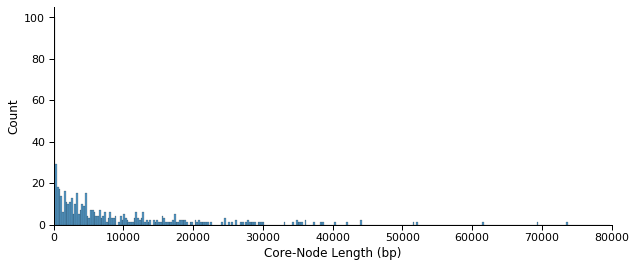

In [129]:
plt.figure(figsize =(10,4) ) 
sns.set_context("paper", font_scale=1.25)

sns.histplot(MG_CoreNodes_All_DF["SeqLength"].values, bins = np.arange(0, 80000, 250) ) 
sns.despine()

plt.xlim(0, 80000)
plt.xlabel("Core-Node Length (bp)")

plt.show()

# 3) Summary stats for SV nodes of graph


In [130]:
MG_SVNodes_PASS_DF.shape

(2025, 9)

In [131]:
#MG_SVNodes_PASS_DF.head(3)

### Investigate length of SV-NODEs within the graph

In [132]:
MG_SVNodes_PASS_DF["SeqLength"].describe()

count     2025.000000
mean       630.395062
std       1476.309335
min         31.000000
25%         71.000000
50%        174.000000
75%        932.000000
max      37214.000000
Name: SeqLength, dtype: float64

# 4) compare NODE length distribution - CORE vs SV 

In [133]:
MG_NodeAnalysis_DF.query("SeqLength >= 31").groupby("IsSVNode")["SeqLength"].describe()

,count,mean,std,min,25%,50%,75%,max
IsSVNode,,,,,,,,
False,486.0,8050.372428,10524.866086,32.0,1180.25,4091.0,10962.75,73572.0
True,2025.0,630.395062,1476.309335,31.0,71.00,174.0,932.00,37214.0


In [134]:
MG_NodeAnalysis_DF.groupby("IsSVNode")["SeqLength"].describe()

,count,mean,std,min,25%,50%,75%,max
IsSVNode,,,,,,,,
False,536.0,7300.634328,10290.486267,1.0,608.5,3332.0,9856.75,73572.0
True,2602.0,493.167948,1327.452839,1.0,37.0,96.0,478.00,37214.0


In [135]:
MG_NodeAnalysis_DF.groupby("IsSVNode")["SeqLength"].sum()

IsSVNode
False    3913140
True     1283223
Name: SeqLength, dtype: int64

## Let's compare the length distr between CORE & SV nodes

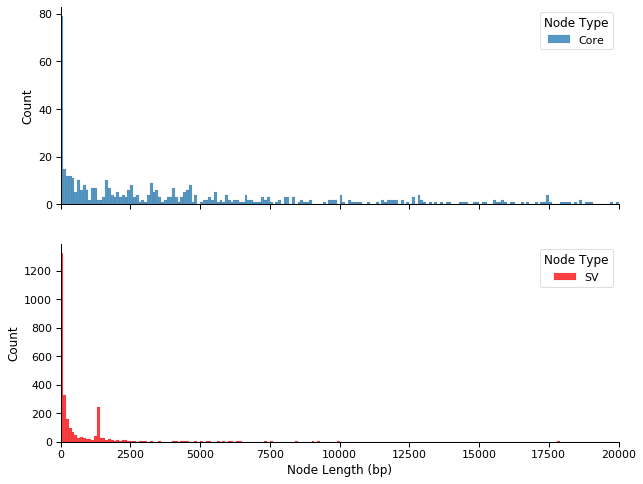

In [136]:
fig, axs = plt.subplots(2, 1, figsize =(10,8), sharex = True) 

sns.set_context("paper", font_scale=1.25)

sns.histplot(MG_CoreNodes_All_DF["SeqLength"].values, bins = np.arange(0, 80000, 100), label = "Core", ax = axs[0] ) 
sns.histplot(MG_SVNodes_All_DF["SeqLength"].values, bins = np.arange(0, 80000, 100), label = "SV", ax = axs[1], color = "red") 

sns.despine()
plt.legend()
axs[0].legend(title="Node Type")
axs[1].legend(title="Node Type")

axs[1].set_xlim(0, 20000)
axs[1].set_xlabel("Node Length (bp)")

plt.show()

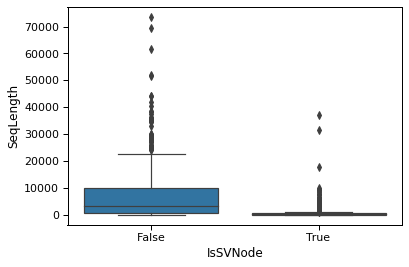

In [137]:
#sns.stripplot(y = "SeqLength", x = "IsSVNode",
#              data= MG_NodeAnalysis_DF)

sns.boxplot(y = "SeqLength", x = "IsSVNode",
            data= MG_NodeAnalysis_DF)
plt.show()

# 5) Look at # of SV nodes per SV bubble


In [138]:
#MG_SV_BED_DF["NumSVNodes"].describe()

In [139]:
MG_SV_BED_DF.groupby("Chr")["NumSVNodes"].describe()

,count,mean,std,min,25%,50%,75%,max
Chr,,,,,,,,
NC_000962.3,535.0,4.971963,15.103549,0.0,1.0,1.0,3.5,224.0


In [140]:
MG_SV_BED_DF.head(1)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",*,*,[],s1,s2,1,BubbleRegion_1,0,,


In [141]:
MG_SV_BED_DF.query("NumSVNodes == 0").shape

(3, 16)

In [142]:
MG_SV_BED_DF.query("NumSVNodes == 1").shape

(306, 16)

In [143]:
MG_SV_BED_DF.query("NumSVNodes >= 4").shape

(134, 16)

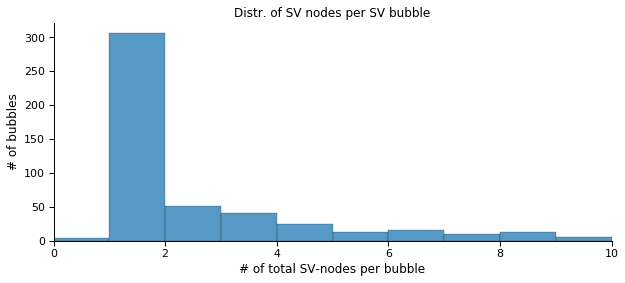

In [144]:
plt.figure(figsize =(10,4) ) 
sns.set_context("paper", font_scale=1.25)

sns.histplot(MG_SV_BED_DF["NumSVNodes"].values, bins = np.arange(0, 250, 1) ) 
sns.despine()

plt.title("Distr. of SV nodes per SV bubble")
plt.ylabel("# of bubbles")
plt.xlabel("# of total SV-nodes per bubble")
plt.xlim(0,10)
plt.show()

In [145]:
MG_SV_BED_DF["NumSVNodes"].describe()

count    535.000000
mean       4.971963
std       15.103549
min        0.000000
25%        1.000000
50%        1.000000
75%        3.500000
max      224.000000
Name: NumSVNodes, dtype: float64

## Plot FIGs for SV node length and # of SV Nodes per bubble region

In [146]:
!mkdir Results2_Plots/

mkdir: cannot create directory ‘Results2_Plots/’: File exists


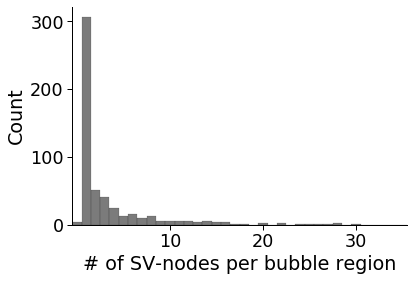

In [147]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SV_BED_DF["NumSVNodes"].values, bins = np.arange(0, 250, 1), color = '#4F4F4F' ) 
sns.despine()

#plt.title("Distr. of SV nodes per SV bubble")
plt.ylabel("Count")
plt.xlabel("# of SV-nodes per bubble region")
plt.xlim(0,36)


# Get current x-axis tick locations
current_ticks = plt.xticks()[0]

# Shift ticks by half a count to the right
shifted_ticks = current_ticks + 0.5

# Set new ticks
plt.xticks([10.5, 20.5, 30.5], [10, 20, 30] )

plt.savefig("Results2_Plots/2.B.SVNodesPerBubble.Histo.png", dpi = 300)
plt.savefig("Results2_Plots/2.B.SVNodesPerBubble.Histo.svg")

plt.show()

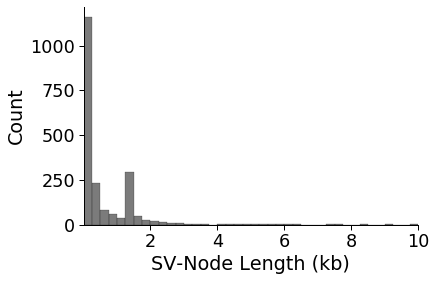

In [148]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SVNodes_PASS_DF["SeqLength"].values, bins = np.arange(0, 40000, 250), color = '#4F4F4F' )  
sns.despine()

plt.xlim(0, 10000)
plt.xlabel("SV-Node Length (kb)")


x_tick_loc = [2000, 4000, 6000, 8000, 10000]
#x_tick_label = ["2 kb", "4 kb", "6 kb", "8 kb", "10 kb"]
x_tick_label = [2, 4, 6, 8, 10]

#x_tick_loc = np.arange(0, 11000, 1000)
#x_tick_label = np.arange(0, 11, 1)


plt.xticks(x_tick_loc, x_tick_label )

plt.savefig("Results2_Plots/2.C.SVNodeLen.Histo.png", dpi = 300)
plt.savefig("Results2_Plots/2.C.SVNodeLen.Histo.svg")

plt.show()

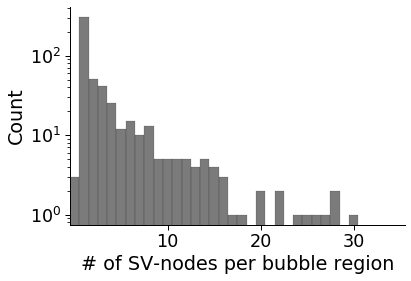

In [149]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SV_BED_DF["NumSVNodes"].values, bins = np.arange(0, 250, 1), color = '#4F4F4F' ) 
sns.despine()

#plt.title("Distr. of SV nodes per SV bubble")
plt.ylabel("Count")
plt.xlabel("# of SV-nodes per bubble region")
plt.xlim(0,36)

plt.yscale('log')

# Get current x-axis tick locations
current_ticks = plt.xticks()[0]

# Shift ticks by half a count to the right
shifted_ticks = current_ticks + 0.5

# Set new ticks
plt.xticks([10.5, 20.5, 30.5], [10, 20, 30] )

plt.show()

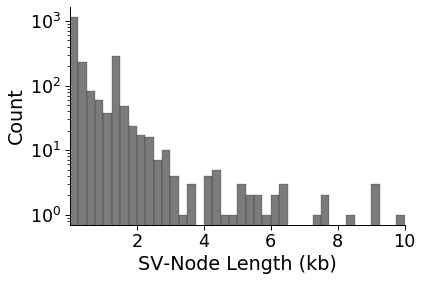

In [150]:
plt.figure(figsize =(6,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SVNodes_PASS_DF["SeqLength"].values, bins = np.arange(0, 40000, 250), color = '#4F4F4F' )  
sns.despine()

plt.xlim(0, 10000)
plt.xlabel("SV-Node Length (kb)")

plt.yscale('log')


x_tick_loc = [2000, 4000, 6000, 8000, 10000]
#x_tick_label = ["2 kb", "4 kb", "6 kb", "8 kb", "10 kb"]
x_tick_label = [2, 4, 6, 8, 10]

#x_tick_loc = np.arange(0, 11000, 1000)
#x_tick_label = np.arange(0, 11, 1)

plt.xticks(x_tick_loc, x_tick_label )

plt.show()

In [151]:
MG_SV_BED_DF.query("NumSVNodes == 0")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",*,*,[],s1,s2,1,BubbleRegion_1,0,,
261,NC_000962.3,2262956,2262956,0,0,"s829,s830",*,*,[],s829,s830,262,BubbleRegion_262,0,Rv2015c,Rv2015c
416,NC_000962.3,3555250,3555250,0,0,"s1293,s1294",*,*,[],s1293,s1294,417,BubbleRegion_417,0,Rv3189,Rv3189


In [152]:
MG_SV_BED_DF.head(5)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",*,*,[],s1,s2,1,BubbleRegion_1,0,,
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...",ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,,
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",*,TGAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAG...,[s2744],s5,s6,3,BubbleRegion_3,1,,
3,NC_000962.3,26469,28345,42,1876,"s6,s2247,s7,s8",TTCGGCGTAGCCCTCCAGCACGTCGGTATCGCTGTGGCGGTC,CCTGAGCCACCAACACATCGGCGCCGACCTGCAGGGCTCGCTCGGC...,"[s2247, s7]",s6,s8,4,BubbleRegion_4,2,"Rv0021c,whiB5,Rv0023","Rv0021c,Rv0022c,Rv0023"
4,NC_000962.3,28887,28887,0,87,"s8,s2823,s9",*,CCGCGCTGGTGGCGCACGGCCCGGGGGTCGCGCTGGCCAAACTTCG...,[s2823],s8,s9,5,BubbleRegion_5,1,Rv0024,Rv0024


## Pull out Bubble Region Examples for Main Figure (#2)

In [153]:
MG_SV_BED_DF.query("NumSVNodes == 1").head(15).tail(8)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
12,NC_000962.3,93036,93156,0,120,"s25,s26,s27",*,CACTGCTGGCGAATCTGTTCCTGCCGTGGGGGATCGCCGGCGCCGC...,[s26],s25,s27,13,BubbleRegion_13,1,hycD,Rv0084
13,NC_000962.3,103789,103789,0,9248,"s27,s2603,s28",*,GGACTGCTGAAGAACATTCCACGCCAGGAGATCAACCATGACCACC...,[s2603],s27,s28,14,BubbleRegion_14,1,Rv0094c,Rv0094c
14,NC_000962.3,131951,132032,0,81,"s28,s29,s30",*,GGCGGCGCCGGTGGGCTGCTGTTCGGCAACGGCGGGCCCGGCGGGG...,[s29],s28,s30,15,BubbleRegion_15,1,PE_PGRS1,Rv0109
15,NC_000962.3,137515,138447,0,932,"s30,s31,s32",*,GCTAACGGGTCACCTGATCTTTGATCGGCCACCGCTTGGCGCCGAG...,[s31],s30,s32,16,BubbleRegion_16,1,"gmhA,gmhB","Rv0113,Rv0114"
19,NC_000962.3,189429,189429,0,186,"s51,s2793,s52",*,CCAGAGTCCGGGACGGTGGCACCCCGCAGCTGCGGCTGGAACAGGT...,[s2793],s51,s52,20,BubbleRegion_20,1,PE4,Rv0160c
20,NC_000962.3,206846,206903,0,57,"s52,s53,s54",*,GGAGCCGACCAGACTGGCCCGCAGGTGAAGGCGGCGGATTCGGCGG...,[s53],s52,s54,21,BubbleRegion_21,1,Rv0175,Rv0175
22,NC_000962.3,226388,226388,0,317,"s56,s2825,s57",*,GGCCCGGCGGCGGGCGCTTACCGCTGGATCGTCGCATTGGGCTTCG...,[s2825],s56,s57,23,BubbleRegion_23,1,Rv0193c,Rv0193c
24,NC_000962.3,279515,279590,0,75,"s60,s61,s62",*,CGGCCTCGGCCTAGGCCTGGCGAGCAGACGCAAAATCGCCCAATTT...,[s61],s60,s62,25,BubbleRegion_25,1,nrdB,Rv0233


In [154]:
MG_SV_BED_DF["NumSVNodes"].describe()

count    535.000000
mean       4.971963
std       15.103549
min        0.000000
25%        1.000000
50%        1.000000
75%        3.500000
max      224.000000
Name: NumSVNodes, dtype: float64

In [155]:
MG_SV_BED_DF.sort_values("NumSVNodes", ascending=False).head(6)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
361,NC_000962.3,3114093,3157869,37251,56073,"s1071,s2924,s1072,s3059,s1073,s2967,s2237,s223...",CCGACACTGTGGCGCACTGCGGCCCGAGTCTAATCGGCGAGTTCGC...,CCGACACTGTGGCGCACTGCGGCCCGAGTCTAATCGGCGAGTTCGC...,"[s2924, s1072, s3059, s1073, s2967, s2237, s22...",s1071,s1159,362,BubbleRegion_362,224,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...","Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2..."
244,NC_000962.3,2163345,2168184,119,22106,"s753,s754,s1999,s2573,s2763,s2764,s2765,s2765,...",CGGGCTCGTGCCCCCGCTCAACGGAACATTCAACCCAAACGGATTA...,CGGGCTCGTGCCCCCGCTCAACGGAACATTCAACCCAAACGGATTA...,"[s754, s1999, s2573, s2763, s2764, s2765, s276...",s753,s787,245,BubbleRegion_245,130,"PPE34,PPE35","Rv1917c,Rv1918c"
220,NC_000962.3,1986625,1999613,1368,29276,"s650,s2317,s2318,s2318,s2319,s2320,s651,s2231,...",CATCTCCGACCTGTGAACCGCCCCGGTGAGTCCGGAGACTCTCTGA...,TGAACCGCCCCGGTGAGTCCGGAGACTCCAGTTCTTGGAAAGGATG...,"[s2317, s2318, s2318, s2319, s2320, s651, s223...",s650,s701,221,BubbleRegion_221,116,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...","Rv1754c,Rv1755c,Rv1756c,Rv1757c,Rv1758,Rv1759c..."
485,NC_000962.3,3945117,3950849,0,9190,"s1596,s1597,s1598,s2593,s1599,s2070,s1600,s160...",*,CATGCACGTCATCGGCTGGCCGCGCCTCGGTCTGCTCCTTGGCCCA...,"[s1597, s1598, s2593, s1599, s2070, s1600, s16...",s1596,s1645,486,BubbleRegion_486,115,"fadD18,PE_PGRS57,fadD19","Rv3513c,Rv3514,Rv3515c"
308,NC_000962.3,2627049,2639487,3507,30484,"s939,s2720,s940,s2462,s941,s2966,s942,s943,s30...",GAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAGC...,CAGCATCGTATGACAATCCGCGGACAATATCCCGGGTTTTCTAATT...,"[s2720, s940, s2462, s941, s2966, s942, s943, ...",s939,s970,309,BubbleRegion_309,88,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40","Rv2349c,Rv2350c,Rv2351c,Rv2352c,Rv2353c,Rv2354..."
432,NC_000962.3,3738365,3757725,1465,21955,"s1343,s1344,s1345,s3067,s1346,s1347,s2729,s134...",GGCCGCCGGACTGGCCTGTGCTCAGGCTGCCCCCGCCAGCACCGGC...,TGCCGGCCGAGCCAGCGCCGCCGTTGCCACCGGCACCACCGCTGCC...,"[s1344, s1345, s3067, s1346, s1347, s2729, s13...",s1343,s1398,433,BubbleRegion_433,74,"PE_PGRS49,PE_PGRS50,Rv3346c,PPE55,Rv3348,Rv334...","Rv3344c,Rv3345c,Rv3346c,Rv3347c,Rv3348,Rv3349c..."


In [156]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_20'")  

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
19,NC_000962.3,189429,189429,0,186,"s51,s2793,s52",*,CCAGAGTCCGGGACGGTGGCACCCCGCAGCTGCGGCTGGAACAGGT...,[s2793],s51,s52,20,BubbleRegion_20,1,PE4,Rv0160c


In [157]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_309'")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
308,NC_000962.3,2627049,2639487,3507,30484,"s939,s2720,s940,s2462,s941,s2966,s942,s943,s30...",GAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAGC...,CAGCATCGTATGACAATCCGCGGACAATATCCCGGGTTTTCTAATT...,"[s2720, s940, s2462, s941, s2966, s942, s943, ...",s939,s970,309,BubbleRegion_309,88,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40","Rv2349c,Rv2350c,Rv2351c,Rv2352c,Rv2353c,Rv2354..."


In [158]:
MG_SV_BED_DF[MG_SV_BED_DF["Overlap_Genes"].str.contains("PPE40")]

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
308,NC_000962.3,2627049,2639487,3507,30484,"s939,s2720,s940,s2462,s941,s2966,s942,s943,s30...",GAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAGC...,CAGCATCGTATGACAATCCGCGGACAATATCCCGGGTTTTCTAATT...,"[s2720, s940, s2462, s941, s2966, s942, s943, ...",s939,s970,309,BubbleRegion_309,88,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40","Rv2349c,Rv2350c,Rv2351c,Rv2352c,Rv2353c,Rv2354..."


# 6) What regions contain truly novel content within the graph? (vs all other nodes)

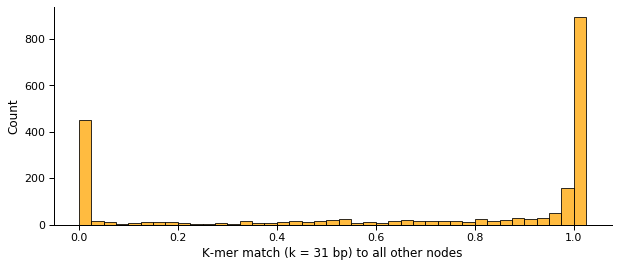

In [159]:
plt.figure( figsize= (10,4) )

#sns.set_context("talk")
sns.set_context("paper", font_scale=1.25)

sns.histplot(MG_SVNodes_PASS_DF["MaxJC_ToAnyOtherNode"].values, bins = np.arange(0, 1.05, 0.025), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to all other nodes")

plt.show()


In [160]:
MG_SVNodes_UnqSeq_DF =  MG_SVNodes_PASS_DF.query("MaxJC_ToAnyOtherNode < 0.05")
MG_SVNodes_UnqSeq_DF.shape

(463, 9)

In [161]:
MG_SVNodes_NoUnqSeq_DF =  MG_SVNodes_PASS_DF.query("MaxJC_ToAnyOtherNode >= 0.05")
MG_SVNodes_NoUnqSeq_DF.shape

(1562, 9)

In [162]:
1562 + 463

2025

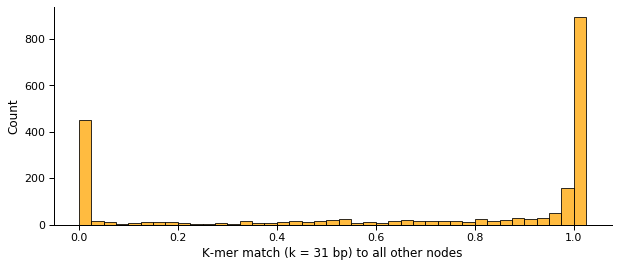

In [163]:
plt.figure( figsize= (10,4) )

#sns.set_context("talk")
sns.set_context("paper", font_scale=1.25)

sns.histplot(MG_SVNodes_PASS_DF["Jaccard_Cont_WiAllOtherNodes"].values, bins = np.arange(0, 1.05, 0.025), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to all other nodes")

plt.show()


In [164]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.05").shape

(463, 9)

In [165]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiAllOtherNodes == 0").shape

(410, 9)

In [166]:
MG_SVNodes_PASS_DF.shape

(2025, 9)

In [167]:
MG_SVNodes_UnqSeq_DF =  MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.05")
MG_SVNodes_UnqSeq_DF.shape

(463, 9)

In [168]:
MG_SVNodes_NoUnqSeq_DF =  MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiAllOtherNodes >= 0.05")
MG_SVNodes_NoUnqSeq_DF.shape

(1562, 9)

In [169]:
460 + 1565

2025

In [170]:
MG_SVNodes_TooSmall_DF.head(2)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
3,s4,5,0.0,0.0,0.0,True,BubbleRegion_2,0.0,0.0
11,s12,7,0.0,0.0,0.0,True,BubbleRegion_8,0.0,0.0


### How many unique Bubble regions are these unique sequence SV nodes distributed across?

In [171]:
256/535

0.4785046728971963

In [172]:
MG_SVNodes_UnqSeq_DF["BubbleID"].nunique()

253

#### How many unique bubble regions for NODEs w/ Len > 1 kb?

In [173]:
MG_SVNodes_UnqSeq_DF.query("SeqLength >= 1000")["BubbleID"].nunique()

71

#### How many unique bubble regions for NODEs w/ Len > 2 kb?

In [174]:
MG_SVNodes_UnqSeq_DF.query("SeqLength >= 2000")["BubbleID"].nunique()

36

### IDEA: Let's take these "bubble regions" of interest, and then label by i) gene names & ii) mycobrowser gene category

- What proportion of SV bubbles with NOT unique and VERY UNIQUE sequence content overlap with which gene categories?


In [175]:
MG_SVNodes_UnqSeq_DF["BubbleID"].nunique()

253

### Analyze SV-Node length for Low JC to AllOtherNodes

### What is the cumulative length of all SV-nodes w/ novel sequence?

In [176]:
MG_SVNodes_UnqSeq_DF["SeqLength"].sum()

301511

### What does the sequence length distribution look like?

In [177]:
MG_SVNodes_UnqSeq_DF["SeqLength"].describe()

count     463.000000
mean      651.211663
std      1014.360679
min        31.000000
25%        80.000000
50%       214.000000
75%       823.500000
max      7546.000000
Name: SeqLength, dtype: float64

In [178]:
MG_SVNodes_UnqSeq_DF.groupby("IsSVNode")["SeqLength"].describe()

,count,mean,std,min,25%,50%,75%,max
IsSVNode,,,,,,,,
True,463.0,651.211663,1014.360679,31.0,80.0,214.0,823.5,7546.0


## The median length of unique sequence SV nodes was 236 bp (IQR: 81 - 843 bp). 

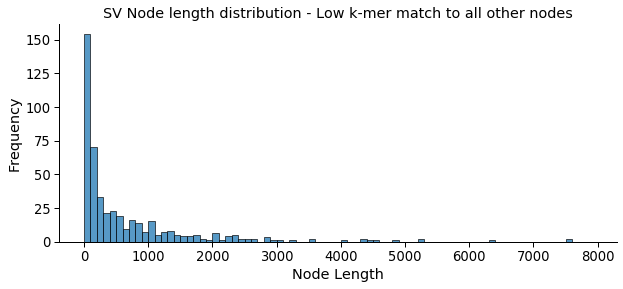

In [179]:
#sns.set_context("talk")
sns.set_context("paper", font_scale=1.5)

plt.figure( figsize= (10,4) )
sns.histplot(MG_SVNodes_UnqSeq_DF["SeqLength"].values, bins = np.arange(0, 8000, 100) ) 
sns.despine()

plt.title("SV Node length distribution - Low k-mer match to all other nodes")
plt.ylabel("Frequency")
plt.xlabel("Node Length")

plt.show()

In [180]:
MG_SVNodes_UnqSeq_DF.head(1)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
6,s7,1876,1.0,0.0,0.0,True,BubbleRegion_4,0.006501,0.006501


In [181]:
#MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_366' ")

In [182]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_196' ")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
195,NC_000962.3,1808139,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,110;AC=151,1;VS=>s582;VE=>s...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2806","[*, >s2806]",BubbleRegion_196,s582,s583,[s2806],1


In [183]:
#MG_SVNodes_UnqSeq_DF.groupby("BubbleID").count()

# 7. What is the overlap of k-mer content w/ MGEs + annotated transposons?
- What proportion of SV nodes contain MGE content?
- How much of SVs within the graph are explained by movement of IS6110 elements.


In [184]:
MG_SVNodes_PASS_DF.head(4)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
2,s3,56,1.0,0.0,0.0,True,BubbleRegion_2,0.961538,0.961538
6,s7,1876,1.0,0.0,0.0,True,BubbleRegion_4,0.006501,0.006501
15,s16,904,1.0,0.0,0.0,True,BubbleRegion_11,0.000000,0.000000
17,s18,732,1.0,0.0,0.0,True,BubbleRegion_12,0.000000,0.000000


In [185]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.5").shape

(346, 9)

In [186]:
MG_SVNodes_PASS_DF.groupby("IsSVNode")["Jaccard_Cont_WiRv_InsSeqAndPhages"].describe()

,count,mean,std,min,25%,50%,75%,max
IsSVNode,,,,,,,,
True,2025.0,0.154644,0.338135,0.0,0.0,0.0,0.0,1.0


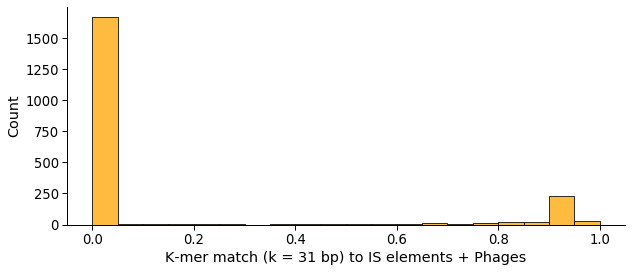

In [187]:
plt.figure( figsize= (10,4) )

#sns.set_context("talk")
sns.set_context("paper", font_scale=1.5)

sns.histplot(MG_SVNodes_PASS_DF["Jaccard_Cont_WiRv_InsSeqAndPhages"].values, bins = np.arange(0, 1.05, 0.05), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to IS elements + Phages")

plt.show()


In [188]:
MG_SVNodes_PASS_MGE_DF = MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.5")
MG_SVNodes_PASS_MGE_DF.shape

(346, 9)

In [189]:
MG_SVNodes_PASS_MGE_DF.groupby("IsSVNode")["Jaccard_Cont_WiRv_InsSeqAndPhages"].describe()

,count,mean,std,min,25%,50%,75%,max
IsSVNode,,,,,,,,
True,346.0,0.892381,0.087957,0.518868,0.904367,0.927711,0.929811,1.0


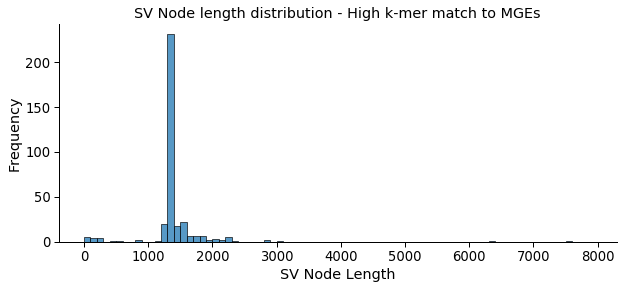

In [190]:
#sns.set_context("talk")
sns.set_context("paper", font_scale=1.5)

plt.figure( figsize= (10,4) )
sns.histplot(MG_SVNodes_PASS_MGE_DF["SeqLength"].values, bins = np.arange(0, 8000, 100) ) 
sns.despine()

plt.title("SV Node length distribution - High k-mer match to MGEs")
plt.ylabel("Frequency")
plt.xlabel("SV Node Length")

plt.show()

In [191]:
#MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.05")["SeqLength"].sum() 

In [192]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.5").shape

(346, 9)

In [193]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.5")["SeqLength"].sum()

503748

In [194]:
MG_SVNodes_PASS_DF["SeqLength"].sum()  


1276550

In [195]:
493708 / 1295062

0.38122344721719886

In [196]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.8")["SeqLength"].sum()  


431688

In [197]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 >= 0.5")["SeqLength"].sum()  

455214

In [198]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages >= 0.5")["SeqLength"].sum()

503748

In [199]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages >= 0.05")["SeqLength"].sum()  

547530

## IS6110 specific analysis

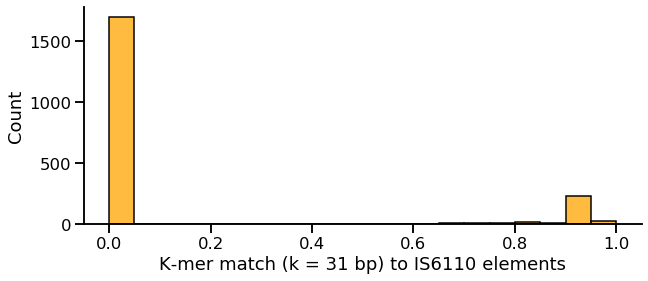

In [200]:
plt.figure( figsize= (10,4) )

sns.set_context("talk")

sns.histplot(MG_SVNodes_PASS_DF["Jaccard_Cont_WiIS6110"].values, bins = np.arange(0, 1.05, 0.05), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to IS6110 elements")
plt.show()


In [201]:
MG_SVNodes_PASS_IS6110_DF = MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.5")
MG_SVNodes_PASS_IS6110_DF.shape

(322, 9)

In [202]:
MG_SVNodes_PASS_IS6110_DF.groupby("IsSVNode")["Jaccard_Cont_WiIS6110"].describe()

,count,mean,std,min,25%,50%,75%,max
IsSVNode,,,,,,,,
True,322.0,0.894555,0.083388,0.518868,0.906556,0.927711,0.929811,1.0


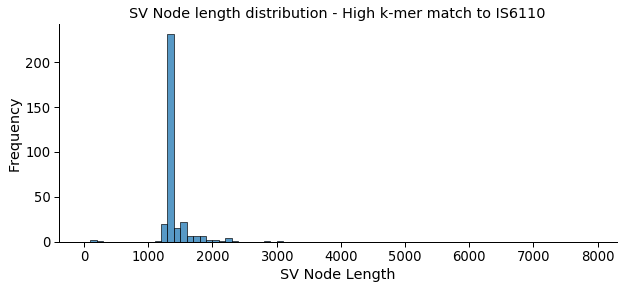

In [203]:
#sns.set_context("talk")
sns.set_context("paper", font_scale=1.5)

plt.figure( figsize= (10,4) )
sns.histplot(MG_SVNodes_PASS_IS6110_DF["SeqLength"].values, bins = np.arange(0, 8000, 100) ) 
sns.despine()

plt.title("SV Node length distribution - High k-mer match to IS6110")
plt.ylabel("Frequency")
plt.xlabel("SV Node Length")

plt.show()

In [204]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.5")["SeqLength"].sum()  

455214

In [205]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.9").shape

(251, 9)

In [206]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.8").shape

(284, 9)

In [207]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.5").shape

(322, 9)

In [208]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.2").shape

(326, 9)

In [209]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.1").shape

(327, 9)

In [210]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.1 & Jaccard_Cont_WiIS6110 <= 0.5")

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
2461,s2462,2660,0.665019,0.468441,0.468441,True,BubbleRegion_309,0.653992,0.653992
2483,s2484,4040,0.968343,0.458845,0.458845,True,BubbleRegion_255,0.495345,0.495345
2653,s2654,2909,0.989927,0.427926,0.427926,True,BubbleRegion_190,0.529350,0.529350
2830,s2831,5827,0.957093,0.288863,0.288863,True,BubbleRegion_362,0.870106,0.870106
3097,s3098,9993,0.992126,0.142659,0.142659,True,BubbleRegion_245,0.341246,0.341246


In [211]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.5").shape

(322, 9)

In [212]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.05")["SeqLength"].sum()  


480643

In [213]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.75")["SeqLength"].sum()  


407847

In [214]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.5")["SeqLength"].sum()  


455214

In [215]:
445100 / 1295062

0.3436901090449724

In [216]:
MG_SVNodes_PASS_DF["SeqLength"].sum()  

1276550

In [217]:
MG_SVNodes_All_DF["SeqLength"].sum()  

1283223

# 8) k-mer comparison to H37Rv, the most common Mtb reference genome


In [218]:
MG_SVNodes_PASS_DF.shape

(2025, 9)

In [219]:
MG_SVNodes_PASS_DF["Jaccard_Cont_WiRv"].describe()

count    2025.000000
mean        0.878432
std         0.298538
min         0.000000
25%         0.998494
50%         1.000000
75%         1.000000
max         1.000000
Name: Jaccard_Cont_WiRv, dtype: float64

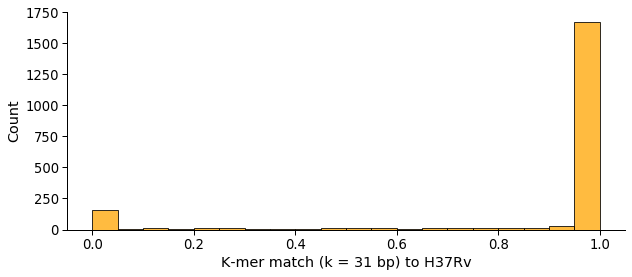

In [220]:

#sns.set_context("talk")
sns.set_context("paper", font_scale=1.5)

plt.figure( figsize= (10,4) )

sns.histplot(MG_SVNodes_PASS_DF["Jaccard_Cont_WiRv"].values, bins = np.arange(0, 1.05, 0.05), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to H37Rv")
plt.show()


In [221]:
MG_SVNodes_PASS_DF.head(1)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
2,s3,56,1.0,0.0,0.0,True,BubbleRegion_2,0.961538,0.961538


In [222]:
MG_SVNodes_UnqSeqToRv_DF = MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05")
MG_SVNodes_UnqSeqToRv_DF.shape

(160, 9)

### What is the cumulative length of all SV-nodes w/ novel sequence?

In [223]:
MG_SVNodes_UnqSeqToRv_DF["SeqLength"].sum()

66621

### What does the sequence length distribution look like?

In [224]:
MG_SVNodes_UnqSeqToRv_DF["SeqLength"].describe()

count     160.00000
mean      416.38125
std       691.52422
min        31.00000
25%        68.00000
50%       125.50000
75%       528.50000
max      4518.00000
Name: SeqLength, dtype: float64

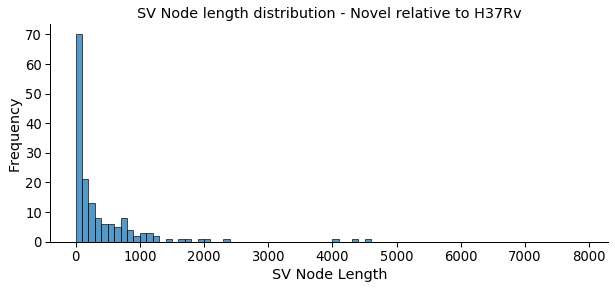

In [225]:
#sns.set_context("talk")
sns.set_context("paper", font_scale=1.5)

plt.figure( figsize= (10,4) )
sns.histplot(MG_SVNodes_UnqSeqToRv_DF["SeqLength"].values, bins = np.arange(0, 8000, 100) ) 
sns.despine()

plt.title("SV Node length distribution - Novel relative to H37Rv")
plt.ylabel("Frequency")
plt.xlabel("SV Node Length")

plt.show()

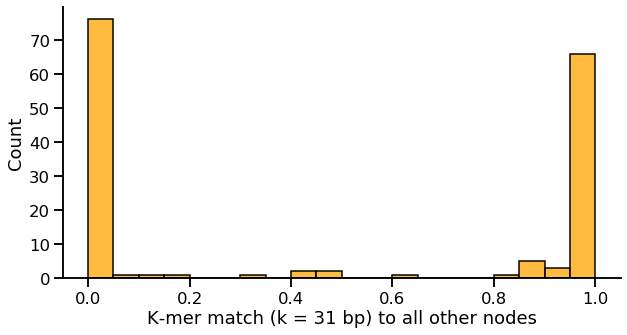

In [226]:
plt.figure( figsize= (10,5) )

sns.set_context("talk")

sns.histplot(MG_SVNodes_UnqSeqToRv_DF["Jaccard_Cont_WiAllOtherNodes"].values, bins = np.arange(0, 1.05, 0.05), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to all other nodes")
plt.show()


In [227]:
MG_SVNodes_UnqSeqToRv_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.5")["SeqLength"].sum()

55316

In [228]:
MG_SVNodes_UnqSeqToRv_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.05")["SeqLength"].sum()

51806

In [229]:
MG_SVNodes_UnqSeqToRv_DF["SeqLength"].sum()

66621

In [230]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 & Jaccard_Cont_WiAllOtherNodes < 0.05")["SeqLength"].sum()

51806

In [231]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 & Jaccard_Cont_WiAllOtherNodes < 0.05").shape

(76, 9)

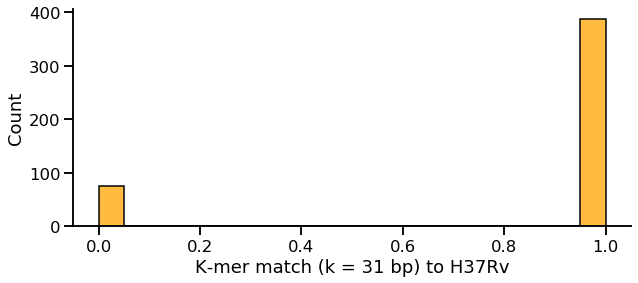

In [232]:
plt.figure( figsize= (10,4) )

sns.set_context("talk")

sns.histplot(MG_SVNodes_UnqSeq_DF["Jaccard_Cont_WiRv"].values, bins = np.arange(0, 1.05, 0.05), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to H37Rv")
plt.show()


In [233]:
46882 / 1295062

0.03620058344697011

In [234]:
MG_SVNodes_PASS_DF["SeqLength"].sum()

1276550

## Exploring - Example 1 - Largest UNQ to Rv

In [235]:
MG_SVNodes_UnqSeqToRv_DF.query("SeqLength > 5000")

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes


In [236]:
AvA_Nodes_Trim_DF.query("RecordID_1 == 's1814' ")

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,JaccardSim,JaccardContain
9557,s1814,s637,281,96,0.880000,0.880000
9558,s1814,s638,281,54,0.320000,0.320000
9559,s1814,s1811,281,55,0.333333,0.333333
9560,s1814,s1812,281,61,0.413333,0.413333
9561,s1814,s1813,281,49,0.253333,0.253333
9562,s1814,s2254,281,54,0.320000,0.320000
9563,s1814,s2295,281,74,0.586667,0.586667
9564,s1814,s2899,281,343,0.158730,0.666667


In [237]:
MG_SVNodes_UnqSeqToRv_DF.query("SeqLength > 5000")

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes


In [238]:
AvA_Nodes_Trim_DF.query("RecordID_1 == 's1814' ")["RecordID_2"].values

array(['s637', 's638', 's1811', 's1812', 's1813', 's2254', 's2295',
       's2899'], dtype=object)

In [239]:
MG_SVNodes_PASS_DF[MG_SVNodes_PASS_DF["NodeID"].isin(['s2264', 's2396', 's2528'])]

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
2395,s2396,289,1.0,0.0,0.0,True,BubbleRegion_190,1.0,1.0
2527,s2528,96,1.0,0.0,0.0,True,BubbleRegion_31,1.0,1.0


In [240]:
AvA_Nodes_Trim_DF.head(1)

,RecordID_1,RecordID_2,Record1_Len,Record2_Len,JaccardSim,JaccardContain
0,s3,s2959,56,61,0.78125,0.961538


In [241]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_224' ")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
223,NC_000962.3,2010923,2010923,0,1358,"s704,s2321,s705",*,CTGAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCA...,[s2321],s704,s705,224,BubbleRegion_224,1,cyp144,Rv1777


In [242]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_224'")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
223,NC_000962.3,2010923,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,1358;AC=150,2;VS=>s704;VE=>...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2321","[*, >s2321]",BubbleRegion_224,s704,s705,[s2321],1


In [243]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_4'")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
3,NC_000962.3,26469,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=1876,42;AC=151,1;VS=>s6;VE=>s...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,">s7,>s2247","[>s7, >s2247]",BubbleRegion_4,s6,s8,"[s2247, s7]",2


## Explore SV Nodes that are unique to BOTH ALL other nodes & H37Rv

In [244]:
MG_SVNodes_PASS_DF.head(1)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
2,s3,56,1.0,0.0,0.0,True,BubbleRegion_2,0.961538,0.961538


In [245]:
MG_SVNodes_UnqSeqToAllAndRv_DF =  MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.05 & Jaccard_Cont_WiRv < 0.05")
print("# of SV Nodes:", MG_SVNodes_UnqSeqToAllAndRv_DF.shape[0])
print("Cumulative Len of SV Nodes:", MG_SVNodes_UnqSeqToAllAndRv_DF["SeqLength"].sum())
print("# of unique Bubble Regions:", MG_SVNodes_UnqSeqToAllAndRv_DF["BubbleID"].nunique())


# of SV Nodes: 76
Cumulative Len of SV Nodes: 51806
# of unique Bubble Regions: 54


In [246]:
MG_SVNodes_UnqSeqToAllAndRv_DF["SeqLength"].sum()  

51806

In [247]:
MG_SVNodes_UnqSeqToAllAndRv_DF.head(5)  

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
1746,s1747,527,0.024145,0.0,0.0,True,BubbleRegion_31,0.006036,0.006036
1747,s1748,72,0.000000,0.0,0.0,True,BubbleRegion_31,0.000000,0.000000
1748,s1749,62,0.000000,0.0,0.0,True,BubbleRegion_31,0.000000,0.000000
1749,s1750,96,0.000000,0.0,0.0,True,BubbleRegion_31,0.000000,0.000000
1769,s1770,533,0.000000,0.0,0.0,True,BubbleRegion_82,0.000000,0.000000


In [248]:
i_Thresh = 0.5
DF =  MG_SVNodes_PASS_DF.query(f"Jaccard_Cont_WiAllOtherNodes < {i_Thresh} & Jaccard_Cont_WiRv < {i_Thresh}")

print("# of SV Nodes:", DF.shape[0])
print("Cumulative Len of SV Nodes:", DF["SeqLength"].sum())
print("# of unique Bubble Regions:", DF["BubbleID"].nunique())


# of SV Nodes: 110
Cumulative Len of SV Nodes: 70535
# of unique Bubble Regions: 69


In [249]:
i_Thresh = 0.1
DF =  MG_SVNodes_PASS_DF.query(f"Jaccard_Cont_WiAllOtherNodes < {i_Thresh}")

print("# of SV Nodes:", DF.shape[0])
print("Cumulative Len of SV Nodes:", DF["SeqLength"].sum())
print("# of unique Bubble Regions:", DF["BubbleID"].nunique())


# of SV Nodes: 477
Cumulative Len of SV Nodes: 309778
# of unique Bubble Regions: 255


# 9) Organize & output figures from all relevant parts of analysis

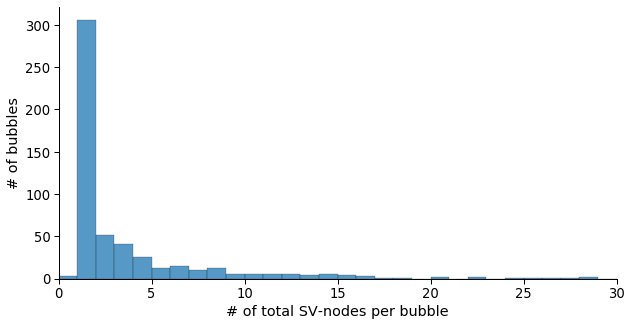

In [250]:
plt.figure(figsize =(10,5) ) 
sns.set_context("paper", font_scale = 1.5)

sns.histplot(MG_SV_BED_DF["NumSVNodes"].values, bins = np.arange(0, 250, 1) ) 
sns.despine()

#plt.title("Distr. of SV nodes per SV bubble")
plt.ylabel("# of bubbles")
plt.xlabel("# of total SV-nodes per bubble")
plt.xlim(0,30)

#plt.savefig("ThesisPlots/Chap2.Fig3.A.NumSVnode.Histo.png", dpi = 300)

plt.show()


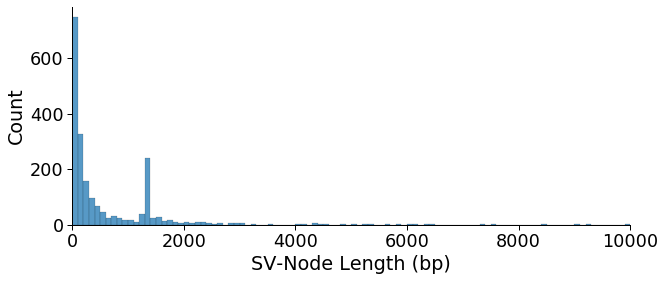

In [251]:
plt.figure(figsize =(10,4) ) 
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SVNodes_PASS_DF["SeqLength"].values, bins = np.arange(0, 40000, 100) ) 
sns.despine()

plt.xlim(0, 10000)
plt.xlabel("SV-Node Length (bp)")

#plt.savefig("ThesisPlots/Chap2.Fig4.A.SVNodeLen.Histo.png", dpi = 300)

plt.show()

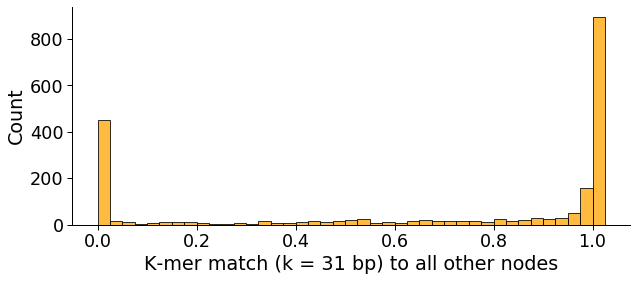

In [252]:
plt.figure( figsize= (10,4) )

#sns.set_context("talk")
sns.set_context("paper", font_scale=2)

sns.histplot(MG_SVNodes_PASS_DF["Jaccard_Cont_WiAllOtherNodes"].values, bins = np.arange(0, 1.05, 0.025), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to all other nodes")

#plt.savefig("ThesisPlots/Chap2.Fig4.B.KmerAll.Histo.png", dpi = 300)

plt.show()


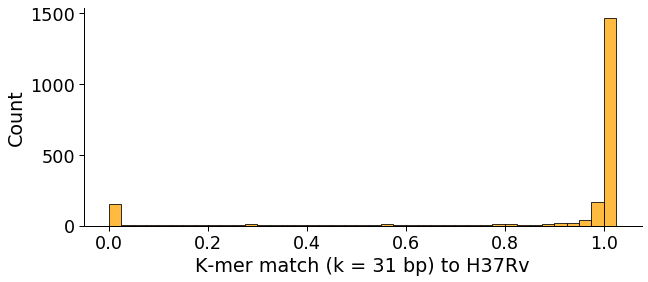

In [253]:

#sns.set_context("talk")
sns.set_context("paper", font_scale=2)

plt.figure( figsize= (10,4) )

sns.histplot(MG_SVNodes_PASS_DF["Jaccard_Cont_WiRv"].values, bins = np.arange(0, 1.05, 0.025), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to H37Rv")

#plt.savefig("ThesisPlots/Chap2.Fig4.D.KmerToRv.Histo.png", dpi = 300)


plt.show()


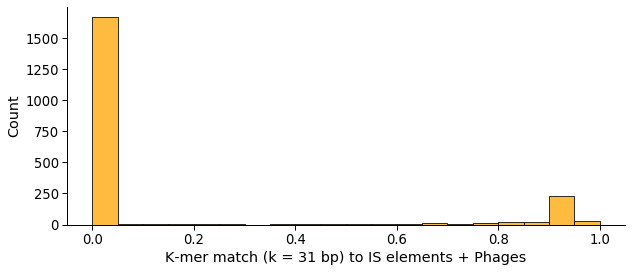

In [254]:
plt.figure( figsize= (10,4) )

#sns.set_context("talk")
sns.set_context("paper", font_scale=1.5)

sns.histplot(MG_SVNodes_PASS_DF["Jaccard_Cont_WiRv_InsSeqAndPhages"].values, bins = np.arange(0, 1.05, 0.05), color = "#FFA500") 
sns.despine()

plt.xlabel("K-mer match (k = 31 bp) to IS elements + Phages")
#plt.savefig("ThesisPlots/Chap2.SuppFig2.A.MGEs.KmerMatch.png", dpi = 300)

plt.show()


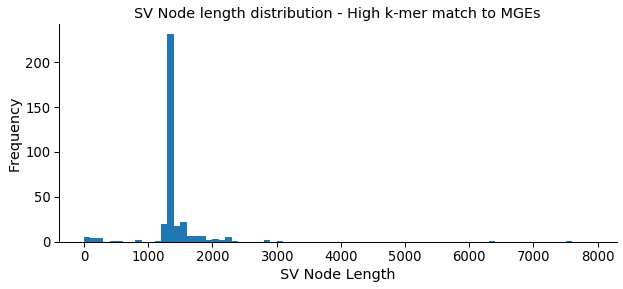

In [255]:
#sns.set_context("talk")
sns.set_context("paper", font_scale=1.5)

plt.figure( figsize= (10,4) )
plt.hist(MG_SVNodes_PASS_MGE_DF["SeqLength"].values, bins = np.arange(0, 8000, 100) ) 
sns.despine()

plt.title("SV Node length distribution - High k-mer match to MGEs")
plt.ylabel("Frequency")
plt.xlabel("SV Node Length")

#plt.savefig("ThesisPlots/Chap2.SuppFig2.B.MGEs.NodeLen.png", dpi = 300)

plt.show()

In [256]:
MG_CoreNodes_All_DF.head(1)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
0,s1,1533,1.0,0.0,0.0,False,None,0.0,0.0


## Summarize size and length of node sets

In [257]:
MG_SVNodes_PASS_ISandPhages_DF = MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv_InsSeqAndPhages > 0.5")
MG_SVNodes_PASS_ISandPhages_DF.shape

(346, 9)

In [258]:
MG_SVNodes_PASS_IS6110_V2_DF = MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiIS6110 > 0.5 & Jaccard_Cont_WiRv_InsSeqAndPhages > 0.5")
MG_SVNodes_PASS_IS6110_V2_DF.shape

(322, 9)

In [259]:
MG_SVNodes_UnqSeq_DF =  MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.05 & (SeqLength >= 31)")
MG_SVNodes_UnqSeq_DF.shape

(463, 9)

In [260]:
#MG_SVNodes_NoUnqSeq_DF =  MG_SVNodes_All_DF.query("(Jaccard_Cont_WiAllOtherNodes >= 0.05)")

In [261]:
print( MG_SVNodes_All_DF.query("(Jaccard_Cont_WiAllOtherNodes >= 0.05)").shape )
print( MG_SVNodes_All_DF.query("(Jaccard_Cont_WiAllOtherNodes >= 0.05)")["SeqLength"].sum() )

(1562, 9)
975039


In [262]:
MG_SVNodes_NoUnqSeq_DF =  MG_SVNodes_All_DF.query("(Jaccard_Cont_WiAllOtherNodes >= 0.05) | (SeqLength < 31)")
#MG_SVNodes_NoUnqSeq_DF =  MG_SVNodes_All_DF.query("(Jaccard_Cont_WiAllOtherNodes >= 0.05)")

MG_SVNodes_NoUnqSeq_DF.shape

(2139, 9)

In [263]:
460 + 2142

2602

In [264]:
print( MG_SVNodes_All_DF.query("(MaxJC_ToAnyOtherNode < 0.05) | (SeqLength < 31)").shape )
print( MG_SVNodes_All_DF.query("(MaxJC_ToAnyOtherNode < 0.05) | (SeqLength < 31)")["SeqLength"].sum() ) 

(1040, 9)
308184


In [265]:
print( MG_SVNodes_All_DF.query("(MaxJC_ToAnyOtherNode >= 0.05) | (SeqLength < 31)").shape )
print( MG_SVNodes_All_DF.query("(MaxJC_ToAnyOtherNode >= 0.05) | (SeqLength < 31)")["SeqLength"].sum() )

(2139, 9)
981712


In [266]:
# 981712 vs 982837 

In [267]:
982837 - 981712

1125

In [268]:
print( MG_SVNodes_All_DF.query("(Jaccard_Cont_WiAllOtherNodes >= 0.05) | (SeqLength < 31)").shape )
print( MG_SVNodes_All_DF.query("(Jaccard_Cont_WiAllOtherNodes >= 0.05) | (SeqLength < 31)")["SeqLength"].sum() )

(2139, 9)
981712


In [269]:
print( MG_SVNodes_All_DF.query("(MaxJC_ToAnyOtherNode >= 0.05) | (SeqLength < 31)").shape )
print( MG_SVNodes_All_DF.query("(MaxJC_ToAnyOtherNode >= 0.05) | (SeqLength < 31)")["SeqLength"].sum() )

(2139, 9)
981712


In [270]:
MG_SVNodes_PASS_ISandPhages_DF["SeqLength"].sum()

503748

In [271]:
MG_SVNodes_PASS_IS6110_V2_DF["SeqLength"].sum()

455214

In [272]:
MG_SVNodes_All_DF["BubbleID"].nunique()

532

In [273]:
MG_SVNodes_All_DF["SeqLength"].sum()

1283223

In [274]:
MG_SVNodes_All_DF.shape

(2602, 9)

#### Core Nodes - All

In [275]:
MG_CoreNodes_All_DF.shape

(536, 9)

In [276]:
MG_CoreNodes_All_DF["SeqLength"].sum()

3913140

#### SV Nodes - All

In [277]:
MG_SVNodes_All_DF.shape

(2602, 9)

In [278]:
MG_SVNodes_All_DF["SeqLength"].sum()

1283223

In [279]:
MG_SVNodes_All_DF["SeqLength"].sum() / 1000

1283.223

In [280]:
1283223 + 3913140

5196363

#### SV Nodes - Pass

In [281]:
MG_SVNodes_PASS_DF.shape

(2025, 9)

In [282]:
MG_SVNodes_PASS_DF["SeqLength"].sum() 

1276550

#### SV Nodes - Too Small (Len < 31bp)

In [283]:
MG_SVNodes_TooSmall_DF.shape

(577, 9)

In [284]:
MG_SVNodes_TooSmall_DF["SeqLength"].sum() 

6673

#### SV Nodes - Redundant Seq Content

In [285]:
MG_SVNodes_NoUnqSeq_DF.shape

(2139, 9)

In [286]:
MG_SVNodes_NoUnqSeq_DF["SeqLength"].sum() 

981712

In [287]:
982837 / 1283223

0.76591286159927

#### SV Nodes - Unique Seq Content To Entire Graph

In [288]:
MG_SVNodes_UnqSeq_DF.shape

(463, 9)

In [289]:
MG_SVNodes_UnqSeq_DF["SeqLength"].sum() 

301511

In [290]:
300386 / 1283223

0.23408713840073003

In [291]:
MG_SVNodes_PASS_DF.head(4)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
2,s3,56,1.0,0.0,0.0,True,BubbleRegion_2,0.961538,0.961538
6,s7,1876,1.0,0.0,0.0,True,BubbleRegion_4,0.006501,0.006501
15,s16,904,1.0,0.0,0.0,True,BubbleRegion_11,0.000000,0.000000
17,s18,732,1.0,0.0,0.0,True,BubbleRegion_12,0.000000,0.000000


### How much length + nodes from "Unique Seq" to "Unq to Rv"?

In [292]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 &  Jaccard_Cont_WiAllOtherNodes < 0.05")["SeqLength"].sum()

51806

In [293]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 &  Jaccard_Cont_WiAllOtherNodes < 0.05").shape

(76, 9)

### How much length + nodes from "Redundant Seq" to "Unq to Rv"?

In [294]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 &  Jaccard_Cont_WiAllOtherNodes >= 0.05")["SeqLength"].sum()  

14815

In [295]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 &  Jaccard_Cont_WiAllOtherNodes >= 0.05").shape

(84, 9)

In [296]:
15360 + 51261

66621

In [297]:
15 + 51

66

In [298]:
86 + 74

160

In [299]:
# 15 kb (90 nodes) from Redundant Seq
# + 51 kb (74 nodes) from Unique Seq 

#### SV Nodes - Unique Seq Content To H37Rv

In [300]:
MG_SVNodes_UnqSeqToRv_DF.shape

(160, 9)

In [301]:
MG_SVNodes_UnqSeqToRv_DF["SeqLength"].sum() 

66621

In [302]:
66621 / 1283223

0.05191693104004526

In [303]:
MG_SVNodes_UnqSeqToRv_DF.head(1)

,NodeID,SeqLength,Jaccard_Cont_WiRv,Jaccard_Cont_WiIS6110,Jaccard_Cont_WiRv_InsSeqAndPhages,IsSVNode,BubbleID,MaxJC_ToAnyOtherNode,Jaccard_Cont_WiAllOtherNodes
1745,s1746,180,0.02,0.0,0.0,True,BubbleRegion_17,0.973333,0.973333


In [304]:
MG_SVNodes_UnqSeqToRv_DF["BubbleID"].nunique()

65

In [305]:
51261 + 15360

66621

#### SV Nodes - Redundant Seq - ISs & Phages

In [306]:
MG_SVNodes_PASS_ISandPhages_DF.shape

(346, 9)

In [307]:
MG_SVNodes_PASS_ISandPhages_DF["SeqLength"].sum() 

503748

#### SV Nodes - Redundant Seq - ISs & Phages - IS6110 Seqs

In [308]:
MG_SVNodes_PASS_IS6110_V2_DF.shape

(322, 9)

In [309]:
MG_SVNodes_PASS_IS6110_V2_DF["SeqLength"].sum()

455214

In [310]:
322 / 346

0.930635838150289

In [311]:
455214 / 503748

0.9036542080564092

In [312]:
MG_SVNodes_PASS_ISandPhages_DF["SeqLength"].sum() 

503748

In [313]:
MG_SVNodes_PASS_ISandPhages_DF.query("Jaccard_Cont_WiAllOtherNodes >= 0.05")["SeqLength"].sum() 

489105

In [314]:
MG_SVNodes_PASS_ISandPhages_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.05")["SeqLength"].sum() 

14643

In [315]:
489105 + 14643

503748

In [316]:
## NOTE: I should change 504 kb to 489 kb of Phage Seq & ISs within redundant seq content (N = ___ nodes)


In [319]:
MG_SVNodes_PASS_ISandPhages_DF.query("Jaccard_Cont_WiAllOtherNodes >= 0.05").shape

(339, 9)

In [320]:
MG_SVNodes_PASS_ISandPhages_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.05").shape

(7, 9)

In [1452]:
MG_SVNodes_PASS_ISandPhages_DF.query("Jaccard_Cont_WiAllOtherNodes < 0.05")["SeqLength"].sum()

14643

In [1453]:
MG_SVNodes_PASS_DF.query("Jaccard_Cont_WiRv < 0.05 & Jaccard_Cont_WiAllOtherNodes < 0.05")["SeqLength"].sum()

51806

## Create dictionary of BubbleID to overlapping H37Rv gene annotations

In [1454]:
BubbleID_To_OvrLapGenes_Dict = MG_SV_BED_DF.set_index("BubbleID")["Overlap_Genes"].to_dict()

In [ ]:
list(BubbleID_To_OvrLapGenes_Dict.items())[:10]

# 10) Detect bubble regions with a high proportion of NOVEL content or NOVEL SV nodes
- Narrow down analysis to 10-20 regions to look at. (unique sequence, SVs between lineages(
- Visualize the regions of interest
- Plot SV alleles onto the phylogeny? 


In [1457]:
SVNodes_UnqToGraph_DF_GrpByBubble = MG_SVNodes_UnqSeq_DF.groupby("BubbleID")
SVNodes_UnqToRv_DF_GrpByBubble = MG_SVNodes_UnqSeqToRv_DF.groupby("BubbleID")

MG_SVNodes_DF_GrpByBubble = MG_SVNodes_All_DF.groupby("BubbleID")

MG_SVNodes_DF_GrpByBubbleStats = MG_SVNodes_DF_GrpByBubble["Jaccard_Cont_WiAllOtherNodes"].describe()

MG_SVNodes_DF_GrpByBubbleStats["TotalLength"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(MG_SVNodes_DF_GrpByBubble["SeqLength"].sum().to_dict())

MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToRv"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(SVNodes_UnqToRv_DF_GrpByBubble["SeqLength"].sum().to_dict())
MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToRv"] = MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToRv"].fillna(0)

MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToGraph"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(SVNodes_UnqToGraph_DF_GrpByBubble["SeqLength"].sum().to_dict())
MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToGraph"] = MG_SVNodes_DF_GrpByBubbleStats["SeqLength_UnqToGraph"].fillna(0)

MG_SVNodes_DF_GrpByBubbleStats["Overlap_Genes"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(BubbleID_To_OvrLapGenes_Dict)

Dict_BubbleToNA = MG_SVVCF_DF.set_index('BubbleID')['NA'].to_dict()

MG_SVNodes_DF_GrpByBubbleStats["NA"] = MG_SVNodes_DF_GrpByBubbleStats.index.map(Dict_BubbleToNA)


In [1458]:
MG_SVNodes_DF_GrpByBubbleStats.shape

(532, 13)

In [1459]:
MG_SVNodes_DF_GrpByBubbleStats.head(10)

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_10,1.0,1.000000,NaN,1.0,1.000000,1.000000,1.000000,1.00,1358,0.0,0.0,Rv0063,2
BubbleRegion_100,22.0,0.739394,0.423803,0.0,0.601760,0.999623,1.000000,1.00,12518,0.0,0.0,"Rv0795,Rv0796,Rv0797",10
BubbleRegion_101,5.0,0.443056,0.493603,0.0,0.000000,0.277778,0.937500,1.00,1488,0.0,0.0,,4
BubbleRegion_102,4.0,0.253408,0.497769,0.0,0.000000,0.006816,0.260224,1.00,2210,1095.0,2152.0,"Rv0823c,desA1",3
BubbleRegion_103,15.0,0.218911,0.376594,0.0,0.000000,0.000000,0.259259,1.00,2714,0.0,525.0,PE_PGRS13,9
BubbleRegion_104,1.0,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.00,54,0.0,54.0,PE_PGRS13,2
BubbleRegion_105,1.0,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.00,63,0.0,63.0,PE_PGRS14,2
BubbleRegion_106,6.0,0.504439,0.424750,0.0,0.126890,0.586903,0.806183,1.00,5770,0.0,2307.0,"lpqQ,Rv0836c,Rv0837c",4
BubbleRegion_107,3.0,0.326192,0.548972,0.0,0.009288,0.018576,0.489288,0.96,3394,0.0,3339.0,"Rv0839,pip,Rv0841,Rv0842",3


In [1460]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000").shape

(18, 13)

In [1461]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToGraph > 1000").shape

(91, 13)

### Output Bubble Stats TSV

In [1462]:
MG_SVNodes_DF_GrpByBubbleStats.to_csv(f"{PangenomeAnalysis_Dir}/Mtb151CI.SVPG.BubbleStats.tsv",
                                      sep = "\t", index=False)

In [1463]:
BubbleStats_UniSeq_ToGraph_DF = MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToGraph > 1000 ")
BubbleIDs_UniSeq_ToGraph_List = list(BubbleStats_UniSeq_ToGraph_DF.index)
BubbleStats_UniSeq_ToGraph_DF.shape

(91, 13)

In [1464]:
BubbleStats_UniSeq_ToRv_DF = MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000")
BubbleIDs_UniSeq_ToRv_List = list(BubbleStats_UniSeq_ToRv_DF.index)
BubbleStats_UniSeq_ToRv_DF.shape

(18, 13)

In [1465]:
BubbleStats_UniSeq_ToRvAndGraph_DF = MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000 ")
BubbleIDs_UniSeq_ToRvAndGraph_List = list(BubbleStats_UniSeq_ToRvAndGraph_DF.index)
BubbleStats_UniSeq_ToRvAndGraph_DF.shape

(18, 13)

In [1466]:
BubbleStats_UniSeq_ToRv_DF.shape

(18, 13)

In [1467]:
BubbleStats_UniSeq_ToRv_DF

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_102,4.0,0.253408,0.497769,0.000000,0.000000,0.006816,0.260224,1.000000,2210,1095.0,2152.0,"Rv0823c,desA1",3
BubbleRegion_116,2.0,0.512818,0.688980,0.025635,0.269226,0.512818,0.756409,1.000000,4541,4399.0,4399.0,"Rv0943c,Rv0944",2
BubbleRegion_129,48.0,0.773119,0.389255,0.000000,0.776298,1.000000,1.000000,1.000000,67323,1697.0,2283.0,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...",25
BubbleRegion_193,3.0,0.333333,0.577350,0.000000,0.000000,0.000000,0.500000,1.000000,3511,2153.0,2153.0,mmpL6,3
BubbleRegion_221,108.0,0.579214,0.478418,0.000000,0.000000,0.951345,1.000000,1.000000,53885,7500.0,7047.0,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...",42
BubbleRegion_255,25.0,0.403220,0.450427,0.000000,0.000000,0.165060,0.992958,1.000000,29094,4496.0,14629.0,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...",13
BubbleRegion_265,13.0,0.577341,0.476209,0.000000,0.000000,0.883721,0.957746,1.000000,8232,5518.0,4482.0,"Rv2023A,Rv2024c",6
BubbleRegion_31,70.0,0.486372,0.472432,0.000000,0.000000,0.450928,1.000000,1.000000,12630,3211.0,1608.0,"PE_PGRS3,PE_PGRS4",38
BubbleRegion_362,224.0,0.693243,0.435354,0.000000,0.001606,1.000000,1.000000,1.000000,135873,1232.0,3999.0,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...",73


### How many bubble regions contain ANY SV Nodes w/ UNQ content to Rv?

In [1468]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 0").shape

(65, 13)

### How many bubbles have SEQ LENGTH UNQ to Rv and SeqLength Unq to Graph over 1 kb?

These represent some regions to take a look at. <br>
NOTE: Bubble_118 is likely the 4.4 kb region identified in the Lin 8 paper: https://www-nature-com.ezp-prod1.hul.harvard.edu/articles/s41467-020-16626-6


In [1469]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000 & count <= 15").shape

(11, 13)

In [1470]:
#MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000 & count <= 15")

In [1471]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000 ").shape

(18, 13)

In [1472]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000 ")

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_102,4.0,0.253408,0.497769,0.000000,0.000000,0.006816,0.260224,1.000000,2210,1095.0,2152.0,"Rv0823c,desA1",3
BubbleRegion_116,2.0,0.512818,0.688980,0.025635,0.269226,0.512818,0.756409,1.000000,4541,4399.0,4399.0,"Rv0943c,Rv0944",2
BubbleRegion_129,48.0,0.773119,0.389255,0.000000,0.776298,1.000000,1.000000,1.000000,67323,1697.0,2283.0,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...",25
BubbleRegion_193,3.0,0.333333,0.577350,0.000000,0.000000,0.000000,0.500000,1.000000,3511,2153.0,2153.0,mmpL6,3
BubbleRegion_221,108.0,0.579214,0.478418,0.000000,0.000000,0.951345,1.000000,1.000000,53885,7500.0,7047.0,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...",42
BubbleRegion_255,25.0,0.403220,0.450427,0.000000,0.000000,0.165060,0.992958,1.000000,29094,4496.0,14629.0,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...",13
BubbleRegion_265,13.0,0.577341,0.476209,0.000000,0.000000,0.883721,0.957746,1.000000,8232,5518.0,4482.0,"Rv2023A,Rv2024c",6
BubbleRegion_31,70.0,0.486372,0.472432,0.000000,0.000000,0.450928,1.000000,1.000000,12630,3211.0,1608.0,"PE_PGRS3,PE_PGRS4",38
BubbleRegion_362,224.0,0.693243,0.435354,0.000000,0.001606,1.000000,1.000000,1.000000,135873,1232.0,3999.0,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...",73


#### WILL FOCUS ON THESE FOR PAPER!

In [1473]:
BubbleStats_RDsToRv_WiUnqSeq_DF = MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & SeqLength_UnqToGraph > 1000") # & count <= 15 ")
BubbleStats_RDsToRv_WiUnqSeq_DF.shape

(18, 13)

In [1474]:
BubbleStats_RDsToRv_WiUnqSeq_DF

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_102,4.0,0.253408,0.497769,0.000000,0.000000,0.006816,0.260224,1.000000,2210,1095.0,2152.0,"Rv0823c,desA1",3
BubbleRegion_116,2.0,0.512818,0.688980,0.025635,0.269226,0.512818,0.756409,1.000000,4541,4399.0,4399.0,"Rv0943c,Rv0944",2
BubbleRegion_129,48.0,0.773119,0.389255,0.000000,0.776298,1.000000,1.000000,1.000000,67323,1697.0,2283.0,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...",25
BubbleRegion_193,3.0,0.333333,0.577350,0.000000,0.000000,0.000000,0.500000,1.000000,3511,2153.0,2153.0,mmpL6,3
BubbleRegion_221,108.0,0.579214,0.478418,0.000000,0.000000,0.951345,1.000000,1.000000,53885,7500.0,7047.0,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...",42
BubbleRegion_255,25.0,0.403220,0.450427,0.000000,0.000000,0.165060,0.992958,1.000000,29094,4496.0,14629.0,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...",13
BubbleRegion_265,13.0,0.577341,0.476209,0.000000,0.000000,0.883721,0.957746,1.000000,8232,5518.0,4482.0,"Rv2023A,Rv2024c",6
BubbleRegion_31,70.0,0.486372,0.472432,0.000000,0.000000,0.450928,1.000000,1.000000,12630,3211.0,1608.0,"PE_PGRS3,PE_PGRS4",38
BubbleRegion_362,224.0,0.693243,0.435354,0.000000,0.001606,1.000000,1.000000,1.000000,135873,1232.0,3999.0,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...",73


In [1475]:
Z = list(BubbleStats_RDsToRv_WiUnqSeq_DF["Overlap_Genes"])

In [1476]:
list(BubbleStats_RDsToRv_WiUnqSeq_DF["Overlap_Genes"])[4]

'Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760,Rv1761c,Rv1762c,Rv1763,Rv1764,Rv1765c,Rv1765A'

In [1477]:
list(BubbleStats_RDsToRv_WiUnqSeq_DF["Overlap_Genes"])[6]

'Rv2023A,Rv2024c'

In [1478]:
BubbleStats_RDsToRv_WiUnqSeq_List = list(BubbleStats_RDsToRv_WiUnqSeq_DF.index)
BubbleStats_RDsToRv_WiUnqSeq_List

['BubbleRegion_102',
 'BubbleRegion_116',
 'BubbleRegion_129',
 'BubbleRegion_193',
 'BubbleRegion_221',
 'BubbleRegion_255',
 'BubbleRegion_265',
 'BubbleRegion_31',
 'BubbleRegion_362',
 'BubbleRegion_380',
 'BubbleRegion_396',
 'BubbleRegion_404',
 'BubbleRegion_410',
 'BubbleRegion_412',
 'BubbleRegion_426',
 'BubbleRegion_430',
 'BubbleRegion_476',
 'BubbleRegion_60']

In [1479]:
MG_SV_BED_DF.columns

Index(['Chr', 'Start', 'End', 'Len_Ref', 'Len_Alt', 'NodePath', 'Ref_Seq', 'Alt_Seq', 'NodePath_Trimmed', 'Start_Node', 'End_Node', 'BubbleNum', 'BubbleID', 'NumSVNodes', 'Overlap_Genes', 'Overlap_Gene_RvIDs'], dtype='object')

In [1480]:
ColOfInt = ['BubbleID', 'Start', 'End',  'NumSVNodes', 'Overlap_Genes', 'Overlap_Gene_RvIDs']

RDsToRv_Pt1 = MG_SV_BED_DF[MG_SV_BED_DF["BubbleID"].isin( BubbleStats_RDsToRv_WiUnqSeq_List )][ColOfInt]

In [1481]:
RDsToRv_Pt2 = BubbleStats_RDsToRv_WiUnqSeq_DF[["TotalLength", "SeqLength_UnqToRv", "Overlap_Genes"]]

In [1482]:
RDsToRv_1kb_DF = RDsToRv_Pt1.merge(RDsToRv_Pt2, how='left')
RDsToRv_1kb_DF

,BubbleID,Start,End,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs,TotalLength,SeqLength_UnqToRv
0,BubbleRegion_31,334243,338669,70,"PE_PGRS3,PE_PGRS4","Rv0278c,Rv0279c",12630,3211.0
1,BubbleRegion_60,560425,561498,2,"umaA,pcaA","Rv0469,Rv0470c",2074,1001.0
2,BubbleRegion_102,917629,918744,4,"Rv0823c,desA1","Rv0823c,Rv0824c",2210,1095.0
3,BubbleRegion_116,1053645,1053787,2,"Rv0943c,Rv0944","Rv0943c,Rv0944",4541,4399.0
4,BubbleRegion_129,1181855,1215202,48,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...","Rv1058,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,Rv1...",67323,1697.0
5,BubbleRegion_193,1761789,1761789,3,mmpL6,Rv1557,3511,2153.0
6,BubbleRegion_221,1986625,1999613,116,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...","Rv1754c,Rv1755c,Rv1756c,Rv1757c,Rv1758,Rv1759c...",53885,7500.0
7,BubbleRegion_255,2208005,2223187,26,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...","Rv1964,Rv1965,Rv1966,Rv1967,Rv1968,Rv1969,Rv19...",29094,4496.0
8,BubbleRegion_265,2268723,2268723,17,"Rv2023A,Rv2024c","Rv2023A,Rv2024c",8232,5518.0
9,BubbleRegion_362,3114093,3157869,224,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...","Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...",135873,1232.0


In [1483]:
list(RDsToRv_1kb_DF["Overlap_Genes"])[3]

'Rv0943c,Rv0944'

In [1484]:
list(RDsToRv_1kb_DF["Overlap_Genes"])[4]

'fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpqV,Rv1065,Rv1066,PE_PGRS19,PE_PGRS20,Rv1069c,echA8,echA9,Rv1072,Rv1073,fadA3,Rv1075c,lipU,cbs,pra,metB,greA,Rv1081c,mca,Rv1083,Rv1084,Rv1085c,Rv1086,PE_PGRS21,Rv1087A,PE9,PE10'

In [1485]:
list(RDsToRv_1kb_DF["Overlap_Genes"])[6]

'Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760,Rv1761c,Rv1762c,Rv1763,Rv1764,Rv1765c,Rv1765A'

In [1486]:
list(RDsToRv_1kb_DF["Overlap_Genes"])[7]

'yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce3F,Rv1972,Rv1973,Rv1974,Rv1975,Rv1976c,Rv1977,Rv1978,Rv1979c'

In [1487]:
list(RDsToRv_1kb_DF["Overlap_Genes"])[8]

'Rv2023A,Rv2024c'

In [1488]:
list(RDsToRv_1kb_DF["Overlap_Genes"])[9]

'Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2813,Rv2814c,Rv2815c,Rv2816c,Rv2817c,Rv2818c,Rv2819c,Rv2820c,Rv2821c,Rv2822c,Rv2823c,Rv2824c,Rv2825c,Rv2826c,Rv2827c,Rv2828c,Rv2828A,vapC22,vapB22,echA16,ugpC,ugpB,ugpE,ugpA,dinF,Rv2837c,rbfA,infB,Rv2840c,nusA,Rv2842c,Rv2843,Rv2844,proS,efpA,cysG,cobB,cobO'

In [1489]:
list(RDsToRv_1kb_DF["Overlap_Genes"])[15]

'moaX,moaC3,Rv3324A,Rv3325,Rv3326,Rv3327'

In [1490]:
MG_SVInfo_DF[MG_SVInfo_DF["BubbleID"].isin( BubbleStats_RDsToRv_WiUnqSeq_List )]

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
30,NC_000962.3,334243,338669,"NS=152;NA=38;ALEN=4569,7350,1603,4771,7326,729...",GT:CSTRAND:CTG:CS:CE,15:+:NC_000962.3:334236:338674,19:+:N0072:334518:342090,34:+:N0153:334560:340851,0:+:TB3113:332419:337000,0:+:TB1236:332504:337067,0:+:TB2659:332504:337067,0:+:TB2780:332504:337103,0:+:TB1612:332499:337089,0:+:TB2512:332420:337001,0:+:TB2981:332419:337000,0:+:TB3091:332503:337093,0:+:M0003941_3:332558:337135,0:+:TB3368:332512:337112,0:+:N0145:332506:337087,0:+:N0155:332495:337076,0:+:TB2995:332419:337000,0:+:TB3396:332503:337093,1:+:N0004:335265:342625,9:+:N1274:334695:341967,13:+:N0054:336042:343321,8:+:02_R1179:330651:338025,1:+:01_R1134:334460:341795,27:+:M0017522_5:334385:338783,12:+:M0016395_7:334450:341713,1:+:M0010874_7:335312:342608,6:+:02_R1708:334891:342289,6:+:02_R0894:334892:342290,25:+:01_R1430:335890:343150,11:+:M0014888_3:334455:341703,1:+:02_R1896:335884:343218,2:+:TB4620:334445:336109,36:+:TB3162:334075:341362,10:+:MT_0080:334432:341716,16:+:TB3054:332068:339247,1:+:TB3251:334369:341647,17:+:M0016737_0:334263:344561,8:+:TB2661:334074:341448,1:+:TB3237:335720:343055,18:+:TB3169:334456:341716,8:+:TB3386:334074:341448,7:+:TB3334:334456:341704,1:+:M0011368_9:335807:343142,1:+:TB2968:343514:350867,20:+:N1272:334483:341161,21:+:N1176:334477:341662,22:+:N1202:328986:335163,23:+:N1177:330285:334756,1:+:N0091:328966:336317,24:+:RW-TB008:333255:340422,0:+:9050-05:332505:337103,0:+:4549-04:333864:338465,0:+:696-05:332505:337103,0:+:702-06:332505:337103,0:+:706-05:332419:336999,0:+:8129-04:332515:337097,0:+:3003-06:332508:337109,0:+:8651-04:332506:337102,1:+:QC-3:334692:342054,1:+:QC-9:334692:342052,1:+:QC-5:334692:342052,4:+:QC-8:334624:341901,4:+:QC-10:334438:341714,4:+:QC-4:334439:341714,1:+:QC-7:334359:341667,1:+:QC-6:335836:343125,1:+:QC-1:335520:342807,26:+:mada_1-10:334464:341985,3:+:mada_2-46:334463:339177,28:+:mada_1-1:334464:339179,3:+:mada_1-36:334513:339228,29:+:mada_1-39:334504:338945,3:+:mada_1-51:334466:339165,30:+:mada_1-44:334475:336552,3:+:mada_117:334503:339218,31:+:mada_118:334463:341871,3:+:mada_122:334514:339230,3:+:mada_107:334462:339167,1:+:R27252:334203:341558,1:+:R23887:343390:350744,0:+:R30215:332501:337064,0:+:R30078:332450:337031,0:+:R29816:332452:337024,0:+:R30234:332451:337032,32:+:18_0621851:332508:337040,0:+:R36431:332450:337031,0:+:R28703:332451:337032,0:+:mada_115:332560:337165,33:+:mada_2-42:332560:336970,0:+:R31095:332451:337032,0:+:R28012:332450:337031,0:+:R37765:332493:337074,0:+:R27657:332450:337031,0:+:R25048:327147:331728,0:+:R24120:332450:337031,0:+:R28581:332510:337092,0:+:R29598:332505:337086,0:+:mada_1-11:332506:337087,0:+:R24100:332509:337090,0:+:R21408:332666:337238,0:+:R20574:332665:337237,0:+:R20260:332665:337237,0:+:R18043:332666:337238,0:+:R22

# Let's pull out info for 3 bubble regions for the paper

### 1) A simple SV
### 2) A complex bubble region
### 3) TbD1

In [1491]:
MG_SVNodes_DF_GrpByBubbleStats.head(1)

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_10,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1358,0.0,0.0,Rv0063,2


In [1492]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_20'")

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_20,1.0,0.858974,NaN,0.858974,0.858974,0.858974,0.858974,0.858974,186,0.0,0.0,PE4,2


In [1493]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_309'")

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_309,87.0,0.704977,0.429406,0.0,0.167355,1.0,1.0,1.0,55759,447.0,4697.0,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40",40


In [1494]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_193'")

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_193,3.0,0.333333,0.57735,0.0,0.0,0.0,0.5,1.0,3511,2153.0,2153.0,mmpL6,3


In [1495]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_193'") 

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_193,3.0,0.333333,0.57735,0.0,0.0,0.0,0.5,1.0,3511,2153.0,2153.0,mmpL6,3


In [1496]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_20'")  

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
19,NC_000962.3,189429,189429,0,186,"s51,s2793,s52",*,CCAGAGTCCGGGACGGTGGCACCCCGCAGCTGCGGCTGGAACAGGT...,[s2793],s51,s52,20,BubbleRegion_20,1,PE4,Rv0160c


In [1497]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_309'")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
308,NC_000962.3,2627049,2639487,3507,30484,"s939,s2720,s940,s2462,s941,s2966,s942,s943,s30...",GAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAGC...,CAGCATCGTATGACAATCCGCGGACAATATCCCGGGTTTTCTAATT...,"[s2720, s940, s2462, s941, s2966, s942, s943, ...",s939,s970,309,BubbleRegion_309,88,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40","Rv2349c,Rv2350c,Rv2351c,Rv2352c,Rv2353c,Rv2354..."


In [1498]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_193'")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
192,NC_000962.3,1761789,1761789,0,3511,"s575,s1800,s2706,s1801,s576",*,TGCTGGTTGCCGTGGCGGTGGTGGCGGTCGCGGGATTCAGCGTCTA...,"[s1800, s2706, s1801]",s575,s576,193,BubbleRegion_193,3,mmpL6,Rv1557


### How many bubbles have SEQ LENGTH UNQ to Rv over 1 kb?

In [1499]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000").shape  

(18, 13)

In [1500]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000").sort_values("SeqLength_UnqToRv", ascending = False)

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_221,108.0,0.579214,0.478418,0.000000,0.000000,0.951345,1.000000,1.000000,53885,7500.0,7047.0,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...",42
BubbleRegion_265,13.0,0.577341,0.476209,0.000000,0.000000,0.883721,0.957746,1.000000,8232,5518.0,4482.0,"Rv2023A,Rv2024c",6
BubbleRegion_255,25.0,0.403220,0.450427,0.000000,0.000000,0.165060,0.992958,1.000000,29094,4496.0,14629.0,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...",13
BubbleRegion_426,53.0,0.648262,0.454078,0.000000,0.000000,0.972222,1.000000,1.000000,29317,4495.0,4207.0,"moaX,moaC3,Rv3324A,Rv3325,Rv3326,Rv3327",30
BubbleRegion_116,2.0,0.512818,0.688980,0.025635,0.269226,0.512818,0.756409,1.000000,4541,4399.0,4399.0,"Rv0943c,Rv0944",2
BubbleRegion_31,70.0,0.486372,0.472432,0.000000,0.000000,0.450928,1.000000,1.000000,12630,3211.0,1608.0,"PE_PGRS3,PE_PGRS4",38
BubbleRegion_193,3.0,0.333333,0.577350,0.000000,0.000000,0.000000,0.500000,1.000000,3511,2153.0,2153.0,mmpL6,3
BubbleRegion_129,48.0,0.773119,0.389255,0.000000,0.776298,1.000000,1.000000,1.000000,67323,1697.0,2283.0,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...",25
BubbleRegion_412,6.0,0.761410,0.393374,0.000000,0.737712,0.950293,0.988342,1.000000,5517,1642.0,1642.0,PPE53,4


In [1501]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000")

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_102,4.0,0.253408,0.497769,0.000000,0.000000,0.006816,0.260224,1.000000,2210,1095.0,2152.0,"Rv0823c,desA1",3
BubbleRegion_116,2.0,0.512818,0.688980,0.025635,0.269226,0.512818,0.756409,1.000000,4541,4399.0,4399.0,"Rv0943c,Rv0944",2
BubbleRegion_129,48.0,0.773119,0.389255,0.000000,0.776298,1.000000,1.000000,1.000000,67323,1697.0,2283.0,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...",25
BubbleRegion_193,3.0,0.333333,0.577350,0.000000,0.000000,0.000000,0.500000,1.000000,3511,2153.0,2153.0,mmpL6,3
BubbleRegion_221,108.0,0.579214,0.478418,0.000000,0.000000,0.951345,1.000000,1.000000,53885,7500.0,7047.0,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...",42
BubbleRegion_255,25.0,0.403220,0.450427,0.000000,0.000000,0.165060,0.992958,1.000000,29094,4496.0,14629.0,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...",13
BubbleRegion_265,13.0,0.577341,0.476209,0.000000,0.000000,0.883721,0.957746,1.000000,8232,5518.0,4482.0,"Rv2023A,Rv2024c",6
BubbleRegion_31,70.0,0.486372,0.472432,0.000000,0.000000,0.450928,1.000000,1.000000,12630,3211.0,1608.0,"PE_PGRS3,PE_PGRS4",38
BubbleRegion_362,224.0,0.693243,0.435354,0.000000,0.001606,1.000000,1.000000,1.000000,135873,1232.0,3999.0,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...",73


In [1502]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & count <= 5").shape

(8, 13)

In [1503]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 1000 & count <= 5")

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_102,4.0,0.253408,0.497769,0.000000,0.000000,0.006816,0.260224,1.000000,2210,1095.0,2152.0,"Rv0823c,desA1",3
BubbleRegion_116,2.0,0.512818,0.688980,0.025635,0.269226,0.512818,0.756409,1.000000,4541,4399.0,4399.0,"Rv0943c,Rv0944",2
BubbleRegion_193,3.0,0.333333,0.577350,0.000000,0.000000,0.000000,0.500000,1.000000,3511,2153.0,2153.0,mmpL6,3
BubbleRegion_380,2.0,0.000390,0.000552,0.000000,0.000195,0.000390,0.000585,0.000781,2441,1130.0,2441.0,ppsB,2
BubbleRegion_396,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2725,1406.0,2725.0,ctaD,2
BubbleRegion_404,4.0,0.249812,0.499623,0.000000,0.000000,0.000000,0.249812,0.999247,3722,1153.0,2364.0,cyp141,3
BubbleRegion_476,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2470,1243.0,2470.0,ilvX,2
BubbleRegion_60,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2074,1001.0,2074.0,"umaA,pcaA",2


In [1504]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 500 & count <= 5").shape

(25, 13)

In [1505]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToRv > 500 & count <= 5")

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_102,4.0,0.253408,0.497769,0.000000,0.000000,0.006816,0.260224,1.000000,2210,1095.0,2152.0,"Rv0823c,desA1",3
BubbleRegion_116,2.0,0.512818,0.688980,0.025635,0.269226,0.512818,0.756409,1.000000,4541,4399.0,4399.0,"Rv0943c,Rv0944",2
BubbleRegion_120,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1381,700.0,1381.0,"Rv0968,ctpV",2
BubbleRegion_140,2.0,0.397094,0.561576,0.000000,0.198547,0.397094,0.595642,0.794189,1682,826.0,826.0,"esxL,Rv1199c",2
BubbleRegion_166,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1057,579.0,1057.0,"Rv1393c,cyp132",2
BubbleRegion_193,3.0,0.333333,0.577350,0.000000,0.000000,0.000000,0.500000,1.000000,3511,2153.0,2153.0,mmpL6,3
BubbleRegion_195,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1377,712.0,1377.0,"hisH,hisA",2
BubbleRegion_197,2.0,0.004084,0.005776,0.000000,0.002042,0.004084,0.006126,0.008168,1683,934.0,1683.0,"trpA,lgt",2
BubbleRegion_241,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1172,598.0,1172.0,"nanT,Rv1903",2


## BubbleRegion_267 is RD_Rv2024c

In [1506]:
MG_SVNodes_DF_GrpByBubbleStats.query(" BubbleID == 'BubbleRegion_267' ")

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_267,2.0,0.092605,0.130963,0.0,0.046302,0.092605,0.138907,0.18521,6080,0.0,0.0,pks12,2


In [1507]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_267' ")

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
266,NC_000962.3,2297650,2303711,"NS=152;NA=2;ALEN=6061,19;AC=151,1;VS=>s839;VE=...",GT:CSTRAND:CTG:CS:CE,0:+:NC_000962.3:2297643:2303714,0:+:N0072:2319684:2325755,0:+:N0153:2300547:2306618,0:+:TB3113:2073689:2079761,0:+:TB1236:2293241:2299312,0:+:TB2659:2293426:2299497,0:+:TB2780:2296908:2302979,0:+:TB1612:2293068:2299139,0:+:TB2512:2073840:2079911,0:+:TB2981:2073839:2079910,0:+:TB3091:2293072:2299143,0:+:M0003941_3:2297678:2303749,0:+:TB3368:2294791:2300862,0:+:N0145:2295098:2301169,0:+:N0155:2294983:2301054,0:+:TB2995:2073923:2079994,0:+:TB3396:2293065:2299136,0:+:N0004:2307446:2313517,0:+:N1274:2324941:2331012,0:+:N0054:2308598:2314669,0:+:02_R1179:2287324:2293393,0:+:01_R1134:2300107:2306178,0:+:M0017522_5:2310118:2316189,0:+:M0016395_7:2310107:2316178,0:+:M0010874_7:2303702:2309773,0:+:02_R1708:2305916:2311987,0:+:02_R0894:2301406:2307477,0:+:01_R1430:2300573:2306644,0:+:M0014888_3:2303809:2309880,0:+:02_R1896:2293891:2299959,0:+:TB4620:2298390:2304461,0:+:TB3162:2293532:2299603,0:+:MT_0080:2313446:2319517,0:+:TB3054:2308780:2314851,0:+:TB3251:2311678:2317749,0:+:M0016737_0:2317561:2323632,0:+:TB2661:2283876:2289947,0:+:TB3237:2289772:2295843,0:-:TB3169:1237254:1243325,0:+:TB3386:2285209:2291280,0:+:TB3334:2311727:2317798,0:+:M0011368_9:2298074:2304145,0:+:TB2968:2307543:2313614,0:+:N1272:2304685:2310756,0:+:N1176:2315068:2321139,0:+:N1202:2295317:2301388,0:+:N1177:2294378:2300449,0:+:N0091:2287088:2293159,0:+:RW-TB008:2298748:2304819,0:+:9050-05:2293118:2299189,0:+:4549-04:2294531:2300602,0:+:696-05:2294502:2300573,0:+:702-06:2293144:2299215,0:+:706-05:2075309:2081380,0:+:8129-04:2300440:2306511,0:+:3003-06:2293141:2299212,0:+:8651-04:2294443:2300514,0:+:QC-3:2309128:2315199,0:+:QC-9:2309119:2315190,0:+:QC-5:2309123:2315194,0:+:QC-8:2304309:2310380,0:+:QC-10:2304344:2310415,0:+:QC-4:2304134:2310205,0:+:QC-7:2298825:2304898,0:+:QC-6:2301895:2307966,0:+:QC-1:2300916:2306987,0:+:mada_1-10:2318418:2324489,0:+:mada_2-46:2308460:2314531,0:+:mada_1-1:2310483:2316554,0:+:mada_1-36:2316775:2322846,0:+:mada_1-39:2317304:2323375,0:+:mada_1-51:2316743:2322814,0:+:mada_1-44:2314017:2320088,0:+:mada_117:2313463:2319534,0:+:mada_118:2317485:2323556,0:+:mada_122:2316762:2322833,0:+:mada_107:2319290:2325361,0:+:R27252:2320454:2326525,0:+:R23887:2319963:2326034,0:+:R30215:2297577:2303648,0:+:R30078:2296319:2302390,0:+:R29816:2296353:2302424,0:+:R30234:2296307:2302378,1:+:18_0621851:2297506:2297535,0:+:R36431:2296339:2302410,0:+:R28703:2297572:2303643,0:+:mada_115:2293671:2299742,0:+:mada_2-42:2297464:2303535,0:+:R31095:2296313:2302384,0:+:R28012:2296313:2302384,0:+:R37765:2293827:2299898,0:+:R27657:2296322:2302393,0:+:R25048:2290891:2296962,0:+:R24120:2296355:2302426,0:+:R28581:2296401:2302472,0:+:R29598:229481

In [1508]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_267' ")

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
266,NC_000962.3,2297650,2303711,"NS=152;NA=2;ALEN=6061,19;AC=151,1;VS=>s839;VE=...",GT:CSTRAND:CTG:CS:CE,0:+:NC_000962.3:2297643:2303714,0:+:N0072:2319684:2325755,0:+:N0153:2300547:2306618,0:+:TB3113:2073689:2079761,0:+:TB1236:2293241:2299312,0:+:TB2659:2293426:2299497,0:+:TB2780:2296908:2302979,0:+:TB1612:2293068:2299139,0:+:TB2512:2073840:2079911,0:+:TB2981:2073839:2079910,0:+:TB3091:2293072:2299143,0:+:M0003941_3:2297678:2303749,0:+:TB3368:2294791:2300862,0:+:N0145:2295098:2301169,0:+:N0155:2294983:2301054,0:+:TB2995:2073923:2079994,0:+:TB3396:2293065:2299136,0:+:N0004:2307446:2313517,0:+:N1274:2324941:2331012,0:+:N0054:2308598:2314669,0:+:02_R1179:2287324:2293393,0:+:01_R1134:2300107:2306178,0:+:M0017522_5:2310118:2316189,0:+:M0016395_7:2310107:2316178,0:+:M0010874_7:2303702:2309773,0:+:02_R1708:2305916:2311987,0:+:02_R0894:2301406:2307477,0:+:01_R1430:2300573:2306644,0:+:M0014888_3:2303809:2309880,0:+:02_R1896:2293891:2299959,0:+:TB4620:2298390:2304461,0:+:TB3162:2293532:2299603,0:+:MT_0080:2313446:2319517,0:+:TB3054:2308780:2314851,0:+:TB3251:2311678:2317749,0:+:M0016737_0:2317561:2323632,0:+:TB2661:2283876:2289947,0:+:TB3237:2289772:2295843,0:-:TB3169:1237254:1243325,0:+:TB3386:2285209:2291280,0:+:TB3334:2311727:2317798,0:+:M0011368_9:2298074:2304145,0:+:TB2968:2307543:2313614,0:+:N1272:2304685:2310756,0:+:N1176:2315068:2321139,0:+:N1202:2295317:2301388,0:+:N1177:2294378:2300449,0:+:N0091:2287088:2293159,0:+:RW-TB008:2298748:2304819,0:+:9050-05:2293118:2299189,0:+:4549-04:2294531:2300602,0:+:696-05:2294502:2300573,0:+:702-06:2293144:2299215,0:+:706-05:2075309:2081380,0:+:8129-04:2300440:2306511,0:+:3003-06:2293141:2299212,0:+:8651-04:2294443:2300514,0:+:QC-3:2309128:2315199,0:+:QC-9:2309119:2315190,0:+:QC-5:2309123:2315194,0:+:QC-8:2304309:2310380,0:+:QC-10:2304344:2310415,0:+:QC-4:2304134:2310205,0:+:QC-7:2298825:2304898,0:+:QC-6:2301895:2307966,0:+:QC-1:2300916:2306987,0:+:mada_1-10:2318418:2324489,0:+:mada_2-46:2308460:2314531,0:+:mada_1-1:2310483:2316554,0:+:mada_1-36:2316775:2322846,0:+:mada_1-39:2317304:2323375,0:+:mada_1-51:2316743:2322814,0:+:mada_1-44:2314017:2320088,0:+:mada_117:2313463:2319534,0:+:mada_118:2317485:2323556,0:+:mada_122:2316762:2322833,0:+:mada_107:2319290:2325361,0:+:R27252:2320454:2326525,0:+:R23887:2319963:2326034,0:+:R30215:2297577:2303648,0:+:R30078:2296319:2302390,0:+:R29816:2296353:2302424,0:+:R30234:2296307:2302378,1:+:18_0621851:2297506:2297535,0:+:R36431:2296339:2302410,0:+:R28703:2297572:2303643,0:+:mada_115:2293671:2299742,0:+:mada_2-42:2297464:2303535,0:+:R31095:2296313:2302384,0:+:R28012:2296313:2302384,0:+:R37765:2293827:2299898,0:+:R27657:2296322:2302393,0:+:R25048:2290891:2296962,0:+:R24120:2296355:2302426,0:+:R28581:2296401:2302472,0:+:R29598:229481

In [1509]:
#MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_267' ")["DNA044"]

In [1510]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_267' ")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
266,NC_000962.3,2297650,2303711,19,6061,"s839,s2912,s840,s841",GGCGAATACCTCCTCACCC,CGCGAACACCTCATCACCCCGGCGCCACATCGCGGTCAGTCCCCGA...,"[s2912, s840]",s839,s841,267,BubbleRegion_267,2,pks12,Rv2048c


In [1511]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_267' ")["AWALK_List"].values[0]

['>s840', '>s2912']

In [1512]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_267' ")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
266,NC_000962.3,2297650,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=6061,19;AC=151,1;VS=>s839;VE=...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,">s840,>s2912","[>s840, >s2912]",BubbleRegion_267,s839,s841,"[s2912, s840]",2


In [1513]:
MG_SVInfo_DF.query("BubbleID == 'BubbleRegion_224' ")

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
223,NC_000962.3,2010923,2010923,"NS=152;NA=2;ALEN=0,1358;AC=150,2;VS=>s704;VE=>...",GT:CSTRAND:CTG:CS:CE,0:+:NC_000962.3:2010923:2010929,0:+:N0072:2022578:2022584,0:+:N0153:2009556:2009562,0:+:TB3113:1775371:1775377,0:+:TB1236:1994896:1994902,0:+:TB2659:1995081:1995087,0:+:TB2780:1996845:1996851,0:+:TB1612:1992995:1993001,0:+:TB2512:1775384:1775390,0:+:TB2981:1775383:1775389,0:+:TB3091:1993002:1993008,0:+:M0003941_3:1996589:1996595,0:+:TB3368:1994869:1994875,0:+:N0145:1994885:1994891,0:+:N0155:1994770:1994776,0:+:TB2995:1775466:1775472,0:+:TB3396:1992995:1993001,0:+:N0004:2008445:2008451,0:+:N1274:2026488:2026494,0:+:N0054:2010337:2010343,0:+:02_R1179:1995815:1995821,0:+:01_R1134:2007024:2007030,0:+:M0017522_5:2018317:2018323,1:+:M0016395_7:2017507:2018871,0:+:M0010874_7:2012161:2012167,0:+:02_R1708:2012660:2012666,0:+:02_R0894:2012667:2012673,0:+:01_R1430:2010538:2010544,0:+:M0014888_3:2011600:2011606,0:+:02_R1896:2003851:2003857,0:+:TB4620:2005357:2005363,0:+:TB3162:2001991:2001997,0:+:MT_0080:2020094:2020100,0:+:TB3054:2010001:2010007,0:+:TB3251:2016936:2016942,0:+:M0016737_0:2025343:2025349,0:+:TB2661:1990933:1990939,0:+:TB3237:1997022:1997028,0:-:TB3169:1535321:1535327,0:+:TB3386:1992240:1992246,0:+:TB3334:2017078:2017084,0:+:M0011368_9:2008038:2008044,0:+:TB2968:2020695:2020701,0:+:N1272:2016519:2016525,0:+:N1176:2025126:2025132,0:+:N1202:2015150:2015156,0:+:N1177:2014144:2014150,0:+:N0091:2006939:2006945,0:+:RW-TB008:2003657:2003663,0:+:9050-05:1993046:1993052,0:+:4549-04:1994455:1994461,0:+:696-05:1993070:1993076,0:+:702-06:1993070:1993076,0:+:706-05:1776849:1776855,0:+:8129-04:1997646:1997652,0:+:3003-06:1993064:1993070,0:+:8651-04:1992988:1992994,0:+:QC-3:2008226:2008232,0:+:QC-9:2008218:2008224,0:+:QC-5:2008223:2008229,0:+:QC-8:2010516:2010522,0:+:QC-10:2010551:2010557,0:+:QC-4:2010342:2010348,0:+:QC-7:2007302:2007308,0:+:QC-6:2010353:2010359,0:+:QC-1:2009375:2009381,0:+:mada_1-10:2021390:2021396,0:+:mada_2-46:2011301:2011307,0:+:mada_1-1:2013374:2013380,0:+:mada_1-36:2019668:2019674,0:+:mada_1-39:2018795:2018801,0:+:mada_1-51:2019845:2019851,0:+:mada_1-44:2016924:2016930,0:+:mada_117:2016288:2016294,0:+:mada_118:2020375:2020381,0:+:mada_122:2019656:2019662,0:+:mada_107:2022188:2022194,0:+:R27252:2021130:2021136,0:+:R23887:2022687:2022693,0:+:R30215:1996280:1996286,0:+:R30078:1996184:1996190,0:+:R29816:1996210:1996216,0:+:R30234:1996164:1996170,0:+:18_0621851:1995936:1995942,0:+:R36431:1996197:1996203,0:+:R28703:1996220:1996226,0:+:mada_115:1993733:1993739,0:+:mada_2-42:1997644:1997650,0:+:R31095:1996170:1996176,0:+:R28012:1996178:1996184,0:+:R37765:1993955:1993961,0:+:R27657:1996188:1996194,0:+:R25048:1990947:1990953,0:+:R24120:1996213:1996219,0:+:R28581:1996262:1996268,0:+:R29598:199625

In [1514]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_224' ")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
223,NC_000962.3,2010923,2010923,0,1358,"s704,s2321,s705",*,CTGAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCA...,[s2321],s704,s705,224,BubbleRegion_224,1,cyp144,Rv1777


### BubbleRegion_118 is unique to Lineage 8 genome

In [1515]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_118' ")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
117,NC_000962.3,1075242,1075242,0,1358,"s357,s2410,s358",*,ACCCTGAACCGCCCCGGCATGTCCGGAGACTCCAGTTCTTGGAAAG...,[s2410],s357,s358,118,BubbleRegion_118,1,,


In [1516]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_31' ")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
30,NC_000962.3,334243,338669,1270,11072,"s71,s2664,s72,s2682,s73,s74,s1747,s1748,s1749,...",GCCGCCGGCGCCGCCGACGCCGGCCGGGACACCGCCAGCGGCGCCG...,GCCGCCGGCGCCGCCGACGCCGGCCGGGACACCGCCAGCGGCGCCG...,"[s2664, s72, s2682, s73, s74, s1747, s1748, s1...",s71,s108,31,BubbleRegion_31,70,"PE_PGRS3,PE_PGRS4","Rv0278c,Rv0279c"


### How many bubbles have SEQ LENGTH UNQ to ALL NODES over 1 kb?

In [1517]:
MG_SVNodes_DF_GrpByBubbleStats.query("SeqLength_UnqToGraph > 1000 ").shape

(91, 13)

In [1518]:
MG_SV_BED_DF[MG_SV_BED_DF["BubbleID"].isin( BubbleStats_RDsToRv_WiUnqSeq_List )]

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
30,NC_000962.3,334243,338669,1270,11072,"s71,s2664,s72,s2682,s73,s74,s1747,s1748,s1749,...",GCCGCCGGCGCCGCCGACGCCGGCCGGGACACCGCCAGCGGCGCCG...,GCCGCCGGCGCCGCCGACGCCGGCCGGGACACCGCCAGCGGCGCCG...,"[s2664, s72, s2682, s73, s74, s1747, s1748, s1...",s71,s108,31,BubbleRegion_31,70,"PE_PGRS3,PE_PGRS4","Rv0278c,Rv0279c"
59,NC_000962.3,560425,561498,1001,1073,"s163,s2804,s164,s165",TACTGGCGAGCCGATACGATGCGCGCGCGCACAAATACTGCTACAA...,GCGTCAAGGTGACGATGAGCGATGTGCGGTTTATGAAATTCATCGG...,"[s2804, s164]",s163,s165,60,BubbleRegion_60,2,"umaA,pcaA","Rv0469,Rv0470c"
101,NC_000962.3,917629,918744,1057,1139,"s304,s305,s2745,s306,s307,s308",GCCCGCCTCCTGCTCATCGCGCTGCGCGCTCTGCATCGTCGCCGGG...,GCCCGCCTCCTGCTCATCGCGCTGCGCGCTCTGCATCGTCGCCGCC...,"[s305, s2745, s306, s307]",s304,s308,102,BubbleRegion_102,4,"Rv0823c,desA1","Rv0823c,Rv0824c"
115,NC_000962.3,1053645,1053787,142,4399,"s353,s2702,s354,s355",AAGTGGGCCTGATGGGCCCGATCGCCCGTCGCGCCTGGAAACGCAC...,CGTGAAACGACTCACCTCGGTAGTCGGCGCGCCCGGCGAAGTCCGG...,"[s2702, s354]",s353,s355,116,BubbleRegion_116,2,"Rv0943c,Rv0944","Rv0943c,Rv0944"
128,NC_000962.3,1181855,1215202,26773,34780,"s383,s384,s2693,s385,s386,s387,s388,s2812,s389...",GGCCGGCTTGAAGAGCAACCCCGGGATCGTGGCAACCGCGGCGCAC...,CTGGATTGCTGGCTCGTATTACGGGGGACGTGACGAGTCCAAGTTC...,"[s384, s2693, s385, s386, s387, s388, s2812, s...",s383,s421,129,BubbleRegion_129,48,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...","Rv1058,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,Rv1..."
192,NC_000962.3,1761789,1761789,0,3511,"s575,s1800,s2706,s1801,s576",*,TGCTGGTTGCCGTGGCGGTGGTGGCGGTCGCGGGATTCAGCGTCTA...,"[s1800, s2706, s1801]",s575,s576,193,BubbleRegion_193,3,mmpL6,Rv1557
220,NC_000962.3,1986625,1999613,1368,29276,"s650,s2317,s2318,s2318,s2319,s2320,s651,s2231,...",CATCTCCGACCTGTGAACCGCCCCGGTGAGTCCGGAGACTCTCTGA...,TGAACCGCCCCGGTGAGTCCGGAGACTCCAGTTCTTGGAAAGGATG...,"[s2317, s2318, s2318, s2319, s2320, s651, s223...",s650,s701,221,BubbleRegion_221,116,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...","Rv1754c,Rv1755c,Rv1756c,Rv1757c,Rv1758,Rv1759c..."
254,NC_000962.3,2208005,2223187,2463,22950,"s798,s799,s800,s801,s802,s803,s2484,s804,s1849...",CGTGGGACGGGCAGCCTCGAACGCGGCCGATTCATTGGGCCGCAAG...,GCCCCGATCGTCACGGTCTTGGTGGTCGCGGGCGCGGGCGCCACCG...,"[s799, s800, s801, s802, s803, s2484, s804, s1...",s798,s812,255,BubbleRegion_255,26,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...","Rv1964,Rv1965,Rv1966,Rv1967,Rv1968,Rv1969,Rv19..."
264,NC_000962.3,2268723,2268723,0,6459,"s837,s1852,s1853,s1854,s1855,s2884,s2499,s3138...",*,CAGCGTCCGGGCGTGCAGCACAGTCGAATCGAGTGCGTAGACCTGC...,"[s1852, s1853, s1854, s1855, s2884, s2499, s31...",s837,s838,265,BubbleRegion_265,17,"Rv2023A,Rv2024c","Rv2023A,Rv2024c"
361,NC_000962.3,3114093,3157869,37251,56073,"s1071,s2924,s1072,s3059,s1073,s2967,s2237,s223...",CCGACACTGTGGCGCACTGCGGCCCGAGTCTAATCGGCGAGTTCGC...,CCGACACTGTGGCGCACTGCGGCCCGAGTCTAATCGGCGAGTTCGC...,"[s2924, s1072, s3059, s1073, s2967, s2237, s22...",s1071,s1159,362,BubbleRegion_362,224,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...","Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2..."


In [1519]:
MG_SVInfo_DF[MG_SVInfo_DF["BubbleID"].isin( BubbleStats_RDsToRv_WiUnqSeq_List )]

,Chr,Start,End,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,BubbleNum,BubbleID
30,NC_000962.3,334243,338669,"NS=152;NA=38;ALEN=4569,7350,1603,4771,7326,729...",GT:CSTRAND:CTG:CS:CE,15:+:NC_000962.3:334236:338674,19:+:N0072:334518:342090,34:+:N0153:334560:340851,0:+:TB3113:332419:337000,0:+:TB1236:332504:337067,0:+:TB2659:332504:337067,0:+:TB2780:332504:337103,0:+:TB1612:332499:337089,0:+:TB2512:332420:337001,0:+:TB2981:332419:337000,0:+:TB3091:332503:337093,0:+:M0003941_3:332558:337135,0:+:TB3368:332512:337112,0:+:N0145:332506:337087,0:+:N0155:332495:337076,0:+:TB2995:332419:337000,0:+:TB3396:332503:337093,1:+:N0004:335265:342625,9:+:N1274:334695:341967,13:+:N0054:336042:343321,8:+:02_R1179:330651:338025,1:+:01_R1134:334460:341795,27:+:M0017522_5:334385:338783,12:+:M0016395_7:334450:341713,1:+:M0010874_7:335312:342608,6:+:02_R1708:334891:342289,6:+:02_R0894:334892:342290,25:+:01_R1430:335890:343150,11:+:M0014888_3:334455:341703,1:+:02_R1896:335884:343218,2:+:TB4620:334445:336109,36:+:TB3162:334075:341362,10:+:MT_0080:334432:341716,16:+:TB3054:332068:339247,1:+:TB3251:334369:341647,17:+:M0016737_0:334263:344561,8:+:TB2661:334074:341448,1:+:TB3237:335720:343055,18:+:TB3169:334456:341716,8:+:TB3386:334074:341448,7:+:TB3334:334456:341704,1:+:M0011368_9:335807:343142,1:+:TB2968:343514:350867,20:+:N1272:334483:341161,21:+:N1176:334477:341662,22:+:N1202:328986:335163,23:+:N1177:330285:334756,1:+:N0091:328966:336317,24:+:RW-TB008:333255:340422,0:+:9050-05:332505:337103,0:+:4549-04:333864:338465,0:+:696-05:332505:337103,0:+:702-06:332505:337103,0:+:706-05:332419:336999,0:+:8129-04:332515:337097,0:+:3003-06:332508:337109,0:+:8651-04:332506:337102,1:+:QC-3:334692:342054,1:+:QC-9:334692:342052,1:+:QC-5:334692:342052,4:+:QC-8:334624:341901,4:+:QC-10:334438:341714,4:+:QC-4:334439:341714,1:+:QC-7:334359:341667,1:+:QC-6:335836:343125,1:+:QC-1:335520:342807,26:+:mada_1-10:334464:341985,3:+:mada_2-46:334463:339177,28:+:mada_1-1:334464:339179,3:+:mada_1-36:334513:339228,29:+:mada_1-39:334504:338945,3:+:mada_1-51:334466:339165,30:+:mada_1-44:334475:336552,3:+:mada_117:334503:339218,31:+:mada_118:334463:341871,3:+:mada_122:334514:339230,3:+:mada_107:334462:339167,1:+:R27252:334203:341558,1:+:R23887:343390:350744,0:+:R30215:332501:337064,0:+:R30078:332450:337031,0:+:R29816:332452:337024,0:+:R30234:332451:337032,32:+:18_0621851:332508:337040,0:+:R36431:332450:337031,0:+:R28703:332451:337032,0:+:mada_115:332560:337165,33:+:mada_2-42:332560:336970,0:+:R31095:332451:337032,0:+:R28012:332450:337031,0:+:R37765:332493:337074,0:+:R27657:332450:337031,0:+:R25048:327147:331728,0:+:R24120:332450:337031,0:+:R28581:332510:337092,0:+:R29598:332505:337086,0:+:mada_1-11:332506:337087,0:+:R24100:332509:337090,0:+:R21408:332666:337238,0:+:R20574:332665:337237,0:+:R20260:332665:337237,0:+:R18043:332666:337238,0:+:R22

In [1520]:
MG_SV_BED_DF.head(4)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",*,*,[],s1,s2,1,BubbleRegion_1,0,,
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...",ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,,
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",*,TGAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAG...,[s2744],s5,s6,3,BubbleRegion_3,1,,
3,NC_000962.3,26469,28345,42,1876,"s6,s2247,s7,s8",TTCGGCGTAGCCCTCCAGCACGTCGGTATCGCTGTGGCGGTC,CCTGAGCCACCAACACATCGGCGCCGACCTGCAGGGCTCGCTCGGC...,"[s2247, s7]",s6,s8,4,BubbleRegion_4,2,"Rv0021c,whiB5,Rv0023","Rv0021c,Rv0022c,Rv0023"


In [1521]:
MG_SV_BED_DF.query("Start > 2268000 & Start < 2288000")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
264,NC_000962.3,2268723,2268723,0,6459,"s837,s1852,s1853,s1854,s1855,s2884,s2499,s3138...",*,CAGCGTCCGGGCGTGCAGCACAGTCGAATCGAGTGCGTAGACCTGC...,"[s1852, s1853, s1854, s1855, s2884, s2499, s31...",s837,s838,265,BubbleRegion_265,17,"Rv2023A,Rv2024c","Rv2023A,Rv2024c"
265,NC_000962.3,2270445,2270445,0,1358,"s838,s2502,s839",*,ATCTGAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCT...,[s2502],s838,s839,266,BubbleRegion_266,1,,


In [1522]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_87' ")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
86,NC_000962.3,767589,767589,0,174,"s229,s2805,s230",*,TTGCTCTCCGCCCAACACACGAACCTGCTGCGTTGCGGCCTGGCCG...,[s2805],s229,s230,87,BubbleRegion_87,1,,


In [1523]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_87'")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
86,NC_000962.3,767589,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,174;AC=151,1;VS=>s229;VE=>s...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s2805","[*, >s2805]",BubbleRegion_87,s229,s230,[s2805],1


In [1524]:
MG_SVNodes_DF_GrpByBubbleStats.head(5)

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_10,1.0,1.000000,NaN,1.0,1.00000,1.000000,1.000000,1.0,1358,0.0,0.0,Rv0063,2
BubbleRegion_100,22.0,0.739394,0.423803,0.0,0.60176,0.999623,1.000000,1.0,12518,0.0,0.0,"Rv0795,Rv0796,Rv0797",10
BubbleRegion_101,5.0,0.443056,0.493603,0.0,0.00000,0.277778,0.937500,1.0,1488,0.0,0.0,,4
BubbleRegion_102,4.0,0.253408,0.497769,0.0,0.00000,0.006816,0.260224,1.0,2210,1095.0,2152.0,"Rv0823c,desA1",3
BubbleRegion_103,15.0,0.218911,0.376594,0.0,0.00000,0.000000,0.259259,1.0,2714,0.0,525.0,PE_PGRS13,9


In [1525]:
MG_SV_BED_DF

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",*,*,[],s1,s2,1,BubbleRegion_1,0,,
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...",ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,,
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",*,TGAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAG...,[s2744],s5,s6,3,BubbleRegion_3,1,,
3,NC_000962.3,26469,28345,42,1876,"s6,s2247,s7,s8",TTCGGCGTAGCCCTCCAGCACGTCGGTATCGCTGTGGCGGTC,CCTGAGCCACCAACACATCGGCGCCGACCTGCAGGGCTCGCTCGGC...,"[s2247, s7]",s6,s8,4,BubbleRegion_4,2,"Rv0021c,whiB5,Rv0023","Rv0021c,Rv0022c,Rv0023"
4,NC_000962.3,28887,28887,0,87,"s8,s2823,s9",*,CCGCGCTGGTGGCGCACGGCCCGGGGGTCGCGCTGGCCAAACTTCG...,[s2823],s8,s9,5,BubbleRegion_5,1,Rv0024,Rv0024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,NC_000962.3,4353365,4353365,0,51,"s1733,s2208,s1734",*,GCCCATCGCCGGACCCGAACCGGCCCCACCCAAACCACCCACACCC...,[s2208],s1733,s1734,531,BubbleRegion_531,1,espI,Rv3876
531,NC_000962.3,4358959,4359040,0,81,"s1734,s1735,s1736",*,CCGGTGTGGCCGGGGCGACCGGGGGGGTGACCGGCGTGATCGGGGT...,[s1735],s1734,s1736,532,BubbleRegion_532,1,espK,Rv3879c
532,NC_000962.3,4370835,4372399,1,1564,"s1736,s2845,s1737,s1738,s1739,s1740,s1741,s1742",T,CACGCAAATCGCCAGCACCTGCATCGAAACCGGCCTAAACATTCGG...,"[s2845, s1737, s1738, s1739, s1740, s1741]",s1736,s1742,533,BubbleRegion_533,6,"eccD2,Rv3888c","Rv3887c,Rv3888c"
533,NC_000962.3,4375625,4375708,0,83,"s1742,s1743,s1744",*,CCGTGAGCAGCAGGTCGTTGGCCTCAGGTGTCCGCGCAGCCCATCC...,[s1743],s1742,s1744,534,BubbleRegion_534,1,PPE69,Rv3892c


## Pull out Bubble Region Examples for Main Figure (#2)

In [1526]:
MG_SV_BED_DF.head(5)

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
0,NC_000962.3,1533,1533,0,0,"s1,s2",*,*,[],s1,s2,1,BubbleRegion_1,0,,
1,NC_000962.3,1591,1652,61,1480,"s2,s2034,s2959,s2035,s3,s2036,s2036,s3,s2035,s...",ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,ATTGGCTGTGAGTGTCGCTGTGCACAAACCGCGCACAGACTCATAC...,"[s2034, s2959, s2035, s3, s2036, s2036, s3, s2...",s2,s5,2,BubbleRegion_2,11,,
2,NC_000962.3,13622,13622,0,1358,"s5,s2744,s6",*,TGAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAG...,[s2744],s5,s6,3,BubbleRegion_3,1,,
3,NC_000962.3,26469,28345,42,1876,"s6,s2247,s7,s8",TTCGGCGTAGCCCTCCAGCACGTCGGTATCGCTGTGGCGGTC,CCTGAGCCACCAACACATCGGCGCCGACCTGCAGGGCTCGCTCGGC...,"[s2247, s7]",s6,s8,4,BubbleRegion_4,2,"Rv0021c,whiB5,Rv0023","Rv0021c,Rv0022c,Rv0023"
4,NC_000962.3,28887,28887,0,87,"s8,s2823,s9",*,CCGCGCTGGTGGCGCACGGCCCGGGGGTCGCGCTGGCCAAACTTCG...,[s2823],s8,s9,5,BubbleRegion_5,1,Rv0024,Rv0024


In [1527]:
MG_SV_BED_DF["BubbleID"].nunique()

535

In [1528]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_19'")   

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
18,NC_000962.3,171456,180519,6417,9151,"s43,s44,s2811,s2248,s45,s46,s47,s2477,s48,s296...",CCGACTGCCTGGCTAGCCGAGGGCTTGCTACCCTACCTGCCCGGCG...,CGGCCGACGCGTGCATCGGGTTGCCTGCGACTACCAGGCGGTGCGC...,"[s44, s2811, s2248, s45, s46, s47, s2477, s48,...",s43,s51,19,BubbleRegion_19,11,"Rv0145,Rv0146,Rv0147,Rv0148,Rv0149,Rv0150c,PE1...","Rv0145,Rv0146,Rv0147,Rv0148,Rv0149,Rv0150c,Rv0..."


In [1529]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_20'")  

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
19,NC_000962.3,189429,189429,0,186,"s51,s2793,s52",*,CCAGAGTCCGGGACGGTGGCACCCCGCAGCTGCGGCTGGAACAGGT...,[s2793],s51,s52,20,BubbleRegion_20,1,PE4,Rv0160c


In [1530]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_313'")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
312,NC_000962.3,2700494,2700494,0,1458,"s973,s2329,s974",*,TCGGGCTCTACTGACTGATCTGTGGGTGGTTGTGTCGGCCTGGCAG...,[s2329],s973,s974,313,BubbleRegion_313,1,,


In [1531]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_313'")["Overlap_Gene_RvIDs"].values[0]

''

In [1532]:
# to Rv2349c to Rv2356c   

In [1533]:
# plcC to PPE40 Rv2349c to 

In [1534]:
#MG_SVNodes_DF_GrpByBubbleStats.head(5)

In [1535]:
MG_SVNodes_DF_GrpByBubbleStats.loc[["BubbleRegion_19", "BubbleRegion_20", "BubbleRegion_313"]]

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_19,11.0,0.278590,0.442722,0.000000,0.000000,0.000000,0.532247,1.000000,15062,236.0,2531.0,"Rv0145,Rv0146,Rv0147,Rv0148,Rv0149,Rv0150c,PE1...",6
BubbleRegion_20,1.0,0.858974,NaN,0.858974,0.858974,0.858974,0.858974,0.858974,186,0.0,0.0,PE4,2
BubbleRegion_313,1.0,0.995098,NaN,0.995098,0.995098,0.995098,0.995098,0.995098,1458,0.0,0.0,,2


In [1536]:
MG_SV_BED_DF[MG_SV_BED_DF["Overlap_Genes"].str.contains("PPE40")]

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
308,NC_000962.3,2627049,2639487,3507,30484,"s939,s2720,s940,s2462,s941,s2966,s942,s943,s30...",GAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAGC...,CAGCATCGTATGACAATCCGCGGACAATATCCCGGGTTTTCTAATT...,"[s2720, s940, s2462, s941, s2966, s942, s943, ...",s939,s970,309,BubbleRegion_309,88,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40","Rv2349c,Rv2350c,Rv2351c,Rv2352c,Rv2353c,Rv2354..."


In [1537]:
MG_SVNodes_DF_GrpByBubbleStats.loc[["BubbleRegion_20", "BubbleRegion_309"]]

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_20,1.0,0.858974,NaN,0.858974,0.858974,0.858974,0.858974,0.858974,186,0.0,0.0,PE4,2
BubbleRegion_309,87.0,0.704977,0.429406,0.000000,0.167355,1.000000,1.000000,1.000000,55759,447.0,4697.0,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40",40


In [1538]:
RDsToRv_1kb_DF

,BubbleID,Start,End,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs,TotalLength,SeqLength_UnqToRv
0,BubbleRegion_31,334243,338669,70,"PE_PGRS3,PE_PGRS4","Rv0278c,Rv0279c",12630,3211.0
1,BubbleRegion_60,560425,561498,2,"umaA,pcaA","Rv0469,Rv0470c",2074,1001.0
2,BubbleRegion_102,917629,918744,4,"Rv0823c,desA1","Rv0823c,Rv0824c",2210,1095.0
3,BubbleRegion_116,1053645,1053787,2,"Rv0943c,Rv0944","Rv0943c,Rv0944",4541,4399.0
4,BubbleRegion_129,1181855,1215202,48,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...","Rv1058,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,Rv1...",67323,1697.0
5,BubbleRegion_193,1761789,1761789,3,mmpL6,Rv1557,3511,2153.0
6,BubbleRegion_221,1986625,1999613,116,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...","Rv1754c,Rv1755c,Rv1756c,Rv1757c,Rv1758,Rv1759c...",53885,7500.0
7,BubbleRegion_255,2208005,2223187,26,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...","Rv1964,Rv1965,Rv1966,Rv1967,Rv1968,Rv1969,Rv19...",29094,4496.0
8,BubbleRegion_265,2268723,2268723,17,"Rv2023A,Rv2024c","Rv2023A,Rv2024c",8232,5518.0
9,BubbleRegion_362,3114093,3157869,224,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...","Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...",135873,1232.0


## Import and setup DNA Features Viewer (For plotting H37rv genome annotations)

In [1539]:
from dna_features_viewer import GraphicFeature, GraphicRecord, CircularGraphicRecord, BiopythonTranslator
from Bio import SeqIO

In [1540]:
BiopythonTranslator.label_fields = ['gene', 'label', 'source', 'locus_tag', 'note', 'product']
BiopythonTranslator.ignored_features_types = ["source", "gene", 'note', 'label', 'product']
BiopythonTranslator.default_feature_color = "#D3D3D3"

In [1541]:
H37rv_Ref_GBK_PATH = "/n/data1/hms/dbmi/farhat/mm774/References/GCF_000195955.2_ASM19595v2_genomic.gbk"

H37rv_Ref_GBK_PATH = "/n/data1/hms/dbmi/farhat/mm774/References/H37Rv.NC_000962.3.gbk"

#H37rv_Ref_GFF_PATH = "/n/data1/hms/dbmi/farhat/mm774/References/GCF_000195955.2_ASM19595v2_genomic.gtf"

O2_RefDir = "/n/data1/hms/dbmi/farhat/mm774/References/"
MycoBrow_RefDir = f"{O2_RefDir}/190619_Mycobrowser_H37rv_ReferenceFiles"


In [1542]:
!ls -1 $MycoBrow_RefDir

Mycobacterium_tuberculosis_H37Rv_genes_v3.fasta
Mycobacterium_tuberculosis_H37Rv_genome_v3.fasta
Mycobacterium_tuberculosis_H37Rv_genome_v3.fasta.fai
Mycobacterium_tuberculosis_H37Rv_gff_v3.gff
Mycobacterium_tuberculosis_H37Rv_gff_v3.REP13E12_Regions.gff
Mycobacterium_tuberculosis_H37Rv_proteins_v3.fasta
Mycobacterium_tuberculosis_H37Rv_proteins_v3_TrimmedHeader.fasta
Mycobacterium_tuberculosis_H37Rv_txt_v3_PEPPE_subfamilies.txt
Mycobacterium_tuberculosis_H37Rv_txt_v3.txt.tsv


In [1543]:
#!head $MycoBrow_RefDir/Mycobacterium_tuberculosis_H37Rv_gff_v3.gff

In [1544]:
#records = list(SeqIO.parse(H37rv_Ref_GBK_PATH, "genbank"))
records = list(SeqIO.parse(H37rv_Ref_GBK_PATH, "genbank"))
len(records)

1

In [1545]:
Mtb_H37rv_SeqIO_Record = records[0]
Mtb_H37rv_Graphic_Record = BiopythonTranslator().translate_record(Mtb_H37rv_SeqIO_Record)

In [1546]:
MG_SVNodes_DF_GrpByBubbleStats.loc[[ "BubbleRegion_20", "BubbleRegion_309"]]

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_20,1.0,0.858974,NaN,0.858974,0.858974,0.858974,0.858974,0.858974,186,0.0,0.0,PE4,2
BubbleRegion_309,87.0,0.704977,0.429406,0.000000,0.167355,1.000000,1.000000,1.000000,55759,447.0,4697.0,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40",40


In [1547]:
#axs.fill_between((1761789- 10, 1761789 + 10), +1000, -1000, alpha=0.15, color = "red")


### 0) Viz near DnaA

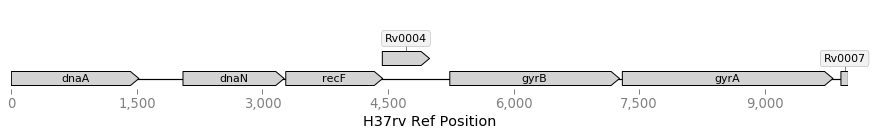

In [1548]:
fig, axs = plt.subplots(1, 1, figsize=(15, 1.5), sharex=True)

Start_Coord = 0
End_Coord = 10000
Mtb_H37rv_Graphic_Record_Crop = Mtb_H37rv_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Mtb_H37rv_Graphic_Record_Crop.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.set(xlabel='H37rv Ref Position')
plt.show()

### 1) Viz near BubbleRegion 20

In [1549]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_20'")  

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
19,NC_000962.3,189429,189429,0,186,"s51,s2793,s52",*,CCAGAGTCCGGGACGGTGGCACCCCGCAGCTGCGGCTGGAACAGGT...,[s2793],s51,s52,20,BubbleRegion_20,1,PE4,Rv0160c


Plotting 188629-190829 of H37Rv


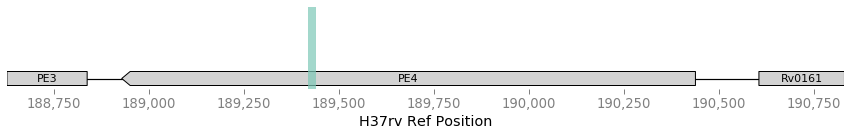

In [1550]:
fig, axs = plt.subplots(1, 1, figsize=(15, 1.5), sharex=True)

BubbleID = "BubbleRegion_20"

Bubble_Start = MG_SV_BED_DF.query(f"BubbleID == '{BubbleID}'")["Start"].values[0]
Bubble_End = MG_SV_BED_DF.query(f"BubbleID == '{BubbleID}'")["End"].values[0]

Start_Coord = Bubble_Start - 800
End_Coord = Bubble_End + 1400
print(f"Plotting {Start_Coord}-{End_Coord} of H37Rv")

Mtb_H37rv_Graphic_Record_Crop = Mtb_H37rv_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Mtb_H37rv_Graphic_Record_Crop.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.fill_between((Bubble_Start- 10, Bubble_End + 10), +1000, -1000, alpha=0.7, color = "#7DC8B7")

axs.set(xlabel='H37rv Ref Position')
plt.show()

### 3) Viz near BubbleRegion 309

In [1551]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_309'")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
308,NC_000962.3,2627049,2639487,3507,30484,"s939,s2720,s940,s2462,s941,s2966,s942,s943,s30...",GAACCGCCCCGGTGAGTCCGGAGACTCTCTGATCTGAGACCTCAGC...,CAGCATCGTATGACAATCCGCGGACAATATCCCGGGTTTTCTAATT...,"[s2720, s940, s2462, s941, s2966, s942, s943, ...",s939,s970,309,BubbleRegion_309,88,"plcC,plcB,plcA,PPE38,PPE39,Rv2354,Rv2355,PPE40","Rv2349c,Rv2350c,Rv2351c,Rv2352c,Rv2353c,Rv2354..."


Plotting 2624049-2644487 of H37Rv


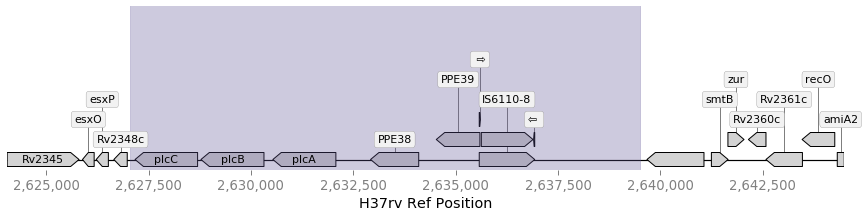

In [1552]:
fig, axs = plt.subplots(1, 1, figsize=(15, 3), sharex=True)

BubbleID = "BubbleRegion_309"

Bubble_Start = MG_SV_BED_DF.query(f"BubbleID == '{BubbleID}'")["Start"].values[0]
Bubble_End = MG_SV_BED_DF.query(f"BubbleID == '{BubbleID}'")["End"].values[0]

Start_Coord = Bubble_Start - 3000
End_Coord = Bubble_End + 5000
print(f"Plotting {Start_Coord}-{End_Coord} of H37Rv")

Mtb_H37rv_Graphic_Record_Crop = Mtb_H37rv_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Mtb_H37rv_Graphic_Record_Crop.features[9].label = "IS6110-8"
Mtb_H37rv_Graphic_Record_Crop.features[10].label = " "
Mtb_H37rv_Graphic_Record_Crop.features[11].label = " "
Mtb_H37rv_Graphic_Record_Crop.features[12].label = " "
Mtb_H37rv_Graphic_Record_Crop.features[13].label = " "
Mtb_H37rv_Graphic_Record_Crop.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.fill_between((Bubble_Start- 10, Bubble_End + 10), +1000, -1000, alpha=0.3, color = "#5C5092")

axs.set(xlabel='H37rv Ref Position')
plt.show()

In [1553]:
Mtb_H37rv_Graphic_Record_Crop.features[10]

GF( , 2635576-2635604 (1))

In [1554]:
#Mtb_H37rv_Graphic_Record.features

In [1555]:
Mtb_H37rv_Graphic_Record_Crop.features[9].label = "IS6110-8"
Mtb_H37rv_Graphic_Record_Crop.features[10].label = ""
Mtb_H37rv_Graphic_Record_Crop.features[11].label = ""
Mtb_H37rv_Graphic_Record_Crop.features[12].label = ""
Mtb_H37rv_Graphic_Record_Crop.features[13].label = ""


In [1556]:
Mtb_H37rv_Graphic_Record_Crop.features

[GF(Rv2345, 2624049-2625803 (1)),
 GF(esxO, 2625887-2626172 (-1)),
 GF(esxP, 2626222-2626519 (-1)),
 GF(Rv2348c, 2626653-2626980 (-1)),
 GF(plcC, 2627171-2628698 (-1)),
 GF(plcB, 2628780-2630319 (-1)),
 GF(plcA, 2630536-2632075 (-1)),
 GF(PPE38, 2632922-2634098 (-1)),
 GF(PPE39, 2634527-2635592 (-1)),
 GF(IS6110-8, 2635576-2636931 (1)),
 GF(, 2635576-2635604 (1)),
 GF(, 2635627-2636889 (1)),
 GF(, 2636903-2636931 (-1)),
 GF(, 2639672-2641064 (-1)),
 GF(smtB, 2641245-2641653 (1)),
 GF(zur, 2641649-2642042 (1)),
 GF(Rv2360c, 2642149-2642578 (-1)),
 GF(Rv2361c, 2642577-2643468 (-1)),
 GF(recO, 2643460-2644258 (-1)),
 GF(amiA2, 2644319-2644488 (1))]

In [1557]:
Mtb_H37rv_Graphic_Record_Crop.features[10]

GF(, 2635576-2635604 (1))

In [1558]:
Mtb_H37rv_Graphic_Record_Crop.features[9:14]

[GF(IS6110-8, 2635576-2636931 (1)),
 GF(, 2635576-2635604 (1)),
 GF(, 2635627-2636889 (1)),
 GF(, 2636903-2636931 (-1)),
 GF(, 2639672-2641064 (-1))]

In [1559]:
Z = Mtb_H37rv_Graphic_Record_Crop.features[10]

In [1560]:
Z.label= ""

In [1561]:
Z.data

{'nlines': 1, 'fixed_level': 2.0}

In [1562]:
#Mtb_H37rv_Graphic_Record_Crop.features

### 3) Viz near BubbleRegion 380

In [1563]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_380'")

,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
379,NC_000962.3,3251646,3252957,1130,1311,"s1198,s2792,s1199,s1200",AGATTCATAAATTGGAGTAACGCATAGATACACTGTTTACAAGCCC...,GGGATTACGGGGTCCGGCGGTCGCGGTGGACACCGCCTGCTCGTCG...,"[s2792, s1199]",s1198,s1200,380,BubbleRegion_380,2,ppsB,Rv2932


Plotting 3248646-3257957 of H37Rv


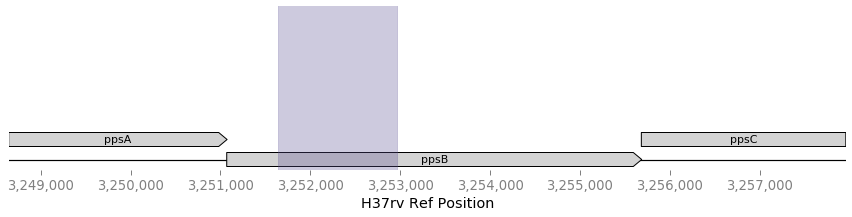

In [1564]:
fig, axs = plt.subplots(1, 1, figsize=(15, 3), sharex=True)

BubbleID = "BubbleRegion_380"

Bubble_Start = MG_SV_BED_DF.query(f"BubbleID == '{BubbleID}'")["Start"].values[0]
Bubble_End = MG_SV_BED_DF.query(f"BubbleID == '{BubbleID}'")["End"].values[0]

Start_Coord = Bubble_Start - 3000
End_Coord = Bubble_End + 5000
print(f"Plotting {Start_Coord}-{End_Coord} of H37Rv")

Mtb_H37rv_Graphic_Record_Crop = Mtb_H37rv_Graphic_Record.crop((Start_Coord, End_Coord + 1))
Mtb_H37rv_Graphic_Record_Crop.plot(strand_in_label_threshold=5, ax = axs, plot_sequence = False)

axs.fill_between((Bubble_Start- 10, Bubble_End + 10), +1000, -1000, alpha=0.3, color = "#5C5092")

axs.set(xlabel='H37rv Ref Position')
plt.show()

In [1565]:
MG_SVNodes_DF_GrpByBubbleStats.query(" BubbleID == 'BubbleRegion_380' ")

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_380,2.0,0.00039,0.000552,0.0,0.000195,0.00039,0.000585,0.000781,2441,1130.0,2441.0,ppsB,2


In [1566]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_380'")  


,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
379,NC_000962.3,3251646,3252957,1130,1311,"s1198,s2792,s1199,s1200",AGATTCATAAATTGGAGTAACGCATAGATACACTGTTTACAAGCCC...,GGGATTACGGGGTCCGGCGGTCGCGGTGGACACCGCCTGCTCGTCG...,"[s2792, s1199]",s1198,s1200,380,BubbleRegion_380,2,ppsB,Rv2932


In [1567]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_380'") 

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_380,2.0,0.00039,0.000552,0.0,0.000195,0.00039,0.000585,0.000781,2441,1130.0,2441.0,ppsB,2


In [1568]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_380'")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
379,NC_000962.3,3251646,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=1311,1130;AC=151,1;VS=>s1198;...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,">s1199,>s2792","[>s1199, >s2792]",BubbleRegion_380,s1198,s1200,"[s2792, s1199]",2


In [1569]:
# QC-9 is the assembly with the variation

In [1570]:
Z = MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_380'").T
Z.columns = ["A"]

Z.query("A != '0:0'")

,A
Chr,NC_000962.3
Pos,3251646
ID,.
Ref,N
Alt,<CNV>
QUAL,30
FILTER,PASS
Info,"NS=152;NA=2;ALEN=1311,1130;AC=151,1;VS=>s1198;..."
FORMAT,GT:GT0
QC-9,1:1


### Looking at sus large BUBBLEs

In [1571]:
# BubbleRegion_60

In [1572]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_60'")  


,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
59,NC_000962.3,560425,561498,1001,1073,"s163,s2804,s164,s165",TACTGGCGAGCCGATACGATGCGCGCGCGCACAAATACTGCTACAA...,GCGTCAAGGTGACGATGAGCGATGTGCGGTTTATGAAATTCATCGG...,"[s2804, s164]",s163,s165,60,BubbleRegion_60,2,"umaA,pcaA","Rv0469,Rv0470c"


In [1573]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_60'") 

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_60,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2074,1001.0,2074.0,"umaA,pcaA",2


In [1574]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_60'")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
59,NC_000962.3,560425,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=1073,1001;AC=151,1;VS=>s163;V...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,">s164,>s2804","[>s164, >s2804]",BubbleRegion_60,s163,s165,"[s2804, s164]",2


In [1575]:
# QC-10 is the assembly with the variation

In [1576]:
Z = MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_60'").T
Z.columns = ["A"]

Z.query("A != '0:0'")

,A
Chr,NC_000962.3
Pos,560425
ID,.
Ref,N
Alt,<CNV>
QUAL,30
FILTER,PASS
Info,"NS=152;NA=2;ALEN=1073,1001;AC=151,1;VS=>s163;V..."
FORMAT,GT:GT0
QC-10,1:1


In [1577]:
# BubbleRegion_440

In [1578]:
MG_SV_BED_DF.query("BubbleID == 'BubbleRegion_440'")  


,Chr,Start,End,Len_Ref,Len_Alt,NodePath,Ref_Seq,Alt_Seq,NodePath_Trimmed,Start_Node,End_Node,BubbleNum,BubbleID,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs
439,NC_000962.3,3790907,3790907,0,1358,"s1411,s3069,s1412",*,CTGAACCGCCCCGGCATGTCCGGAGACTCCAGTTCTTGGAAAGGAT...,[s3069],s1411,s1412,440,BubbleRegion_440,1,Rv3377c,Rv3377c


In [1579]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_440'") 

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_440,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1358,0.0,0.0,Rv3377c,2


In [1580]:
MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_440'")

,Chr,Pos,ID,Ref,Alt,QUAL,FILTER,Info,FORMAT,NC_000962.3,N0072,N0153,TB3113,TB1236,TB2659,TB2780,TB1612,TB2512,TB2981,TB3091,M0003941_3,TB3368,N0145,N0155,TB2995,TB3396,N0004,N1274,N0054,02_R1179,01_R1134,M0017522_5,M0016395_7,M0010874_7,02_R1708,02_R0894,01_R1430,M0014888_3,02_R1896,TB4620,TB3162,MT_0080,TB3054,TB3251,M0016737_0,TB2661,TB3237,TB3169,TB3386,TB3334,M0011368_9,TB2968,N1272,N1176,N1202,N1177,N0091,RW-TB008,9050-05,4549-04,696-05,702-06,706-05,8129-04,3003-06,8651-04,QC-3,QC-9,QC-5,QC-8,QC-10,QC-4,QC-7,QC-6,QC-1,mada_1-10,mada_2-46,mada_1-1,mada_1-36,mada_1-39,mada_1-51,mada_1-44,mada_117,mada_118,mada_122,mada_107,R27252,R23887,R30215,R30078,R29816,R30234,18_0621851,R36431,R28703,mada_115,mada_2-42,R31095,R28012,R37765,R27657,R25048,R24120,R28581,R29598,mada_1-11,R24100,R21408,R20574,R20260,R18043,R22601,R23146,R32929,R21893,R30420,R26778,R26791,R28980,R27725,R18040,R27937,mada_1-30,mada_2-31,mada_1-41,R21770,R21839,mada_1-32,R30396,R21363,R20896,mada_102,mada_129,mada_139,mada_151,mada_105,R15311,mada_103,mada_2-25,mada_112,mada_124,mada_126,mada_120,R23571,mada_128,mada_1-12,mada_1-15,mada_2-1,mada_1-53,mada_1-50,mada_123,mada_2-53,mada_1-38,S0070-08,S0085-01,S0107-01,S0089-01,S0256-08,S0123-01,S0106-01,S0262-02,NA,AWALK_Full,AWALK_List,BubbleID,Start_Node,End_Node,NodePath_Trimmed,NumSVNodes
439,NC_000962.3,3790907,.,N,<CNV>,30,PASS,"NS=152;NA=2;ALEN=0,1358;AC=150,2;VS=>s1411;VE=...",GT:GT0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,1:1,1:1,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,0:0,2,"*,>s3069","[*, >s3069]",BubbleRegion_440,s1411,s1412,[s3069],1


In [1581]:
# QC-10 is the assembly with the variation

In [1582]:
Z = MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_440'").T
Z.columns = ["A"]

Z.query("A != '0:0'")

,A
Chr,NC_000962.3
Pos,3790907
ID,.
Ref,N
Alt,<CNV>
QUAL,30
FILTER,PASS
Info,"NS=152;NA=2;ALEN=0,1358;AC=150,2;VS=>s1411;VE=..."
FORMAT,GT:GT0
mada_126,1:1


In [1583]:
MG_SVNodes_DF_GrpByBubbleStats.query("BubbleID == 'BubbleRegion_476'") 

,count,mean,std,min,25%,50%,75%,max,TotalLength,SeqLength_UnqToRv,SeqLength_UnqToGraph,Overlap_Genes,NA
BubbleID,,,,,,,,,,,,,
BubbleRegion_476,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2470,1243.0,2470.0,ilvX,2


In [1584]:
Z = MG_SVVCF_DF.query("BubbleID == 'BubbleRegion_476'").T
Z.columns = ["A"]

Z.query("A != '0:0'")

,A
Chr,NC_000962.3
Pos,3937189
ID,.
Ref,N
Alt,<CNV>
QUAL,30
FILTER,PASS
Info,"NS=152;NA=2;ALEN=1227,1243;AC=151,1;VS=>s1543;..."
FORMAT,GT:GT0
mada_124,1:1


In [1585]:
RDsToRv_1kb_DF

,BubbleID,Start,End,NumSVNodes,Overlap_Genes,Overlap_Gene_RvIDs,TotalLength,SeqLength_UnqToRv
0,BubbleRegion_31,334243,338669,70,"PE_PGRS3,PE_PGRS4","Rv0278c,Rv0279c",12630,3211.0
1,BubbleRegion_60,560425,561498,2,"umaA,pcaA","Rv0469,Rv0470c",2074,1001.0
2,BubbleRegion_102,917629,918744,4,"Rv0823c,desA1","Rv0823c,Rv0824c",2210,1095.0
3,BubbleRegion_116,1053645,1053787,2,"Rv0943c,Rv0944","Rv0943c,Rv0944",4541,4399.0
4,BubbleRegion_129,1181855,1215202,48,"fadD14,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,lpq...","Rv1058,Rv1059,Rv1060,Rv1061,Rv1062,Rv1063c,Rv1...",67323,1697.0
5,BubbleRegion_193,1761789,1761789,3,mmpL6,Rv1557,3511,2153.0
6,BubbleRegion_221,1986625,1999613,116,"Rv1754c,plcD,Rv1756c,Rv1757c,cut1,wag22,Rv1760...","Rv1754c,Rv1755c,Rv1756c,Rv1757c,Rv1758,Rv1759c...",53885,7500.0
7,BubbleRegion_255,2208005,2223187,26,"yrbE3A,yrbE3B,mce3A,mce3B,mce3C,mce3D,lprM,mce...","Rv1964,Rv1965,Rv1966,Rv1967,Rv1968,Rv1969,Rv19...",29094,4496.0
8,BubbleRegion_265,2268723,2268723,17,"Rv2023A,Rv2024c","Rv2023A,Rv2024c",8232,5518.0
9,BubbleRegion_362,3114093,3157869,224,"Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...","Rv2807,Rv2808,Rv2809,Rv2810c,Rv2811,Rv2812,Rv2...",135873,1232.0


In [1586]:
# import plotly.graph_objects as go

# # Define node labels
# labels = ["Input", "Process A", "Process B", "Output A", "Output B"]

# # Define the source and target nodes and the value of each flow
# source = [0, 0, 1, 1, 2, 2]  # indices correspond to labels
# target = [1, 2, 3, 4, 3, 4]
# value = [8, 2, 4, 4, 1, 1]

# # Define the data for the Sankey diagram
# data = go.Sankey(node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels),
#                  link=dict(source=source, target=target, value=value))

# # Define the layout for the plot
# layout = go.Layout(title="Basic Sankey Diagram with Plotly", font=dict(size=10))

# # Create the figure
# fig = go.Figure(data=[data], layout=layout)

# # Display the figure in the output cell of a Jupyter notebook
# fig.show()
